In [1]:
import glob
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
import numpy as np

2023-12-03 18:35:02.679458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 18:35:03.933166: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 18:35:07.210113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 18:35:07.477080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 18:35:50.632501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def load_shape_info(dir):
    import pickle
    with open(dir + '/pickleshapes', 'rb') as file:
        # Load the data from the file
        shapes = pickle.load(file)
        return shapes
def _lab_labels(all_labels):
        #, this is an embedded function called from below
        labels = {}
        labels['comp_labels'] = tf.one_hot(tf.cast(all_labels[0],tf.int32),3)
        labels['amp_labels'] = tf.one_hot(tf.cast(all_labels[1],tf.int32),10)
        labels['torque_labels'] = tf.one_hot(tf.cast(all_labels[2],tf.int32),5)
        labels['joint_labels'] = tf.one_hot(tf.cast(all_labels[3],tf.int32),3)
        return labels        

In [8]:
def load_tf_data(folder,shape_info):
    tf_records = glob.glob(os.path.join(folder, '*.tf'))
    dataset = tf.data.TFRecordDataset(tf_records)
    def _parse_function(example_proto):
        feature_description = {
            'ts': tf.io.FixedLenFeature(shape_info[0], tf.float32),
            'labels': tf.io.FixedLenFeature(shape_info[1], tf.float32),
            'pos_labels': tf.io.FixedLenFeature(shape_info[2], tf.float32)
        }
        #example = tf.io.parse_single_example(example_proto, feature_description)
        example = tf.io.parse_example(example_proto, feature_description)
        all_labels = tf.cast(example['labels'], tf.float32)
        #all_labels = example['labels']
        labels = _lab_labels(all_labels)
        if 'pos_labels' in example.keys():
            pos_labels = tf.cast(example['pos_labels'], tf.float32)
            labels['pos_labels'] = pos_labels
        ts = example['ts']
        #labels = all_labels
        return ts, labels['comp_labels'],labels['pos_labels']
        #return example['ts'], labels
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size=500, drop_remainder = False)
    return dataset

In [9]:
#dir_base = '/scratch/user/swati/Capstone/'
#dir_data = 'RoughCut_Datasets' /
dir_base = '/scratch/group/statconsult/Output_hema/'
dir_data = 'Data6_Copy/'
dir = dir_base + dir_data + '/'
train_shape_info = load_shape_info(dir + 'train')
test_shape_info = load_shape_info(dir + 'predict')
predict_shape_info = load_shape_info(dir + 'validate')
train_data = load_tf_data(dir + 'train',train_shape_info)
test_data = load_tf_data(dir + 'predict',test_shape_info)
predict_data = load_tf_data(dir + 'validate',predict_shape_info)

In [10]:
# Apply the parsing function and create a batch
batch_size = 5  # Adjust this based on how many samples you want to display
#parsed_train_dataset = train_dataset.map(parse_tfrecord_fn) #.batch(batch_size)
for batch in train_data.take(1):  # Take one batch
    print(batch)

(<tf.Tensor: shape=(500, 1000, 105), dtype=float32, numpy=
array([[[ 9.85145569e-04,  5.78308105e-03, -1.40304565e-02, ...,
         -1.35040283e-02,  5.74493408e-03,  8.04901123e-03],
        [-1.45053864e-03,  3.44657898e-03, -1.02920532e-02, ...,
         -8.59832764e-03, -1.05285645e-03, -1.04064941e-02],
        [-4.48989868e-03,  2.71415710e-03, -2.64167786e-03, ...,
          5.59616089e-03,  3.79638672e-02, -1.62792206e-03],
        ...,
        [-3.21769714e-03, -2.86102295e-03, -5.98144531e-03, ...,
         -6.80923462e-03,  1.69982910e-02,  8.14819336e-03],
        [-5.77926636e-03,  9.20295715e-04, -5.34820557e-03, ...,
          1.40476227e-03, -2.12097168e-02,  2.30407715e-02],
        [-6.16073608e-03,  1.05094910e-03, -1.19781494e-03, ...,
          3.32069397e-03,  9.90295410e-03, -1.14669800e-02]],

       [[-3.61061096e-03,  5.74588776e-05,  1.06906891e-03, ...,
          2.71797180e-03,  8.39233398e-04, -6.69860840e-03],
        [-1.47247314e-03,  3.07273865e-03,  

In [19]:
pos_labelss = []
for ts, labels,pos_labels in train_data.take(1):
    print("Time Series Shape:", ts.shape)
    print("Labels Shape:",labels.shape)
    print("POS Labels Shape:",pos_labels.shape)
    #print(pos_labels)
    pos_labelss.append(pos_labels.numpy())

Time Series Shape: (500, 1000, 105)
Labels Shape: (500, 3)
POS Labels Shape: (500, 3, 105)


In [23]:
pip install plotly==5.18.0

     |████████████████████████████████| 15.6 MB 9.4 MB/s eta 0:00:01
You should consider upgrading via the '/scratch/user/swati/pip_envs/my_notebook-Python/3.8.2/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
x=[]
y=[]
z=[]
for i in range(105):
    x.append(pos_labelss[0][0][0][i])
    y.append(pos_labelss[0][0][1][i])
    z.append(pos_labelss[0][0][2][i])

In [30]:
features_imp = [20, 21, 19, 104, 86, 18, 102, 16, 103, 15, 17, 105, 13, 87, 24, 92, 101, 99, 100, 61, 41, 60, 39, 98, 96, 85, 12, 97, 14, 83, 43,
91, 42, 84, 82, 94, 40, 78, 81, 58, 62, 37, 54, 33, 33, 63, 59, 75, 57, 79]

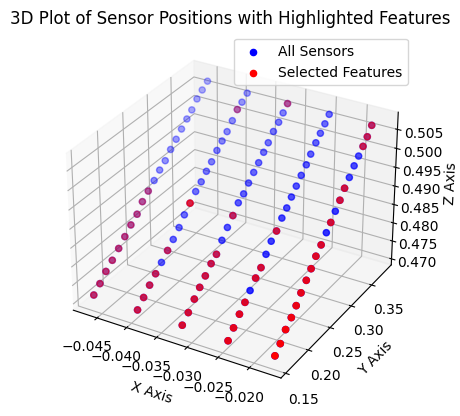

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

features_imp = [20, 21, 19, 104, 86, 18, 102, 16, 103, 15, 17, 105, 13, 87, 24, 92, 101, 99, 100, 61, 41, 60, 39, 98, 96, 85, 12, 97, 14, 83, 43,
                91, 42, 84, 82, 94, 40, 78, 81, 58, 62, 37, 54, 33, 33, 63, 59, 75, 57, 79]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting all sensor positions in blue
ax.scatter(x, y, z, c='b', marker='o', label='All Sensors')

# Highlighting sensor positions corresponding to features_imp in red
ax.scatter([x[i-1] for i in features_imp], [y[i-1] for i in features_imp], [z[i-1] for i in features_imp],
           c='r', marker='o', label='Selected Features')

# Labeling axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.title('3D Plot of Sensor Positions with Highlighted Features')
plt.legend()
plt.show()


In [39]:
import plotly.graph_objects as go

# Assuming you have x, y, z data for all sensors
# If not, you need to replace x, y, z with your actual data

# Plotting all sensor positions in blue
all_sensors_trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(color='blue', size=5),
    name='All Sensors'
)

# Highlighting sensor positions corresponding to features_imp in red
selected_features_trace = go.Scatter3d(
    x=[x[i-1] for i in features_imp],
    y=[y[i-1] for i in features_imp],
    z=[z[i-1] for i in features_imp],
    mode='markers',
    marker=dict(color='red', size=5),
    name='Selected Features'
)

# Create the layout with increased ticks and adjusted axis ranges for zooming
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X Axis', nticks=10, range=[min(x), max(x)]),
        yaxis=dict(title='Y Axis', nticks=10, range=[min(y), max(y)]),
        zaxis=dict(title='Z Axis', nticks=10, range=[min(z), max(z)]),
    ),
    title='3D Plot of Sensor Positions with Highlighted Features'
)

# Create the figure
fig = go.Figure(data=[all_sensors_trace, selected_features_trace], layout=layout)
fig.update_layout(width=1000, height=900)
# Show the figure
fig.show()


In [5]:
def combine_ts_batches(dataset):
    combined_ts = []
    train_labels = []
    for ts, labels in dataset:
        combined_ts.append(ts.numpy())
        train_labels.append(labels.numpy())
    combined_ts = np.concatenate(combined_ts, axis=0)
    return combined_ts,train_labels


In [6]:
import matplotlib.pyplot as plt

def visualize_top_features(pca_model, feature_names=None, top_n=5):
    # Get the principal components and their weights
    components = pca_model.components_

    # If feature_names is not provided, create default feature names
    if feature_names is None:
        feature_names = [f"Feature {i+1}" for i in range(components.shape[1])]

    # Plot bar charts for the top N features for each principal component
    for i in range(components.shape[0]):
        component_weights = list(zip(feature_names, components[i, :]))
        component_weights.sort(key=lambda x: abs(x[1]), reverse=True)
        top_features = component_weights[:top_n]

        features, weights = zip(*top_features)
        plt.figure(figsize=(10, 5))
        plt.bar(features, weights)
        plt.title(f'Top {top_n} Features for Principal Component {i+1}')
        plt.xlabel('Feature')
        plt.ylabel('Weight')
        plt.xticks(rotation=45, ha='right')
        plt.show()

In [7]:
def apply_pca(dataset):
    dataset_batch_size, sequence_length, feature_dim = dataset.shape
    reshaped_data = tf.reshape(dataset, (dataset_batch_size * sequence_length, feature_dim))
    print(dataset.shape)
    batch_size = 500
    dataset_batch_size = int(dataset_batch_size)
    if dataset_batch_size < batch_size:
        batch_size = dataset_batch_size   
    pca = PCA(n_components=50)
    pca_data = pca.fit_transform(reshaped_data)
    visualize_top_features(pca)
    pca_result = tf.reshape(pca_data, (int(dataset_batch_size/batch_size),batch_size, sequence_length, 50))
    return pca_result

In [8]:
def generate_reduced_dataset(ts_batches,label_batches):
    ts_batches = tf.convert_to_tensor(ts_batches, dtype=tf.float64)
    label_batches = tf.convert_to_tensor(label_batches, dtype=tf.float64)
    
    # Create a TensorFlow dataset
    reduced_dataset = tf.data.Dataset.from_tensor_slices((ts_batches, label_batches))
    return reduced_dataset

In [9]:
combined_train_ts,train_labels = combine_ts_batches(train_data)
combined_test_ts,test_labels = combine_ts_batches(test_data)
combined_val_ts,val_labels = combine_ts_batches(predict_data)

(108000, 1000, 105)


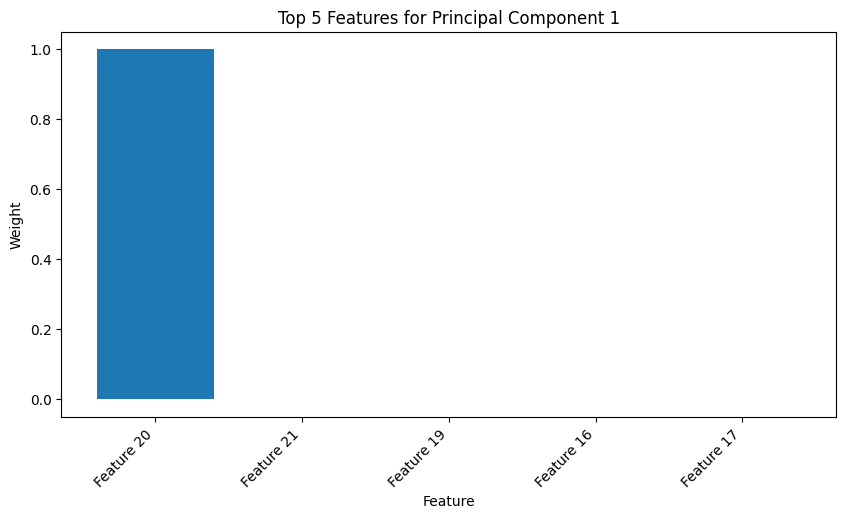

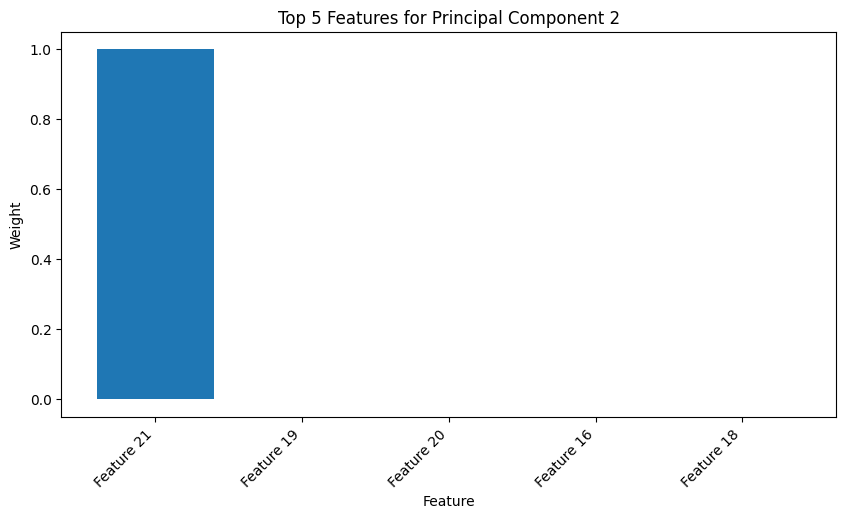

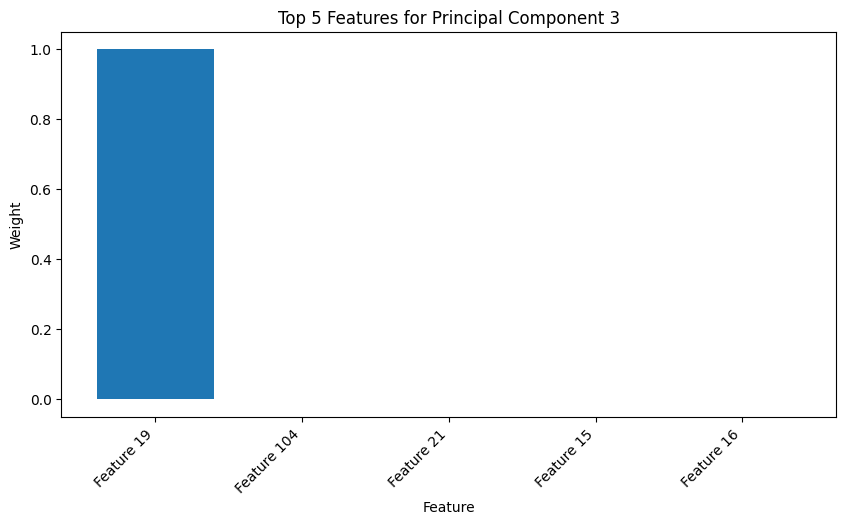

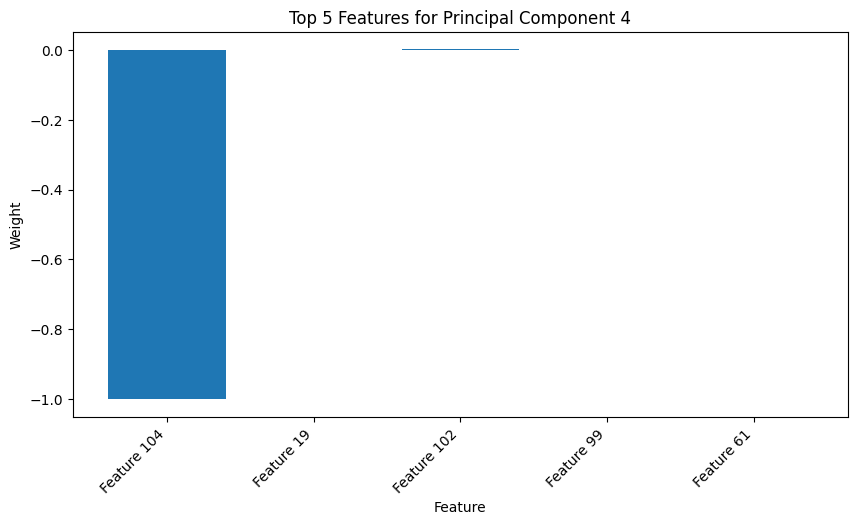

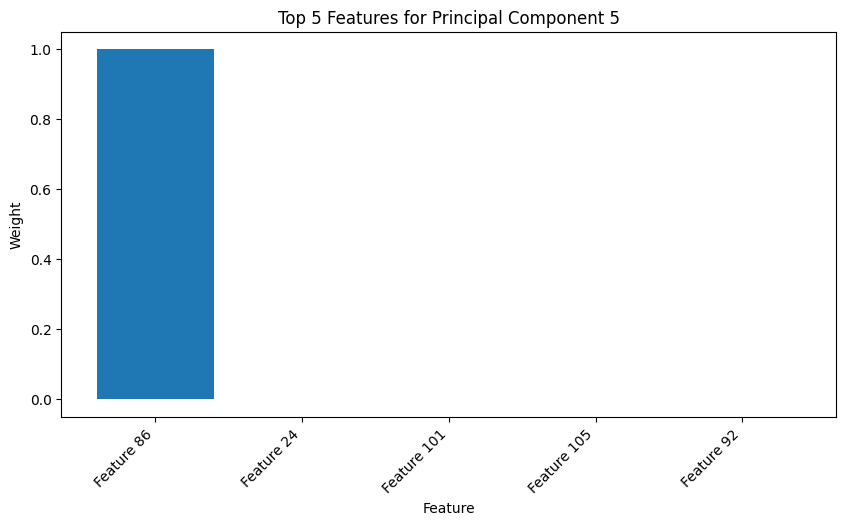

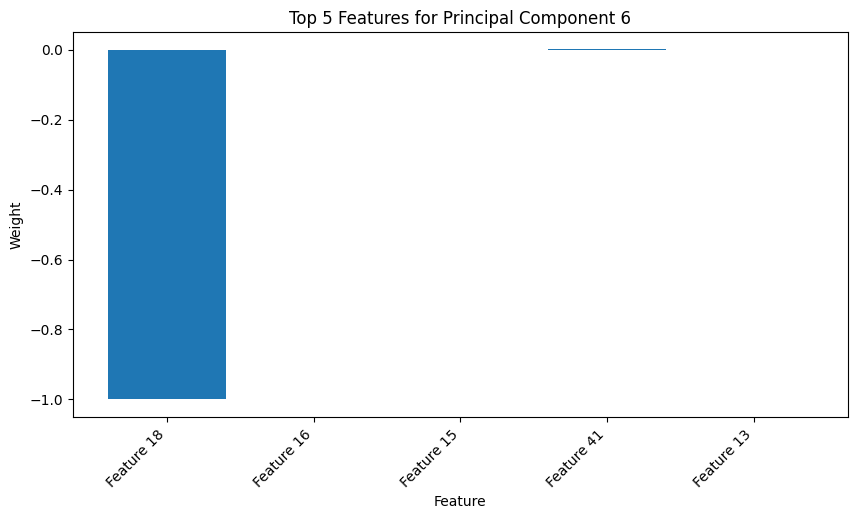

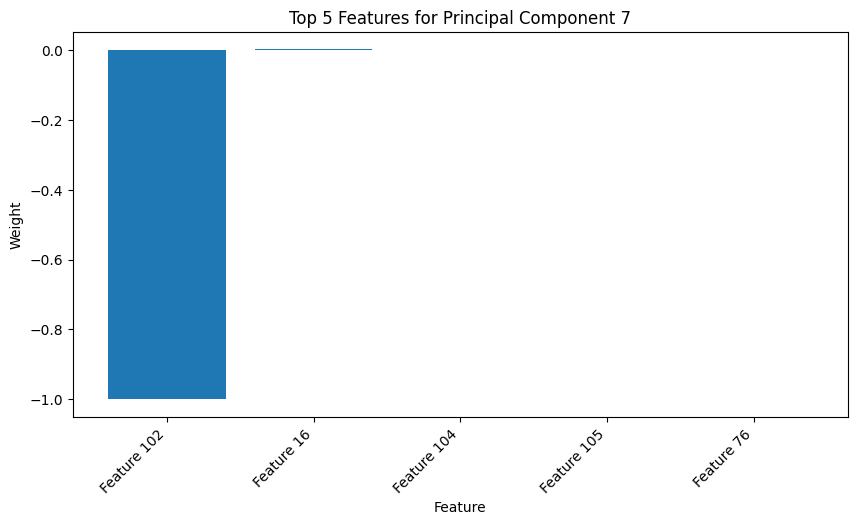

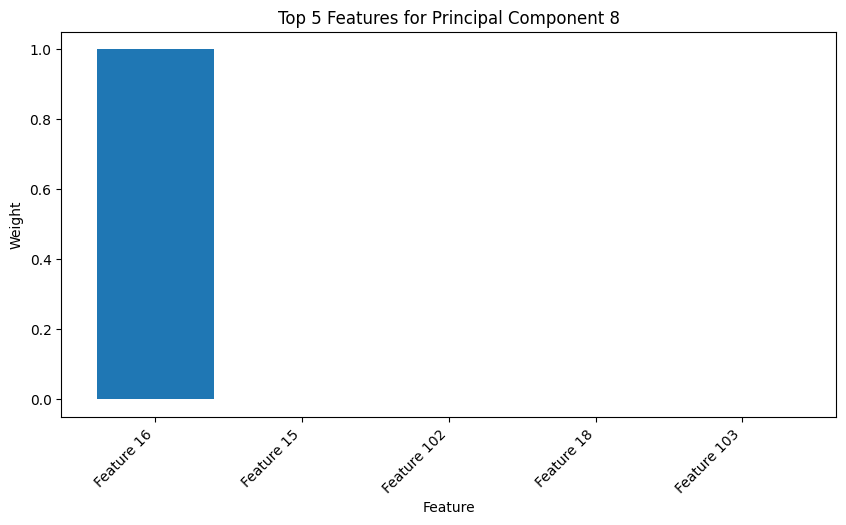

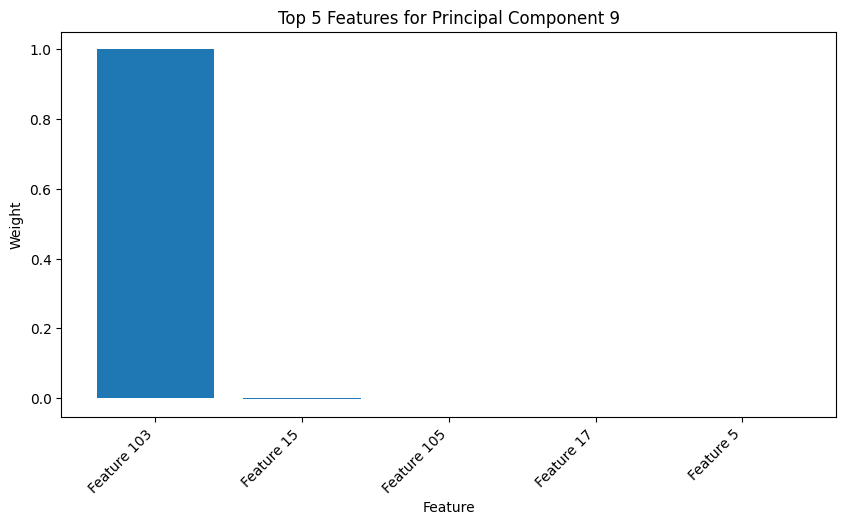

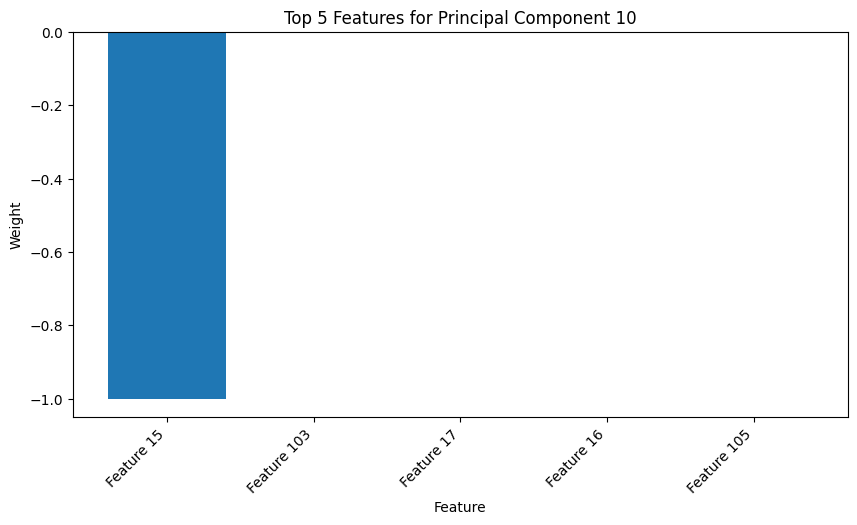

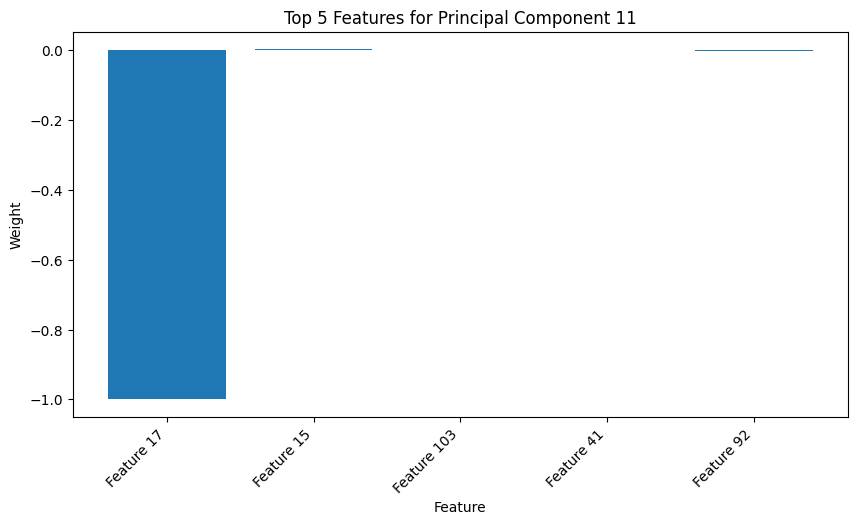

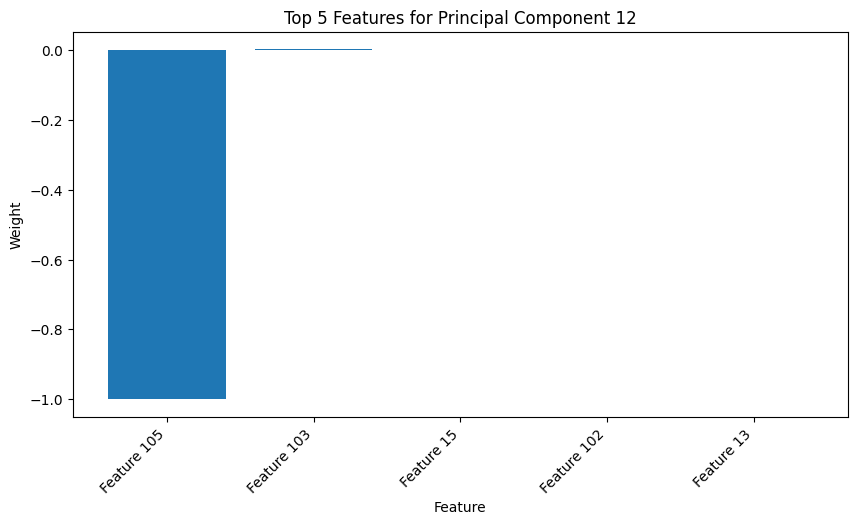

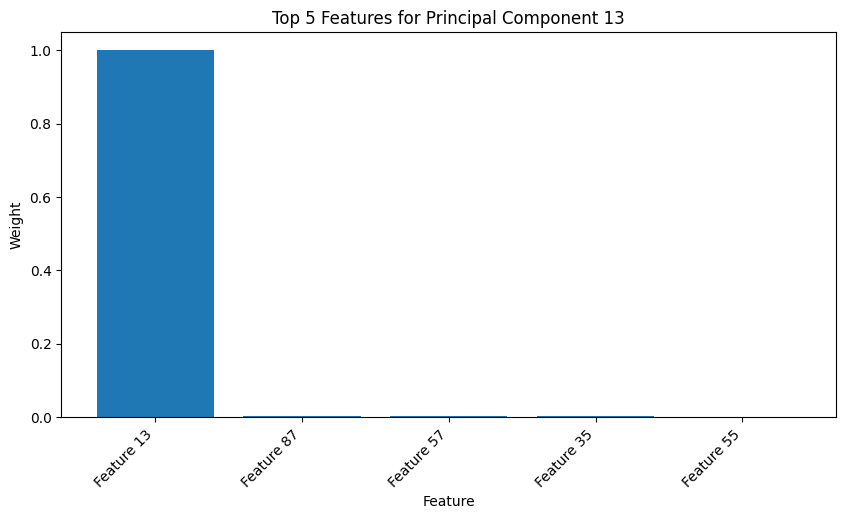

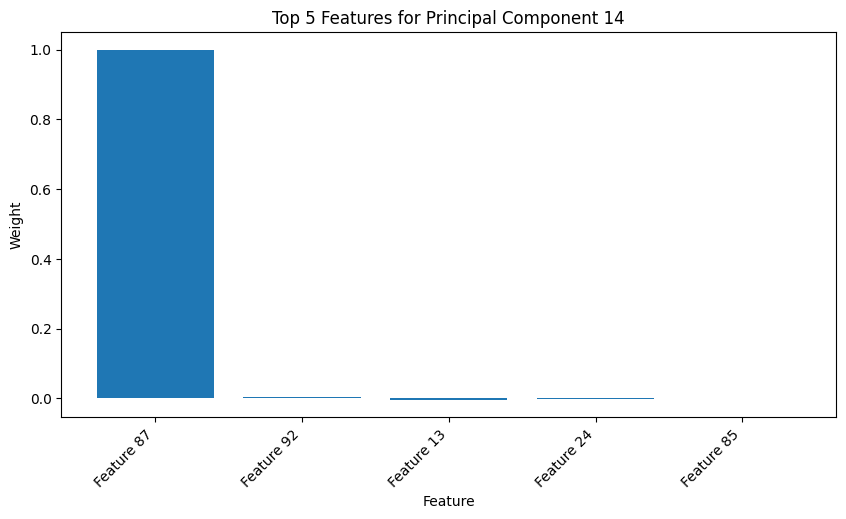

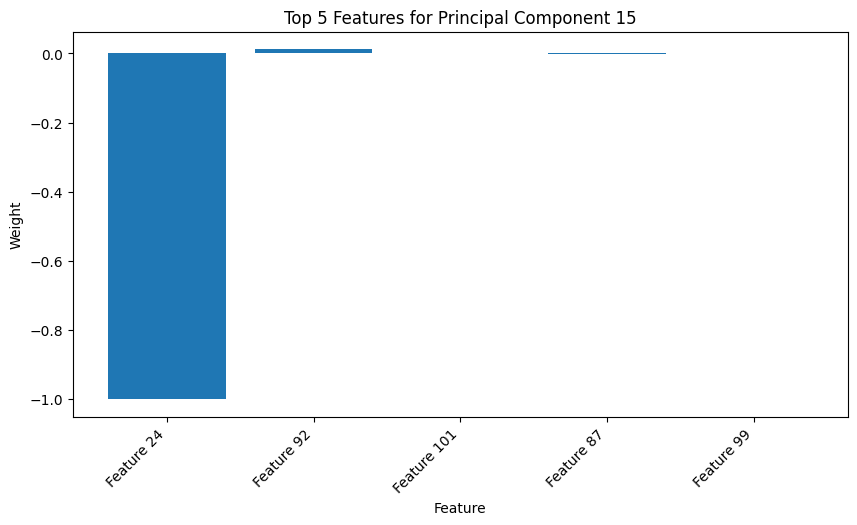

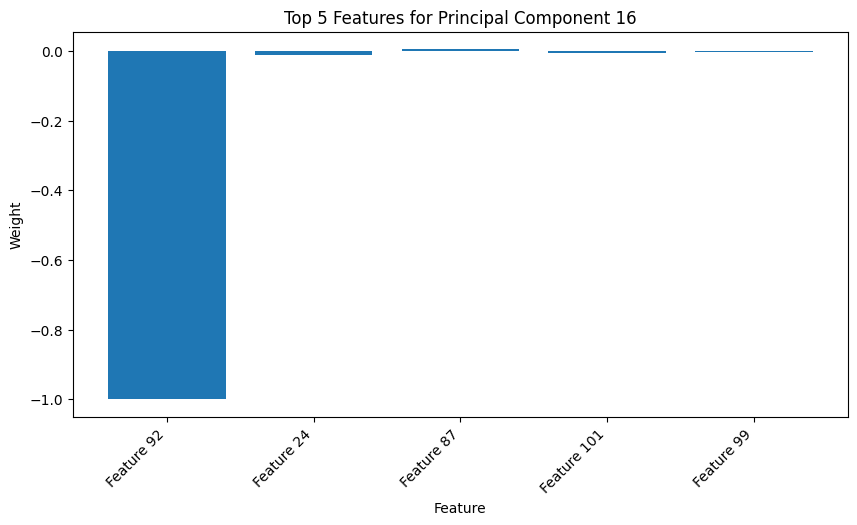

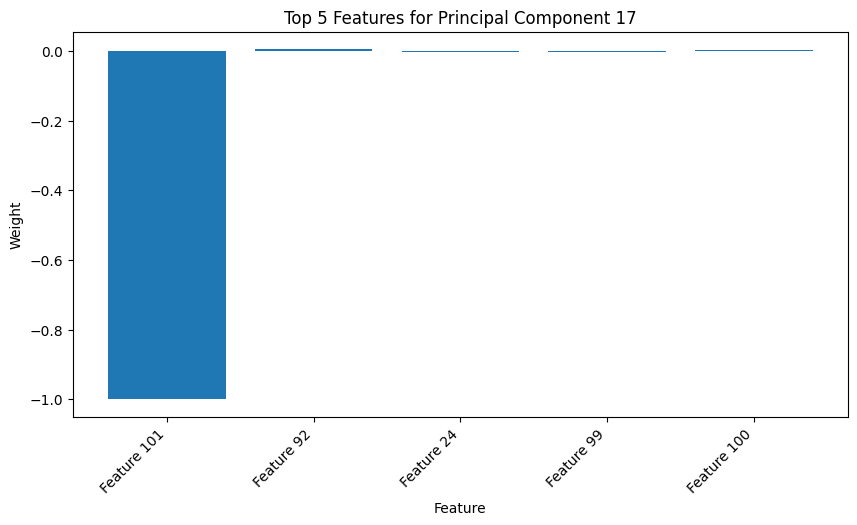

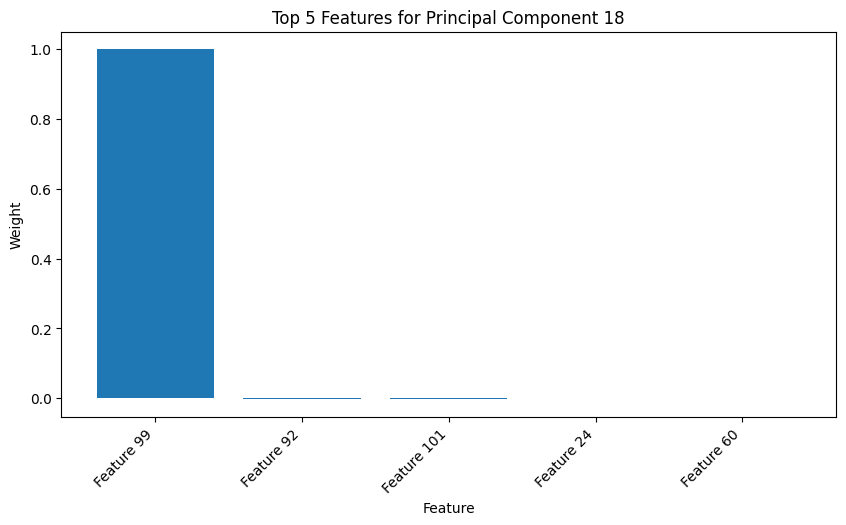

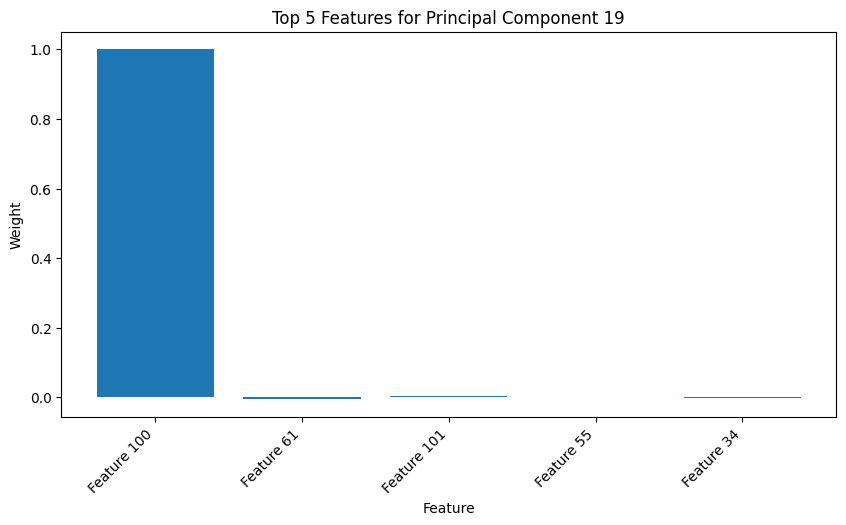

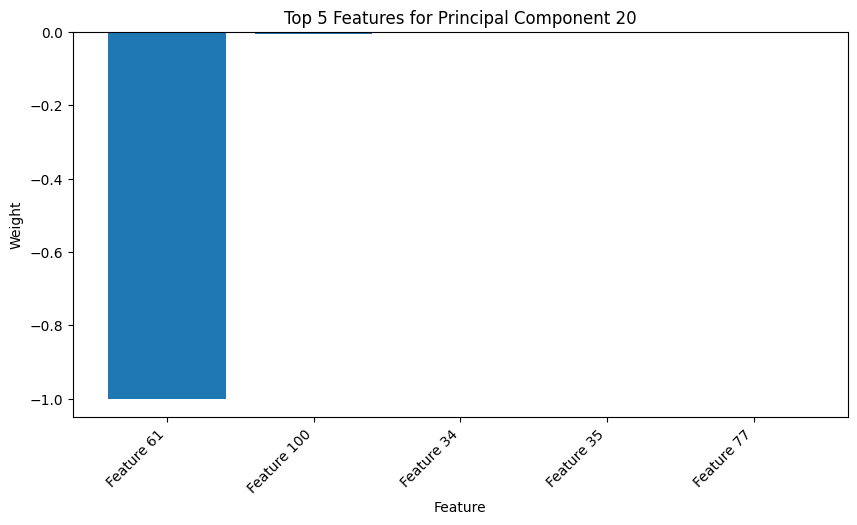

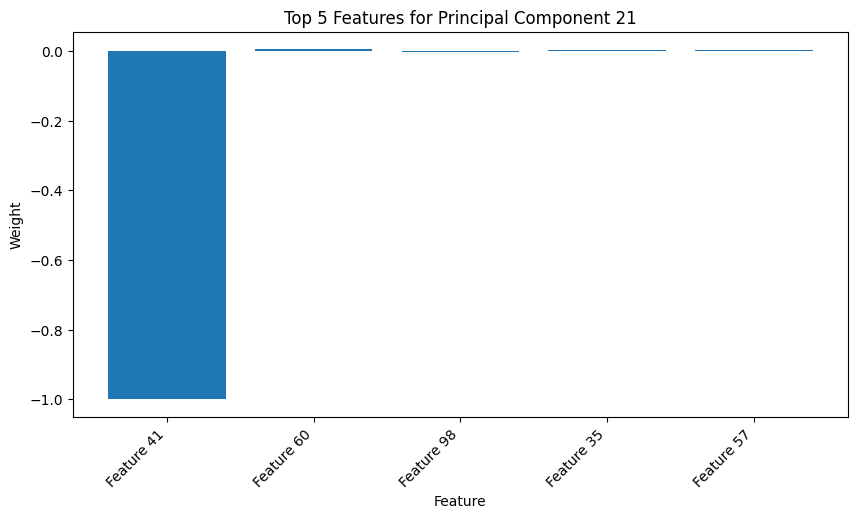

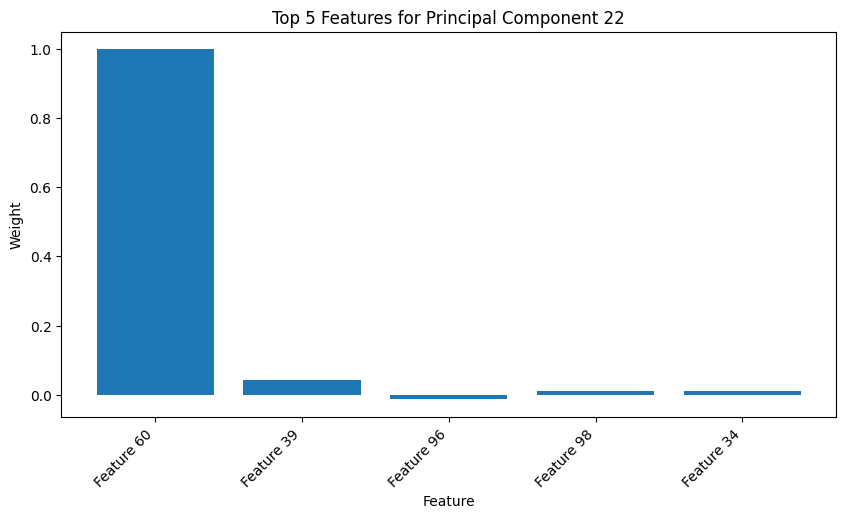

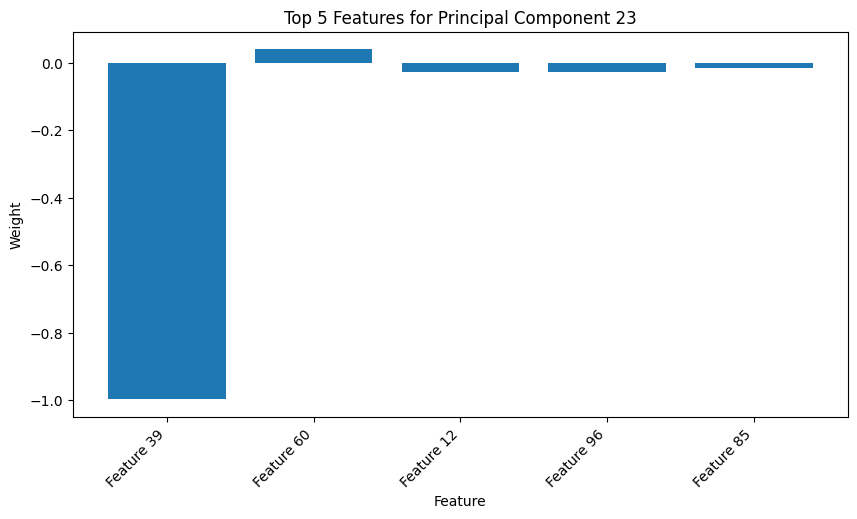

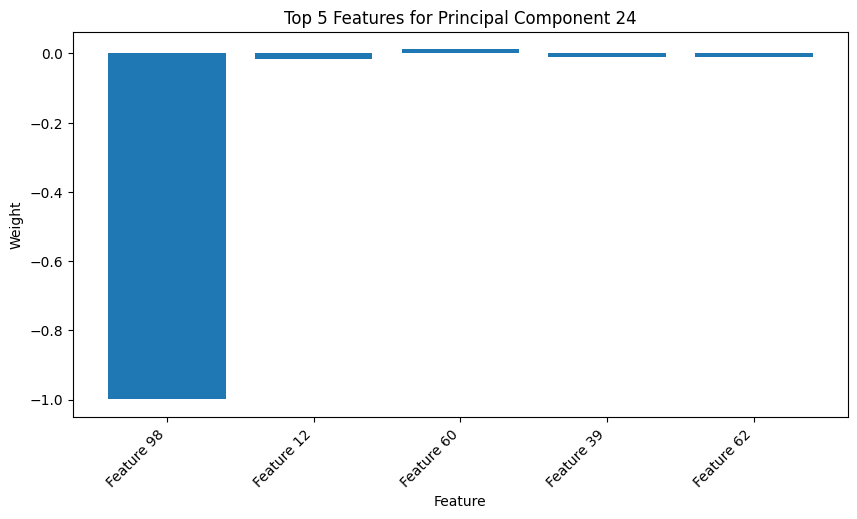

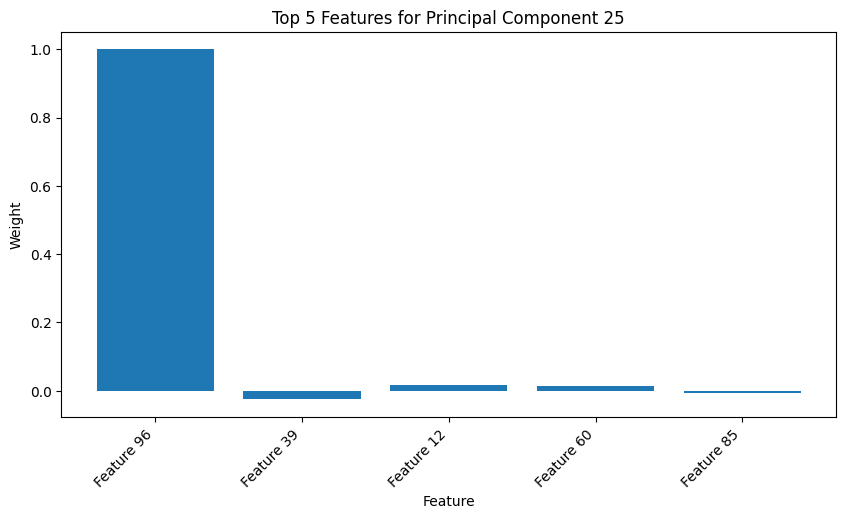

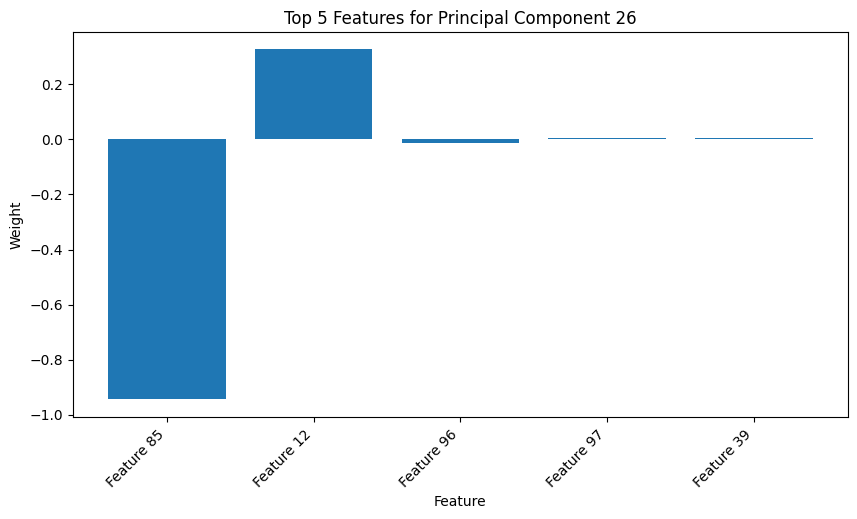

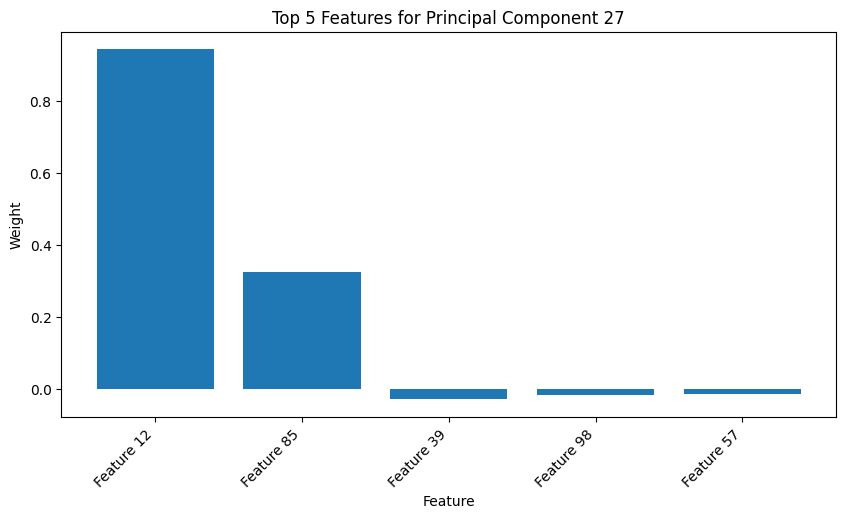

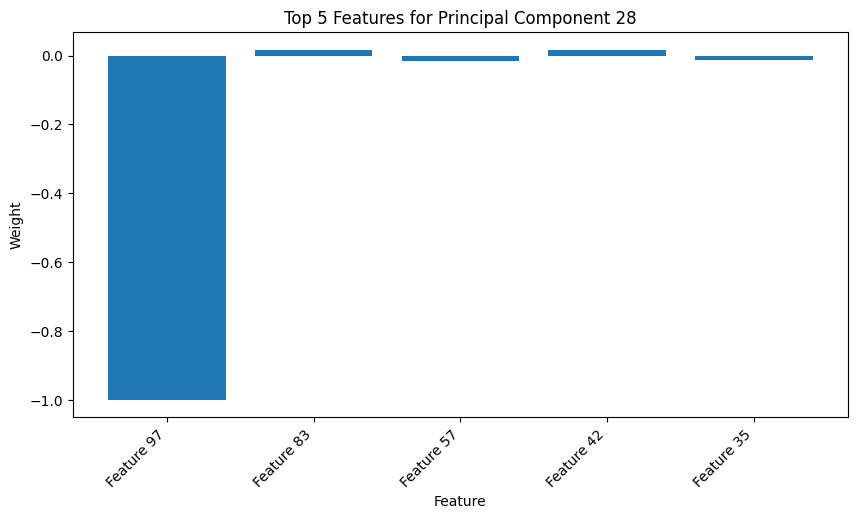

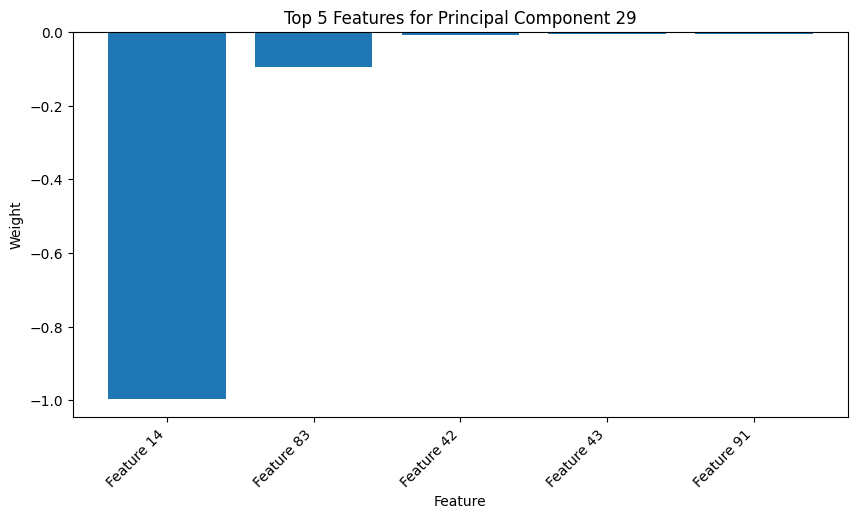

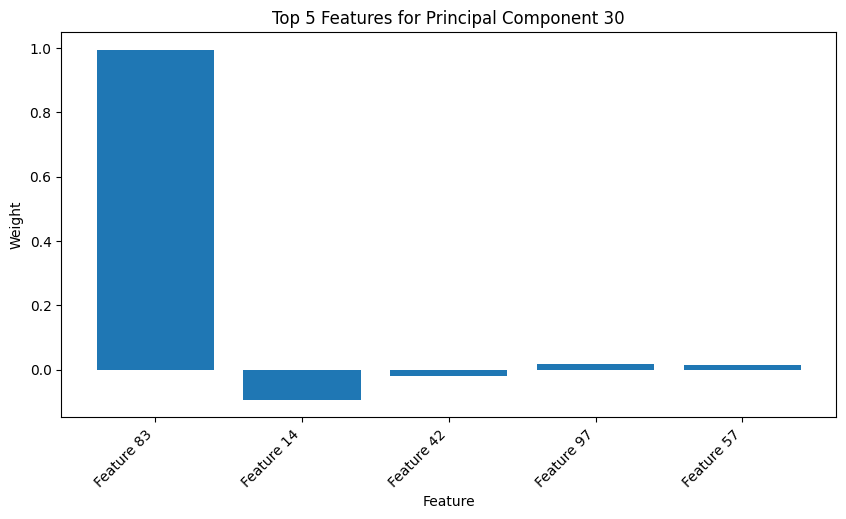

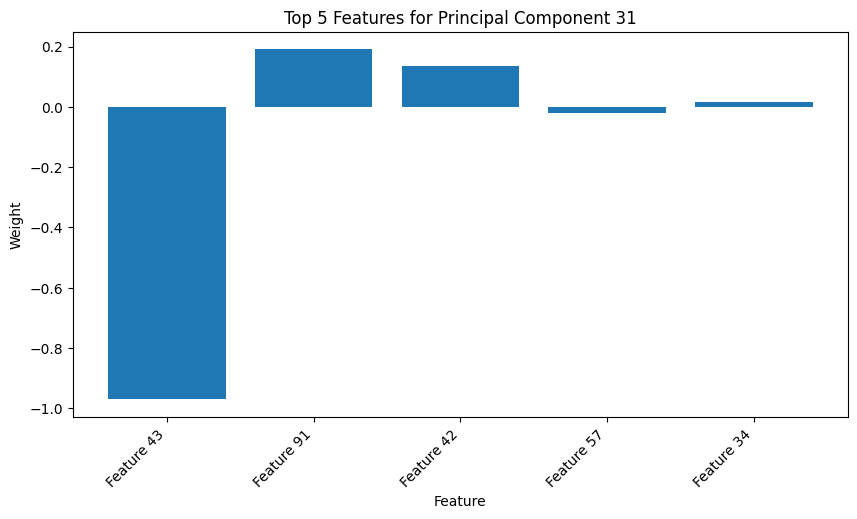

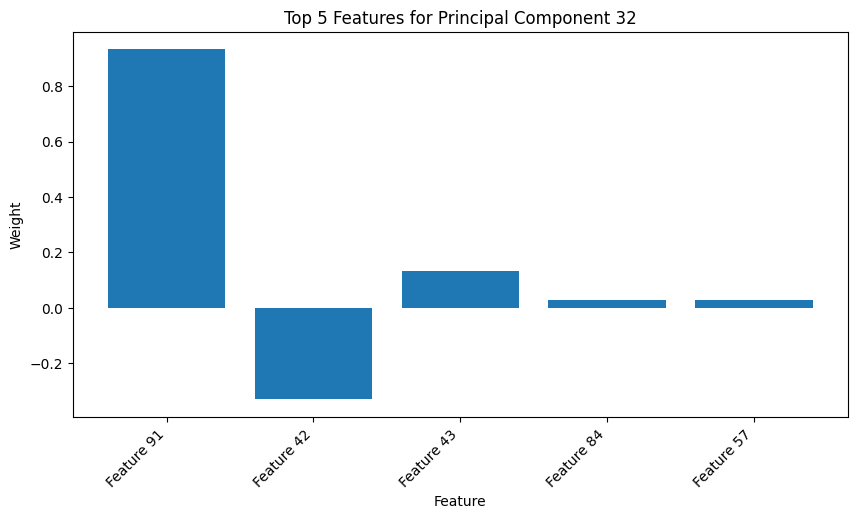

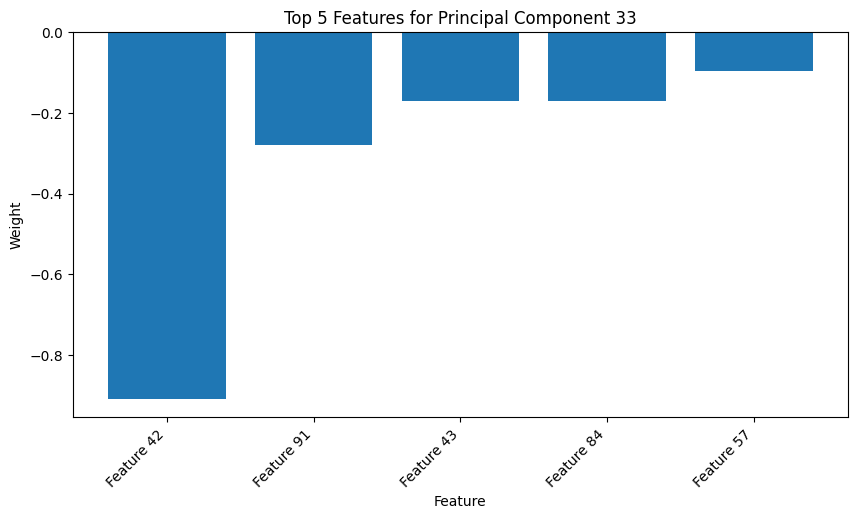

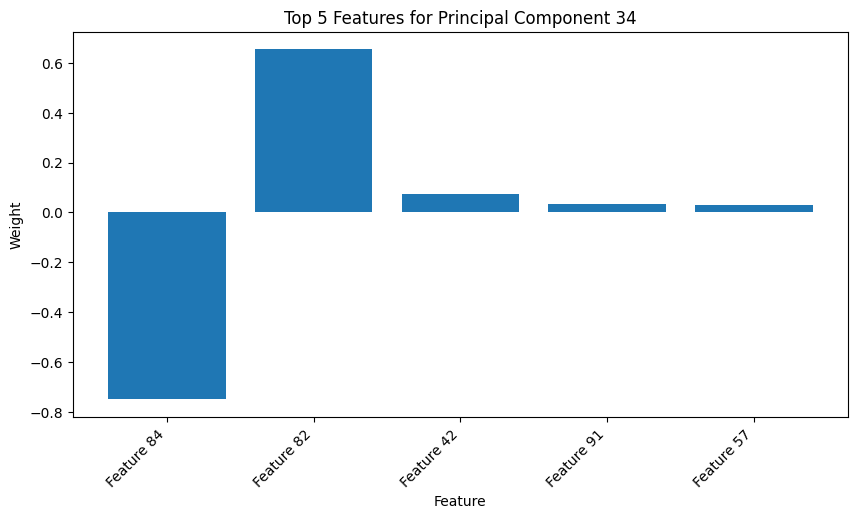

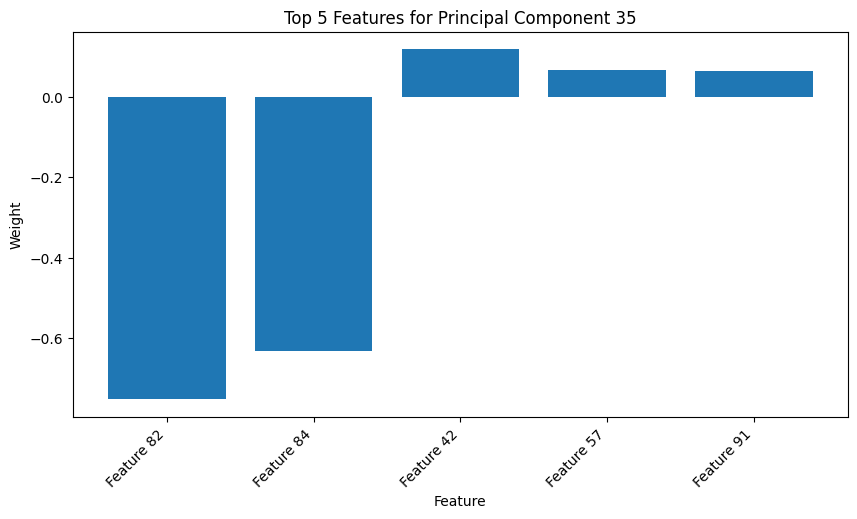

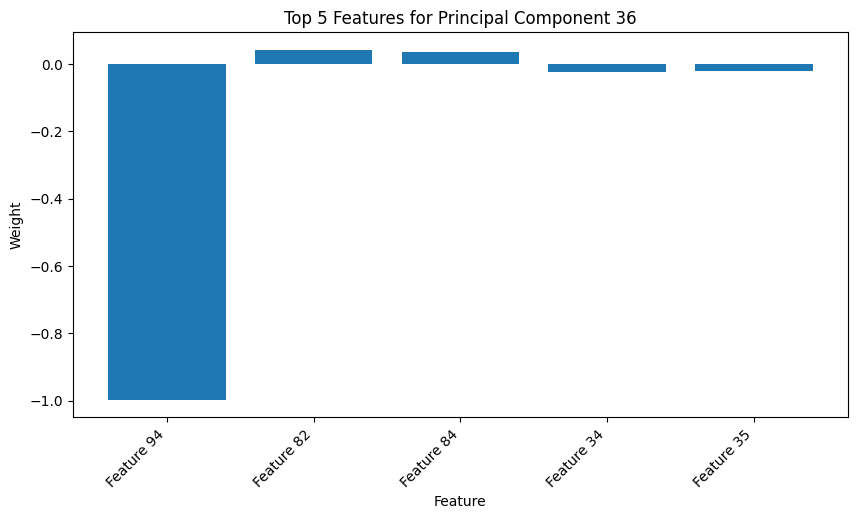

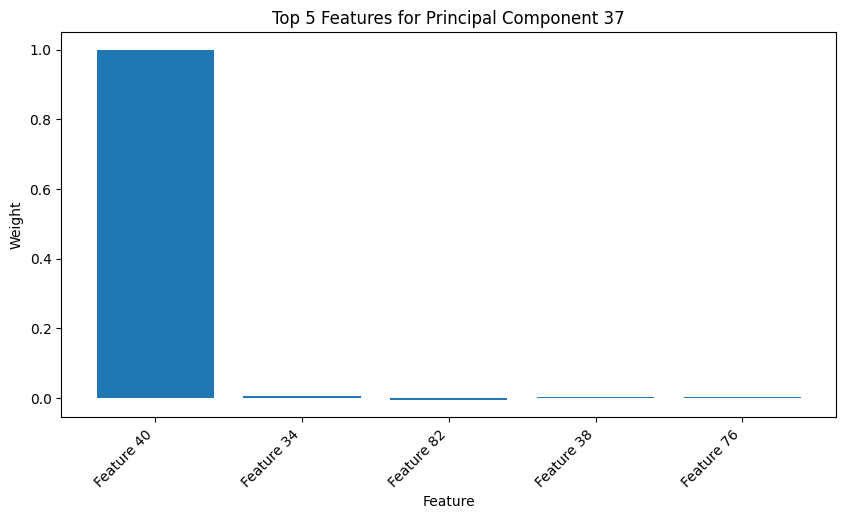

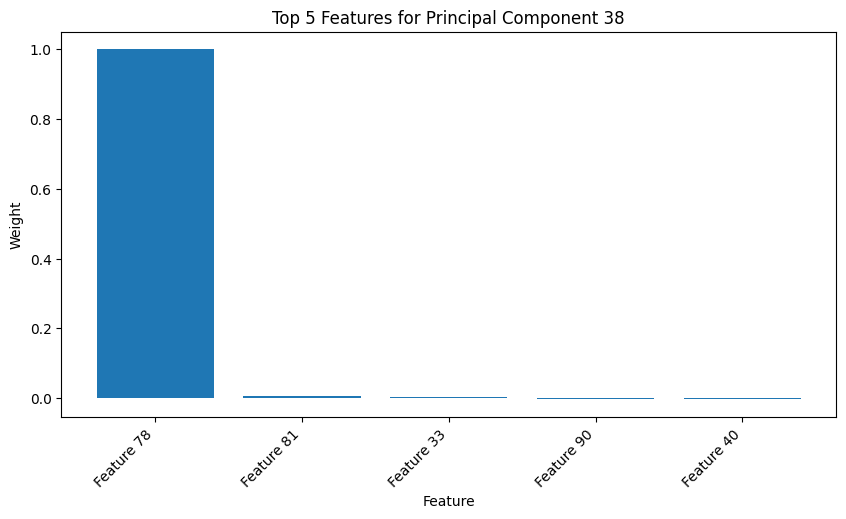

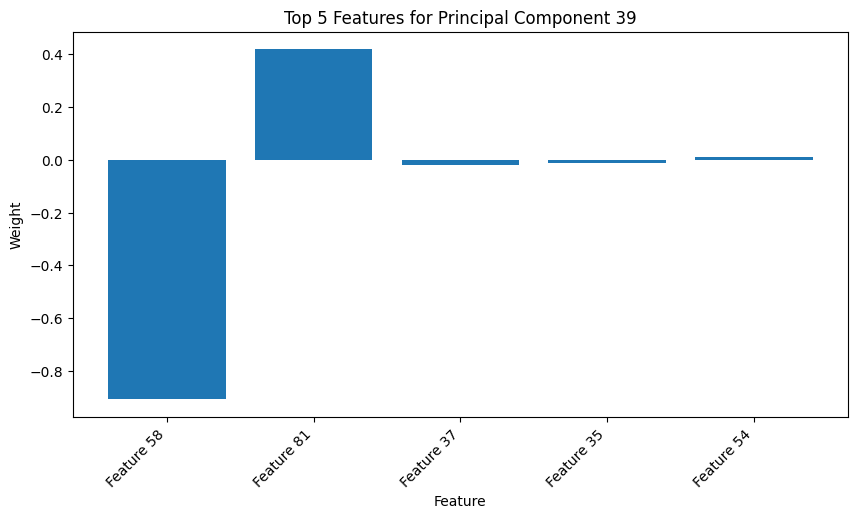

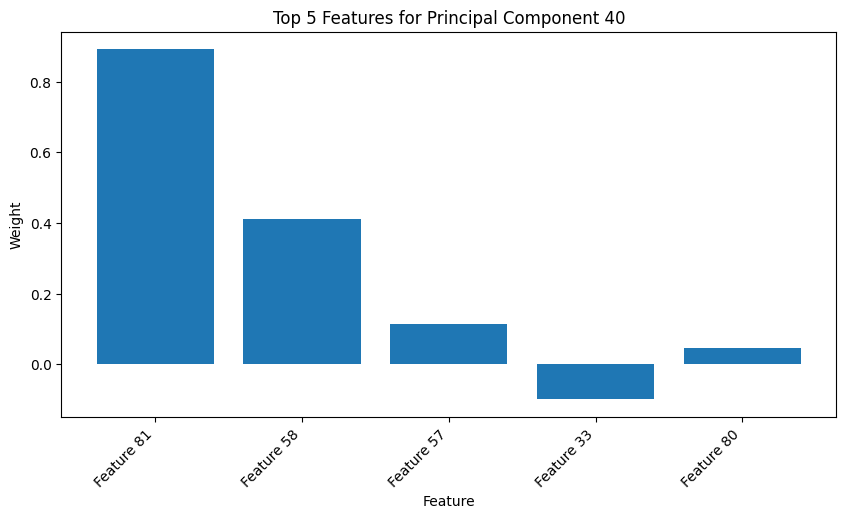

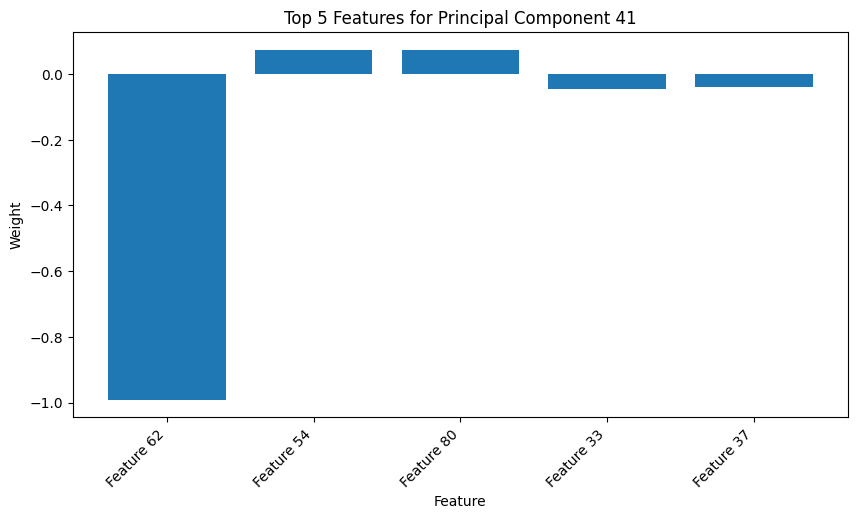

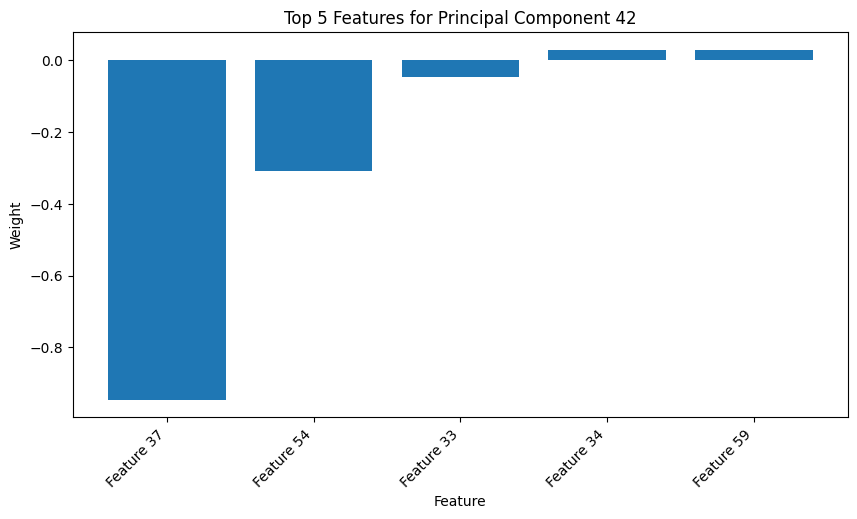

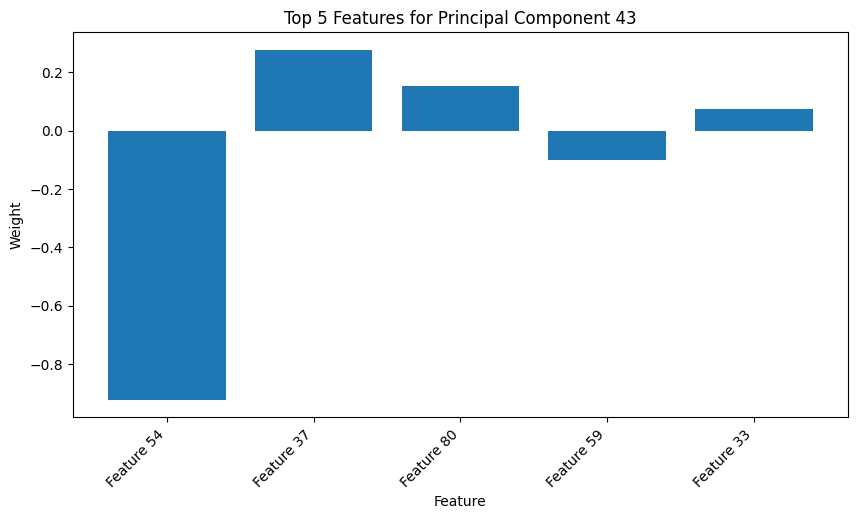

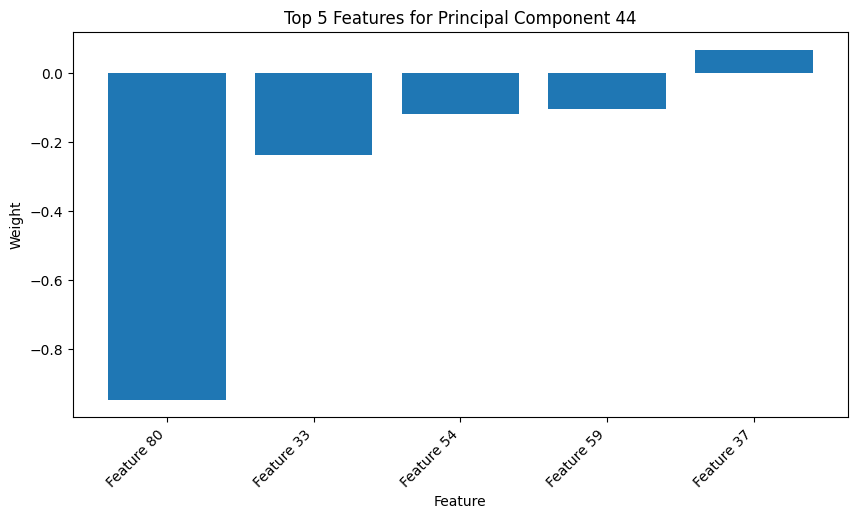

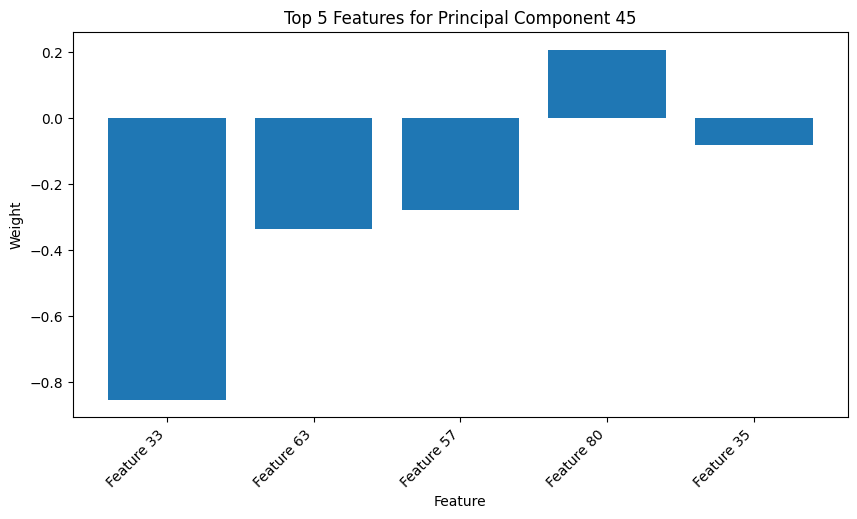

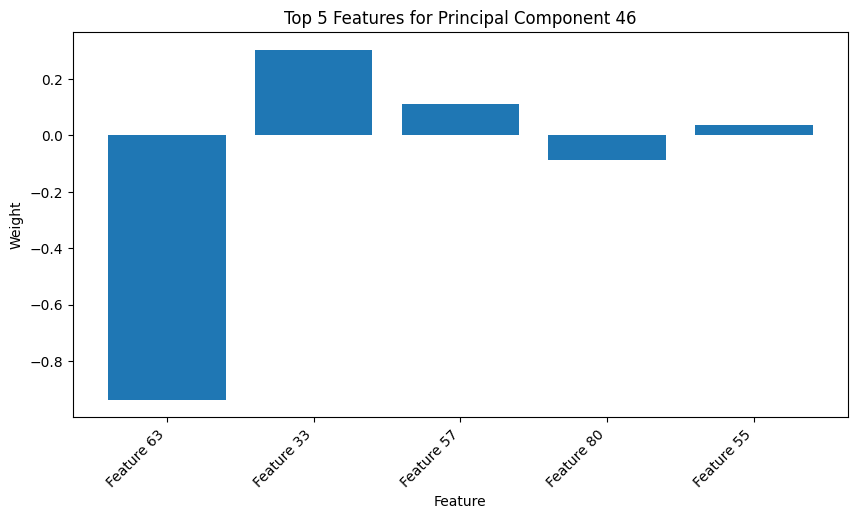

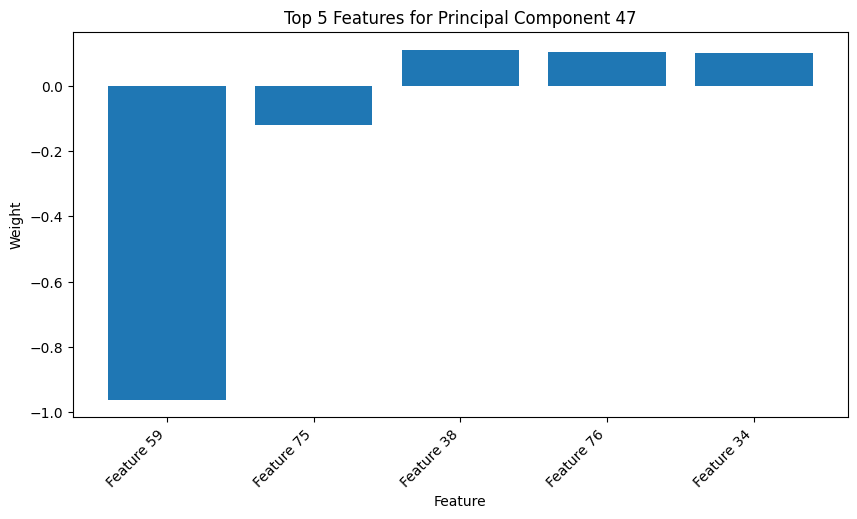

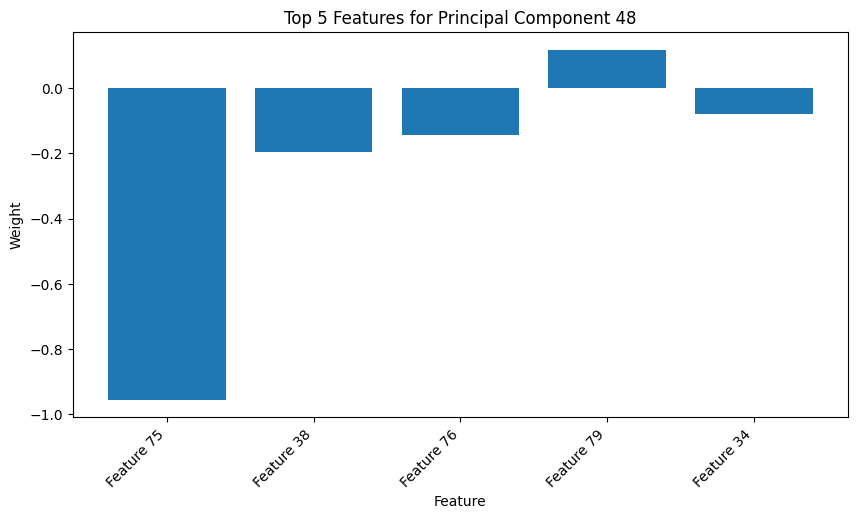

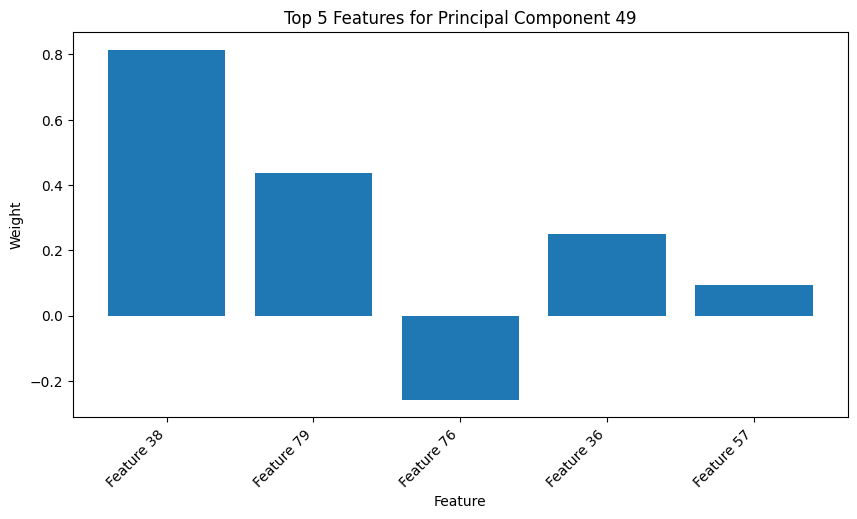

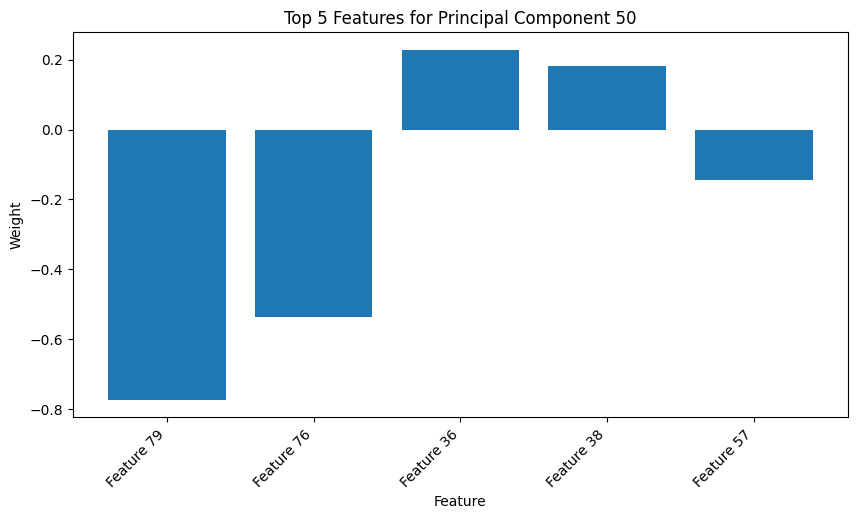

In [10]:
pca_train_ts = apply_pca(combined_train_ts)
train_reduced_dataset = generate_reduced_dataset(pca_train_ts,train_labels)

(6000, 1000, 105)


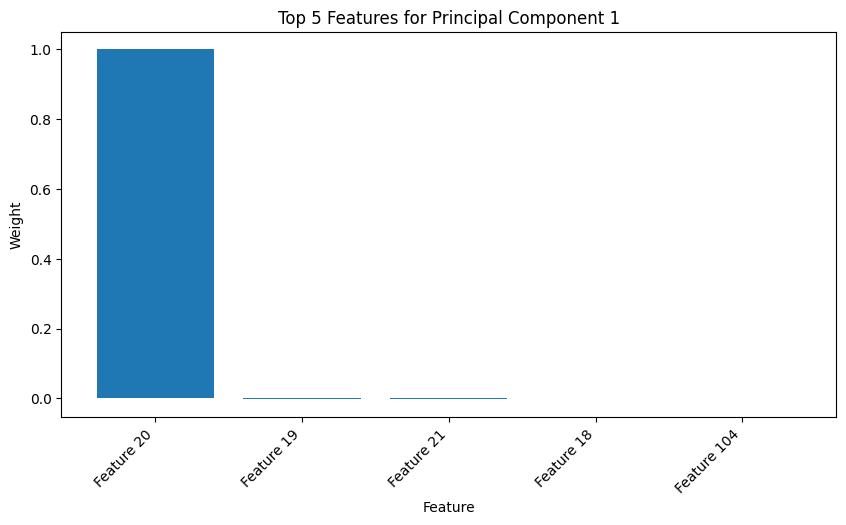

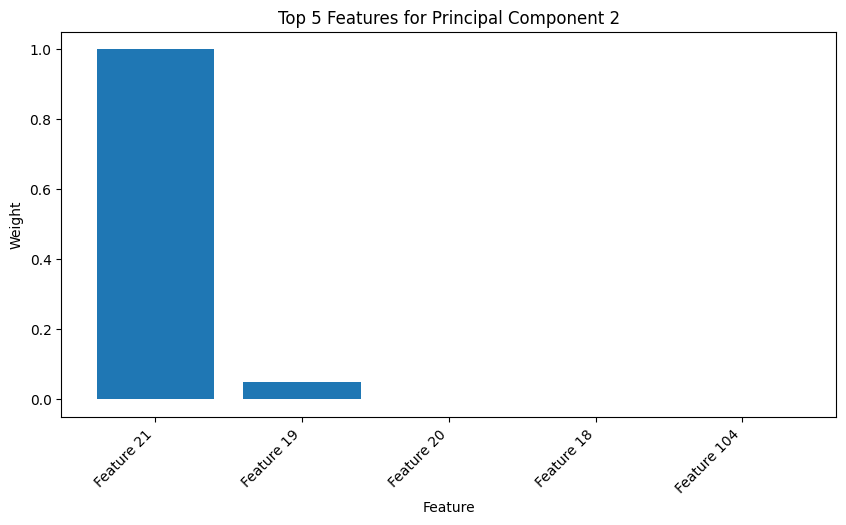

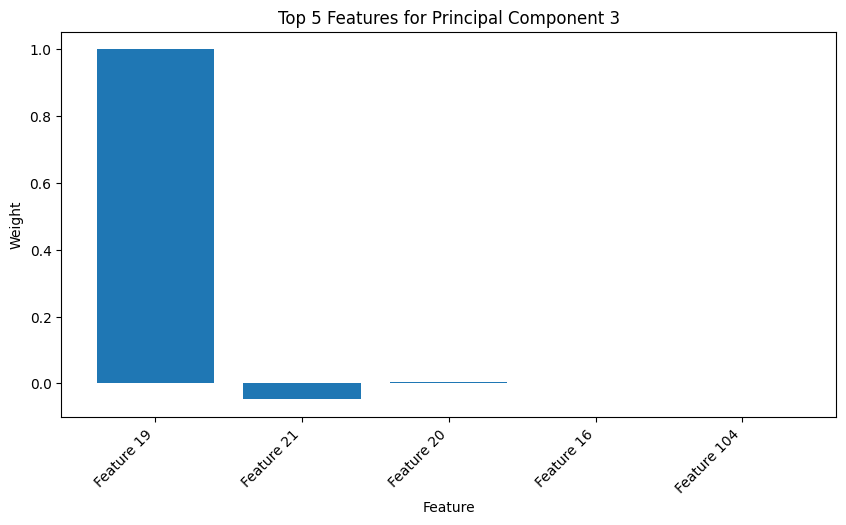

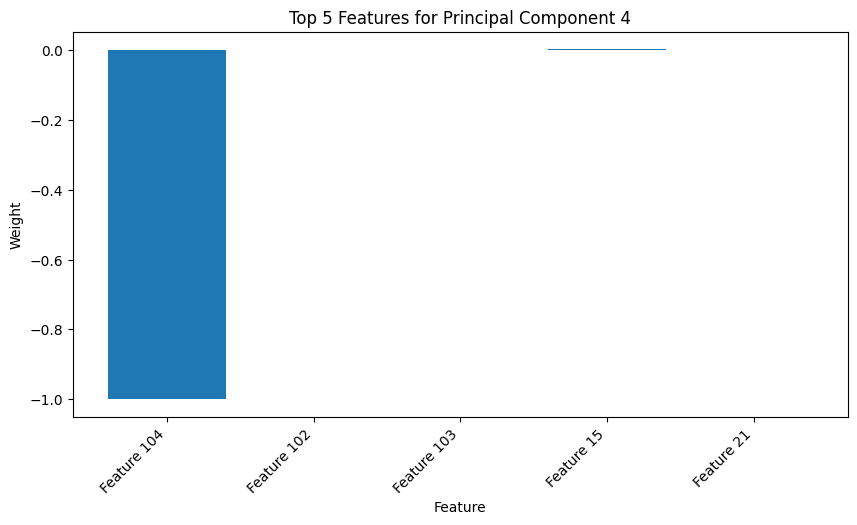

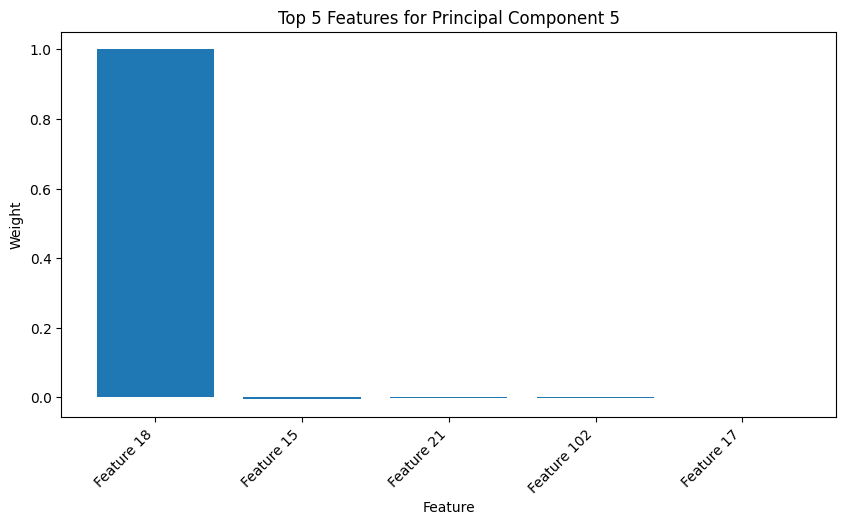

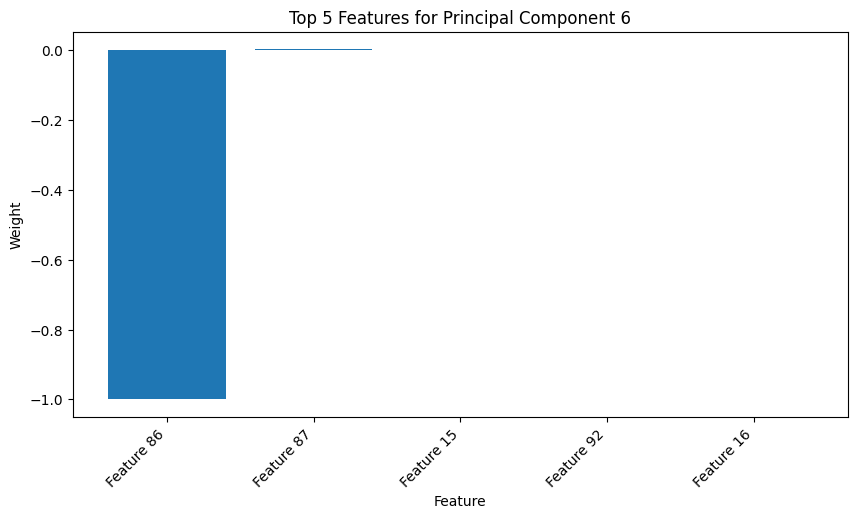

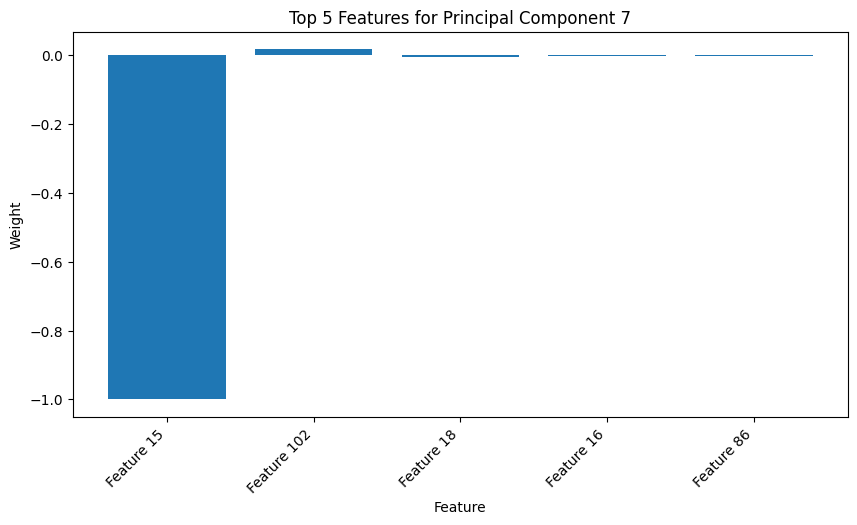

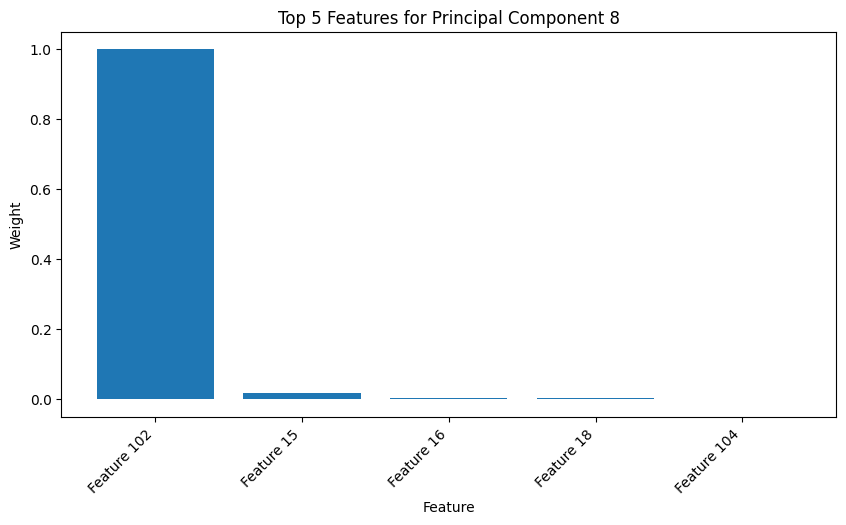

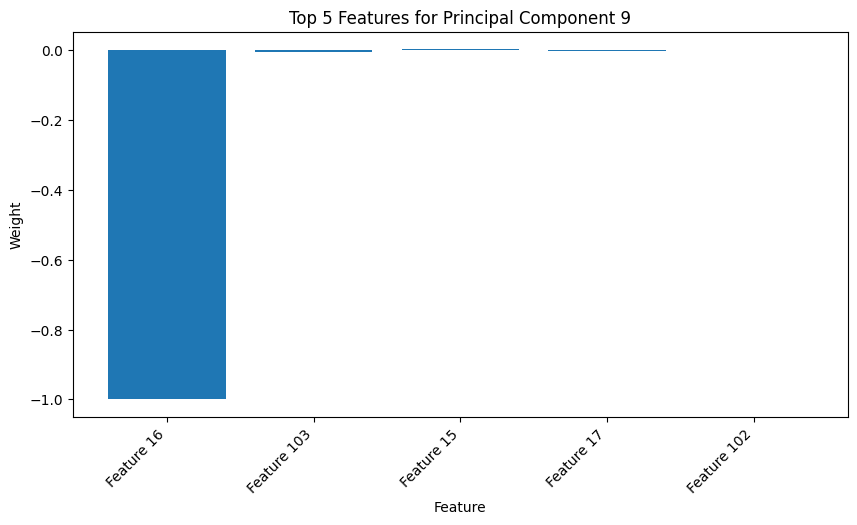

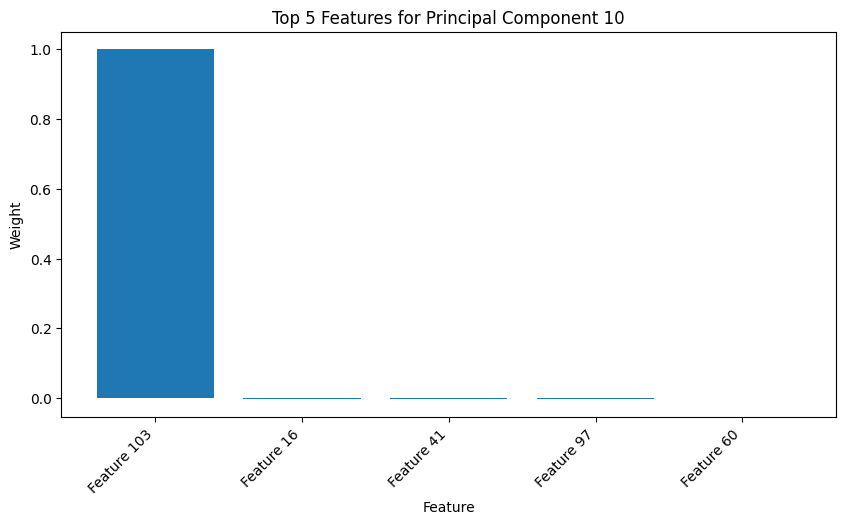

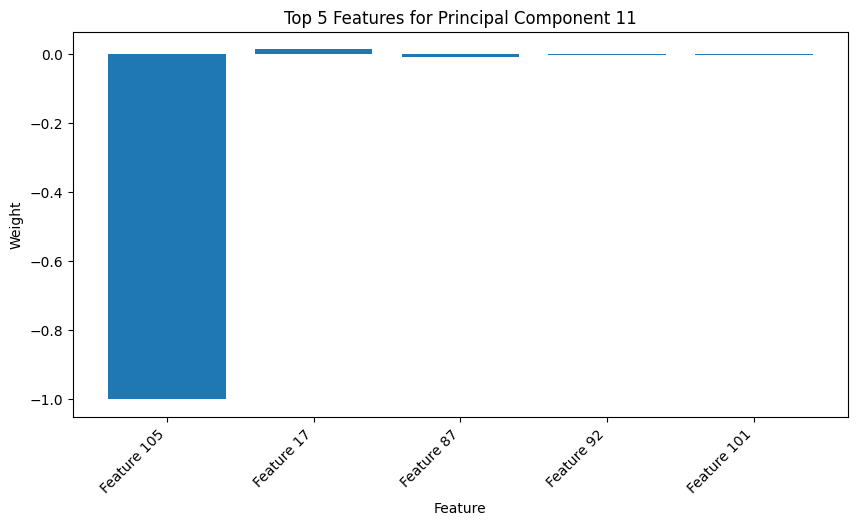

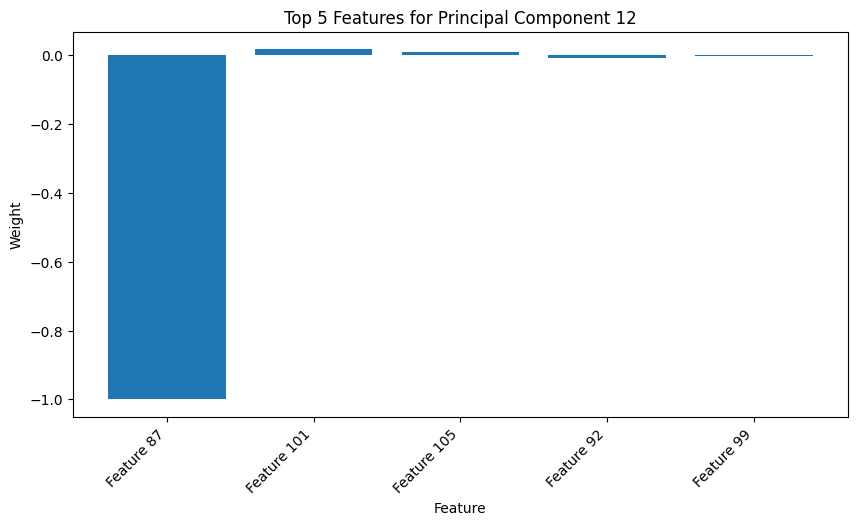

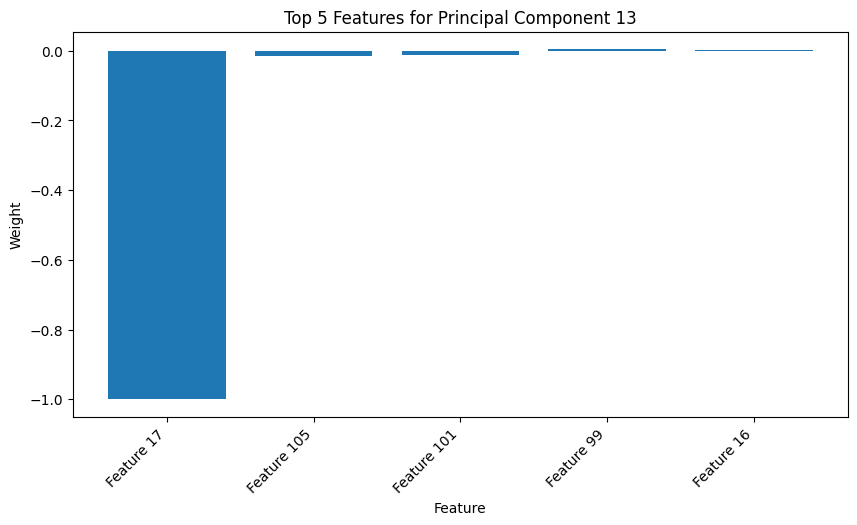

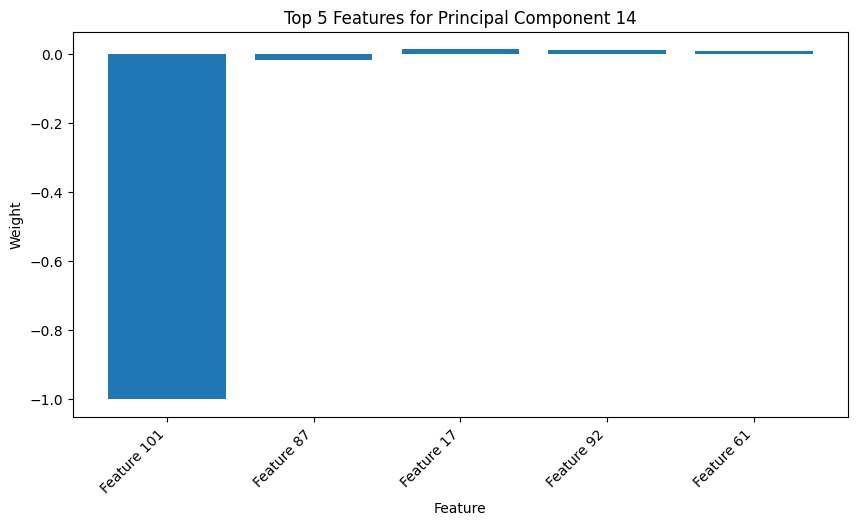

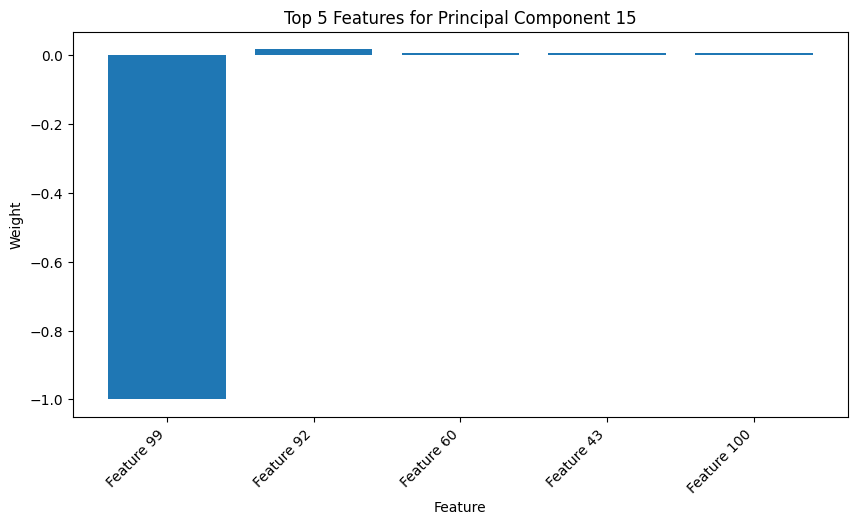

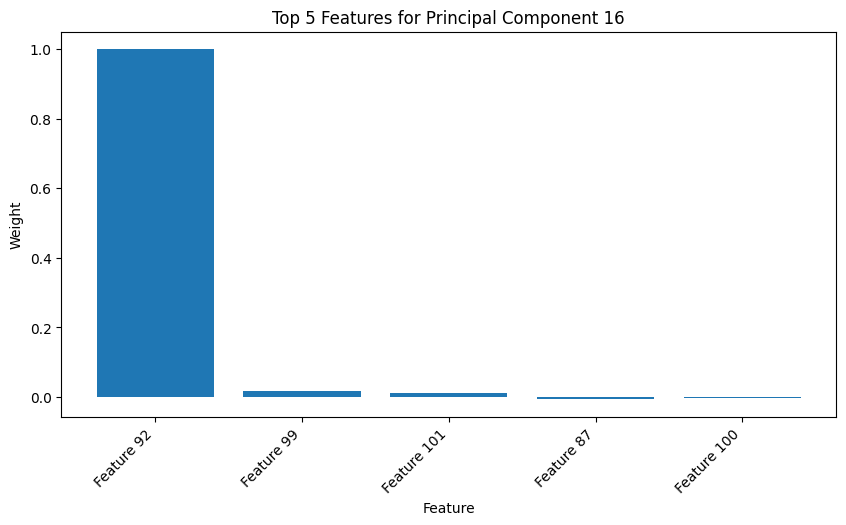

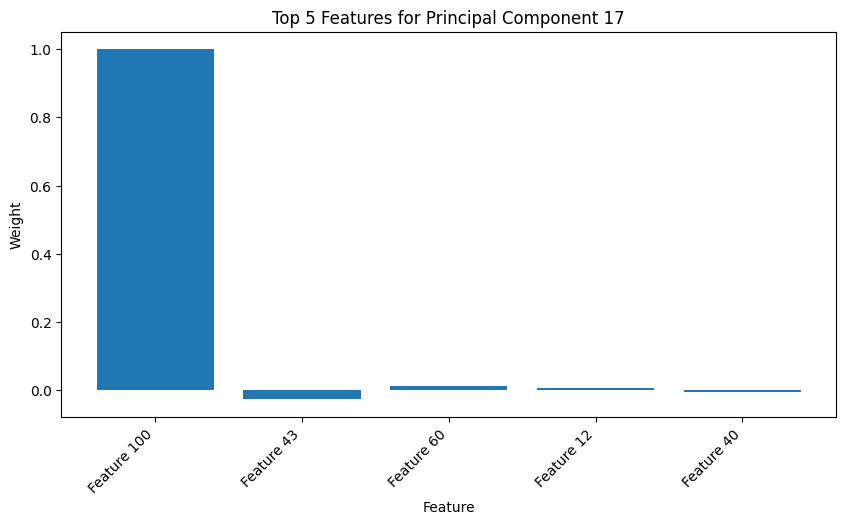

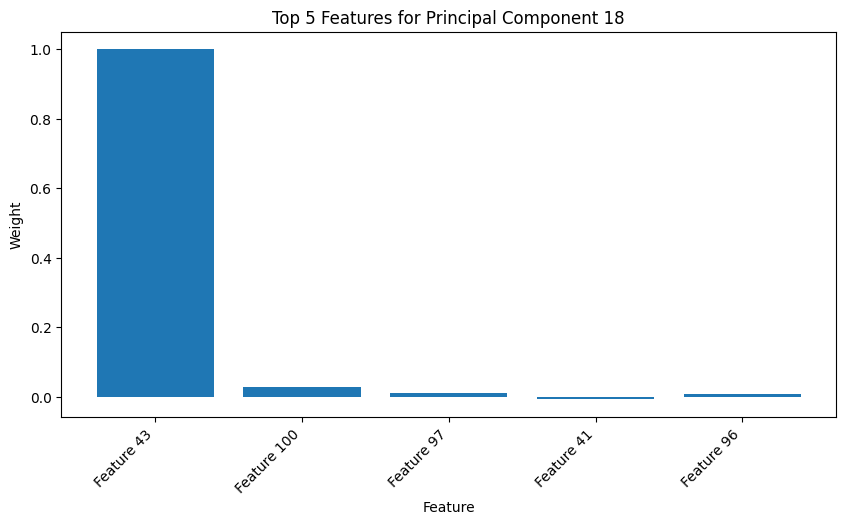

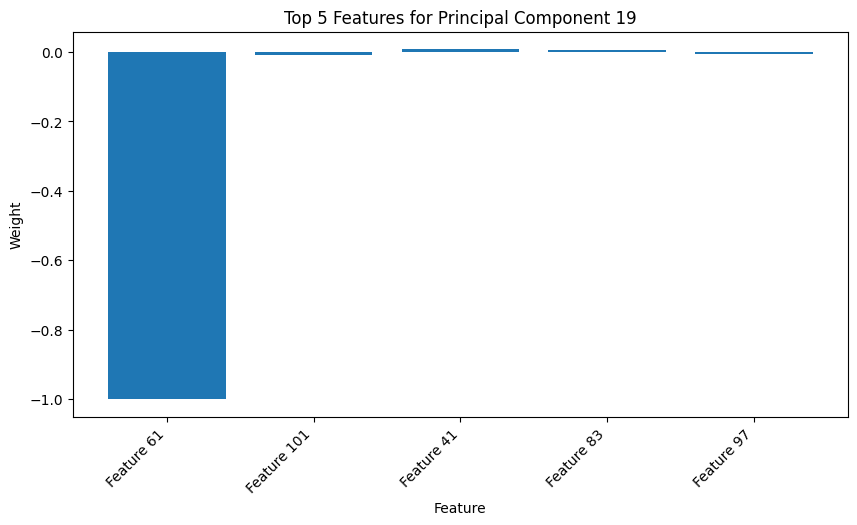

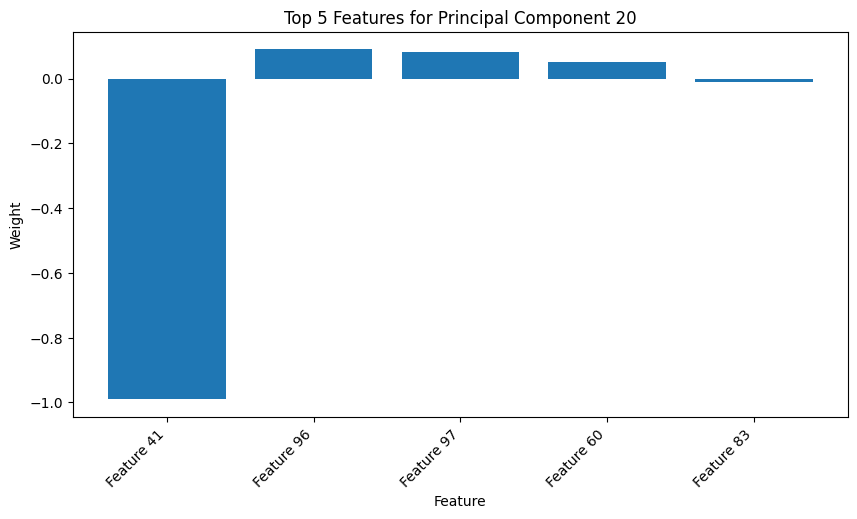

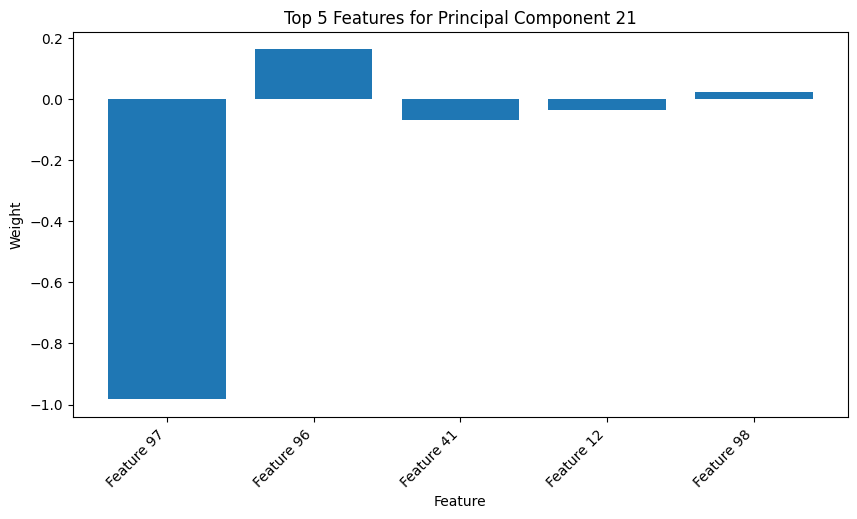

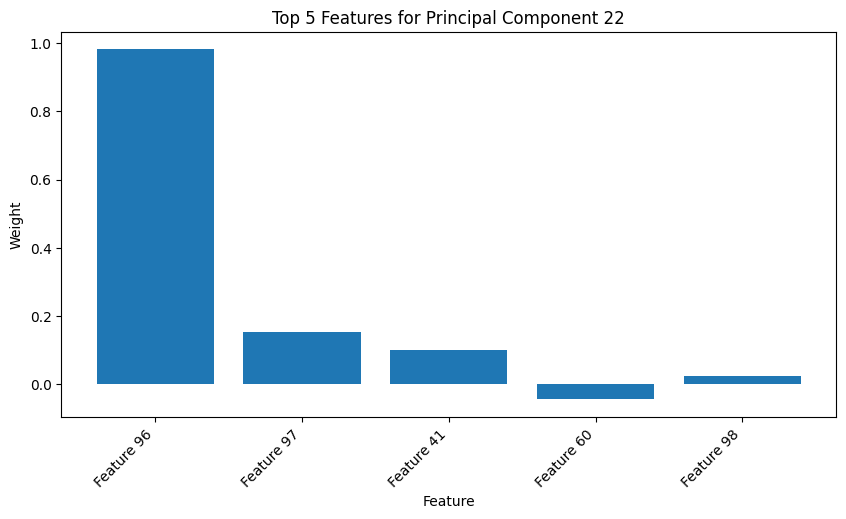

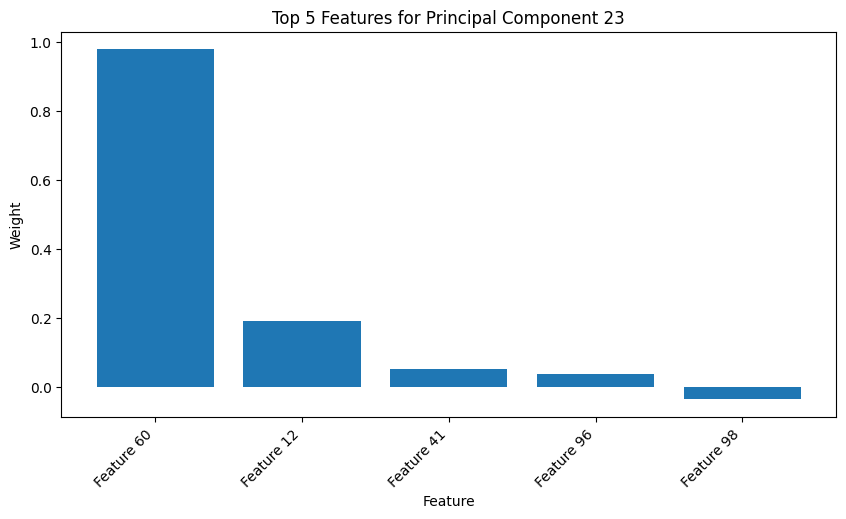

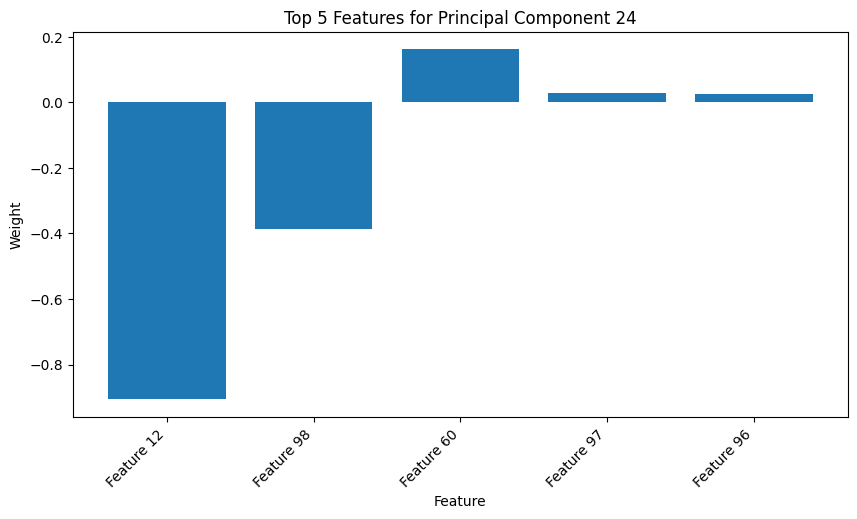

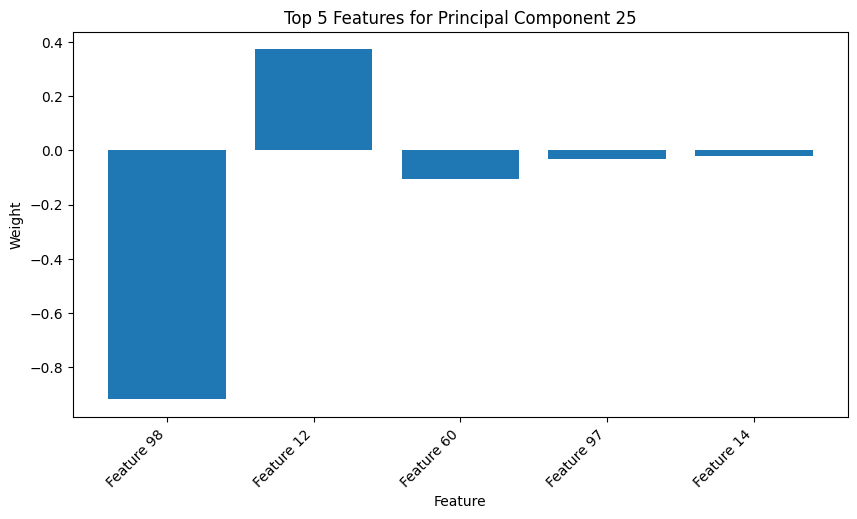

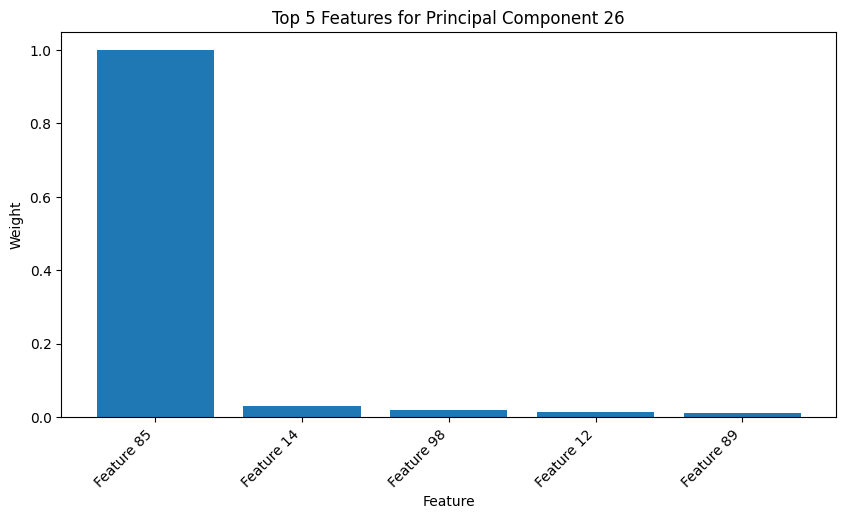

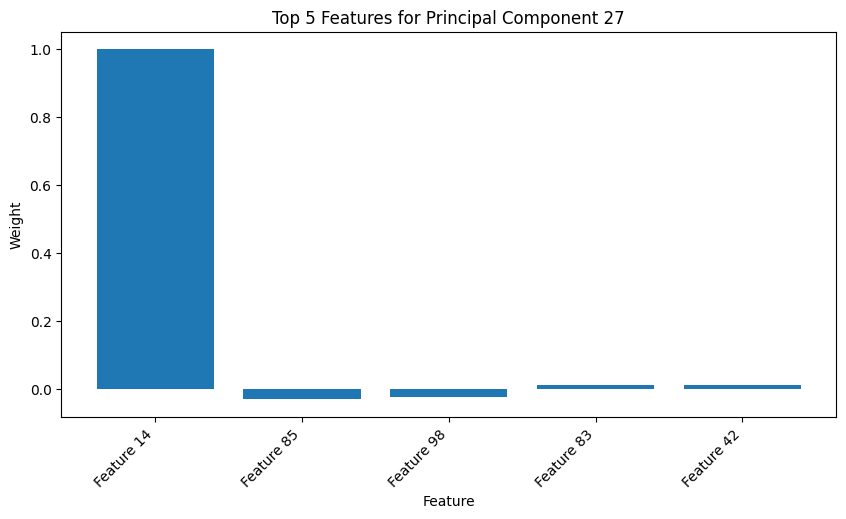

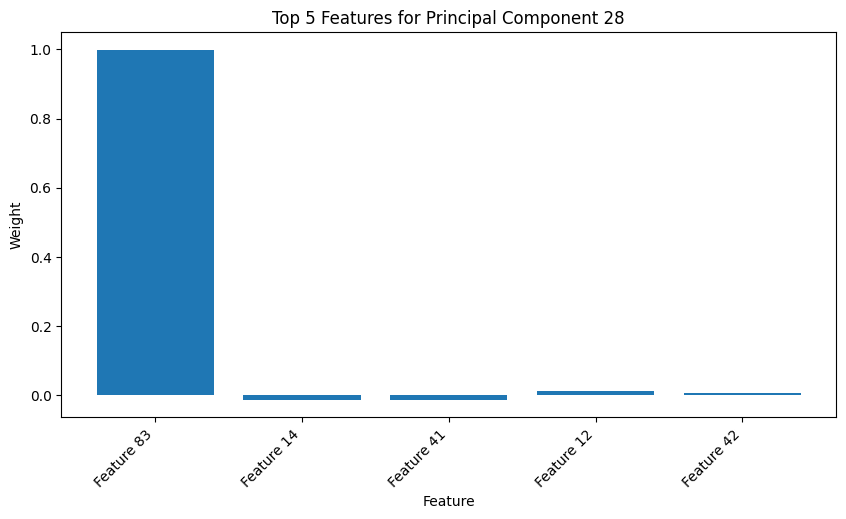

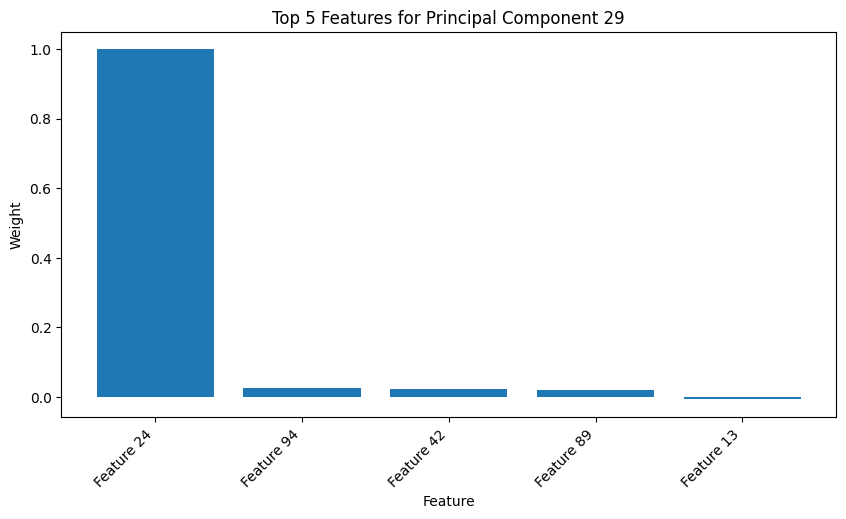

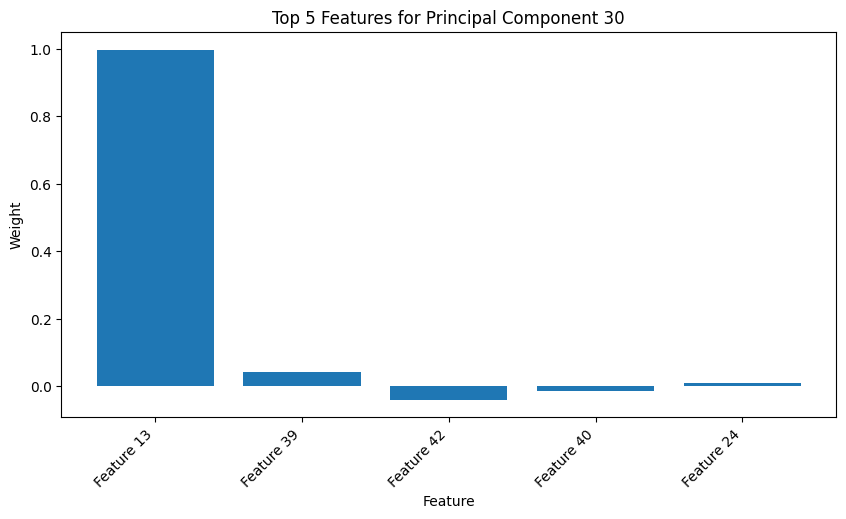

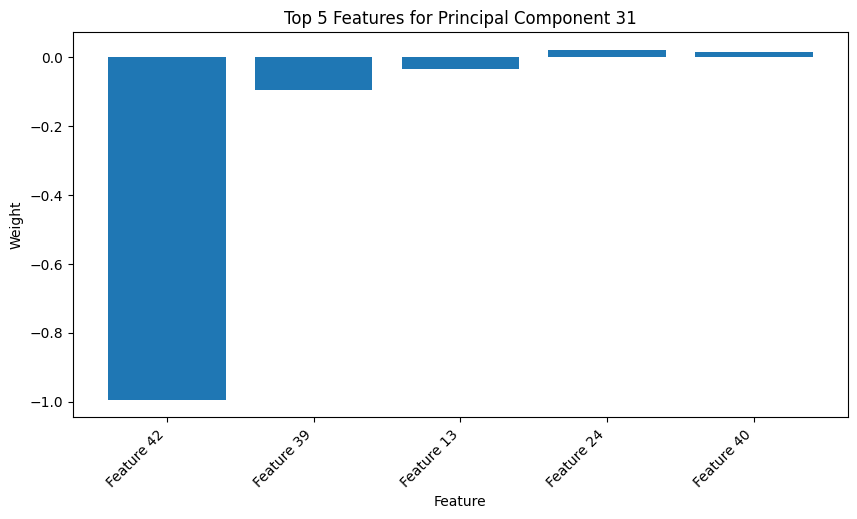

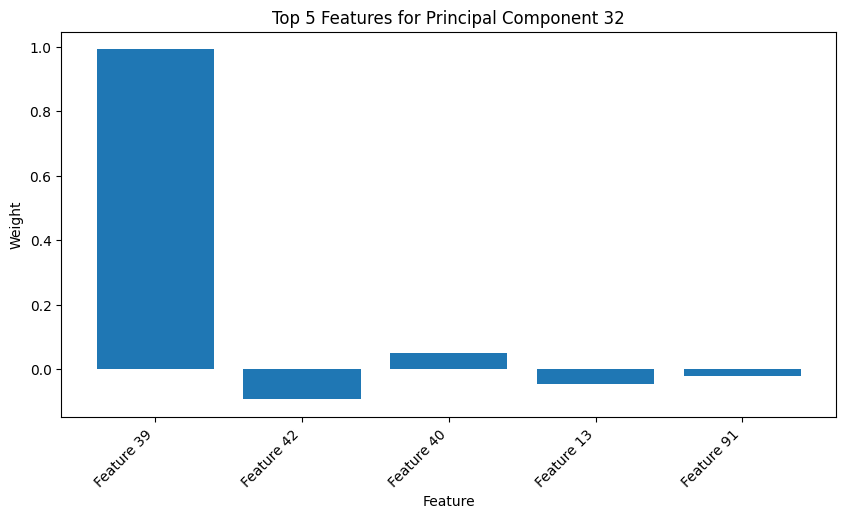

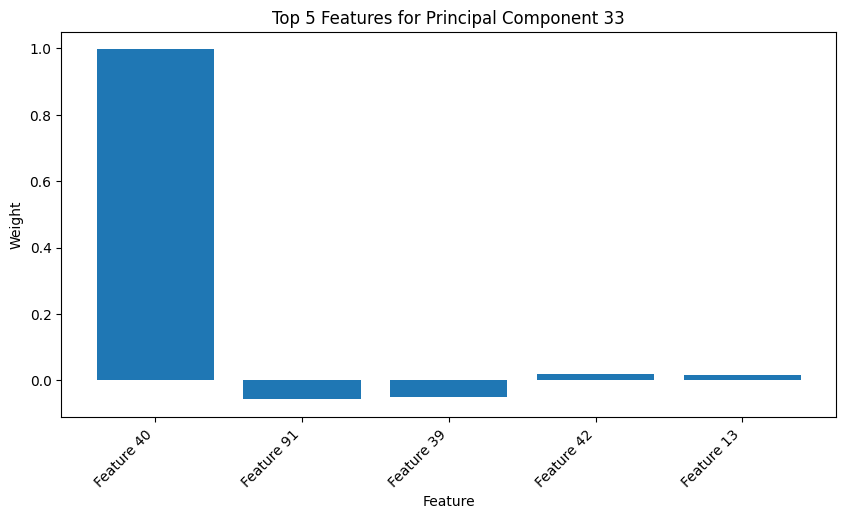

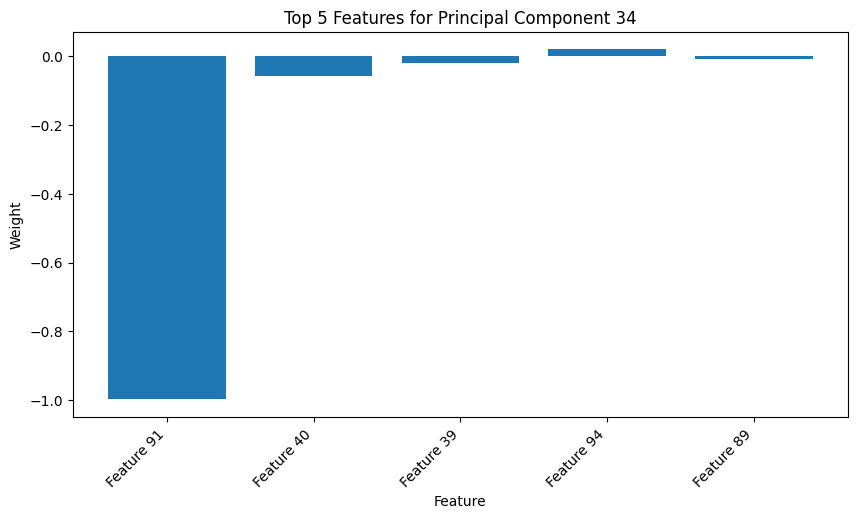

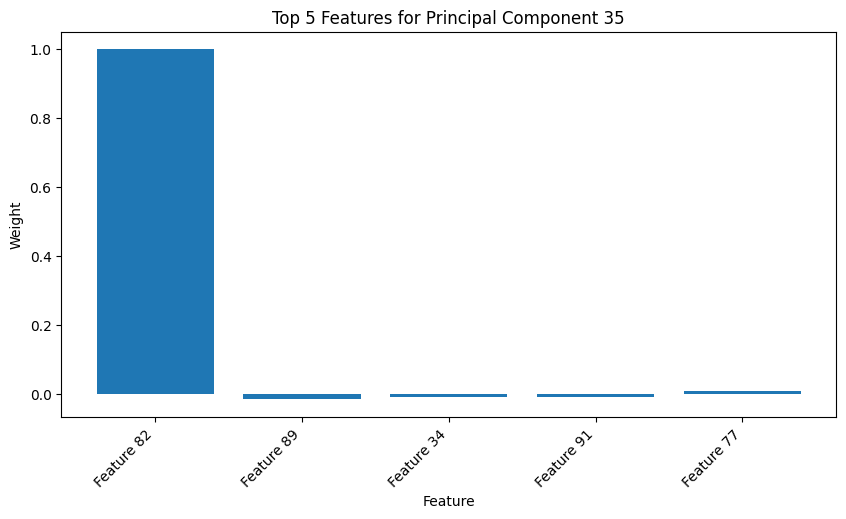

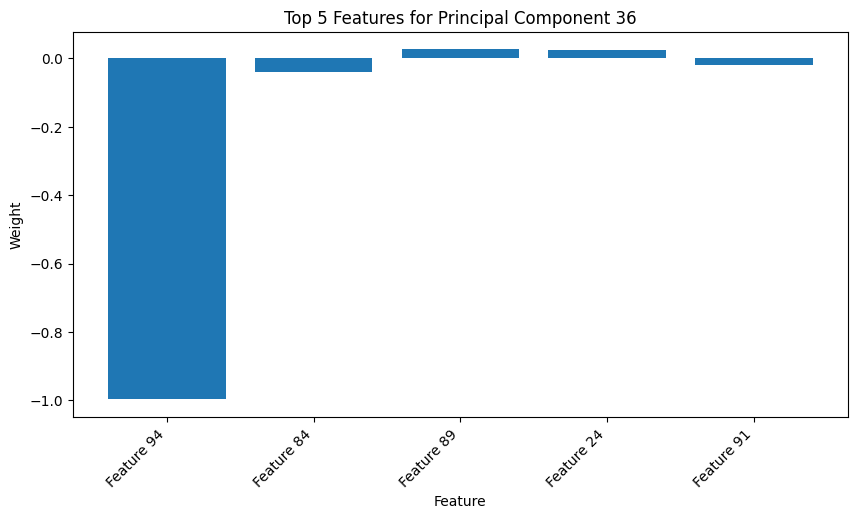

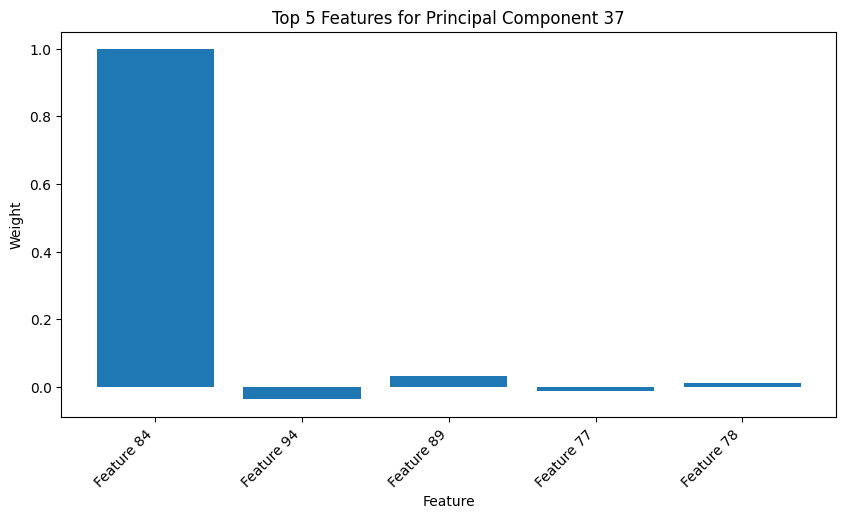

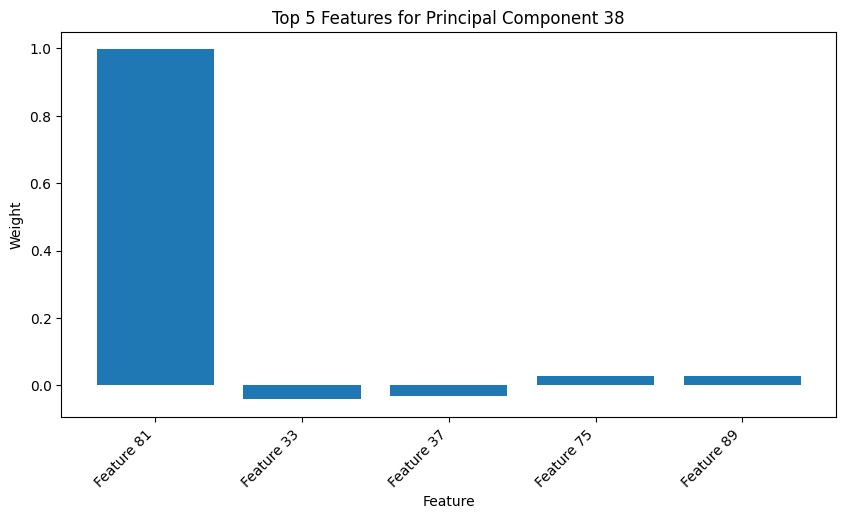

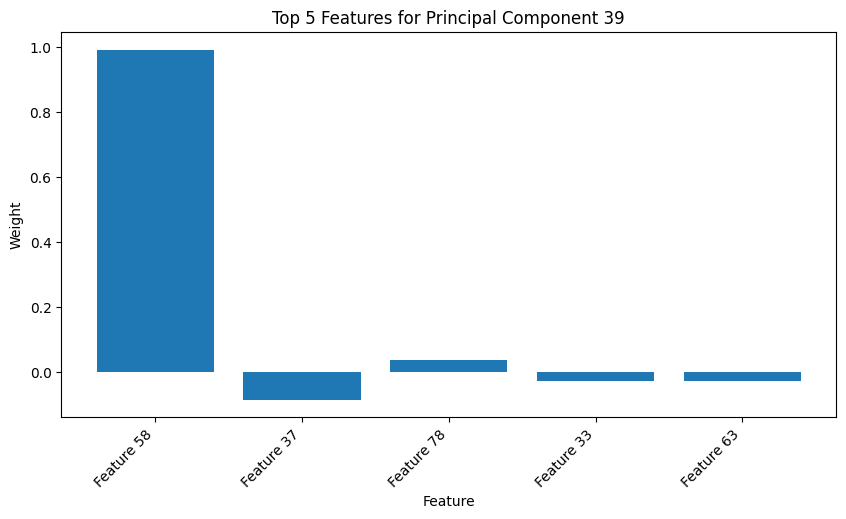

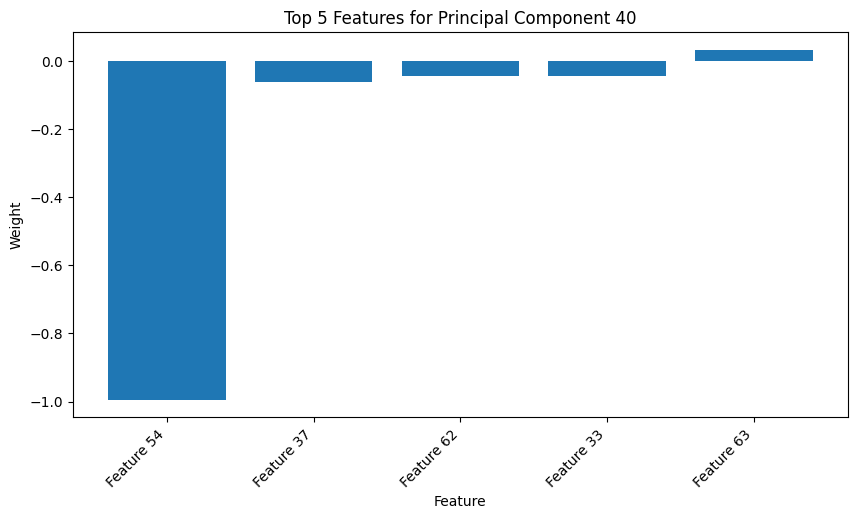

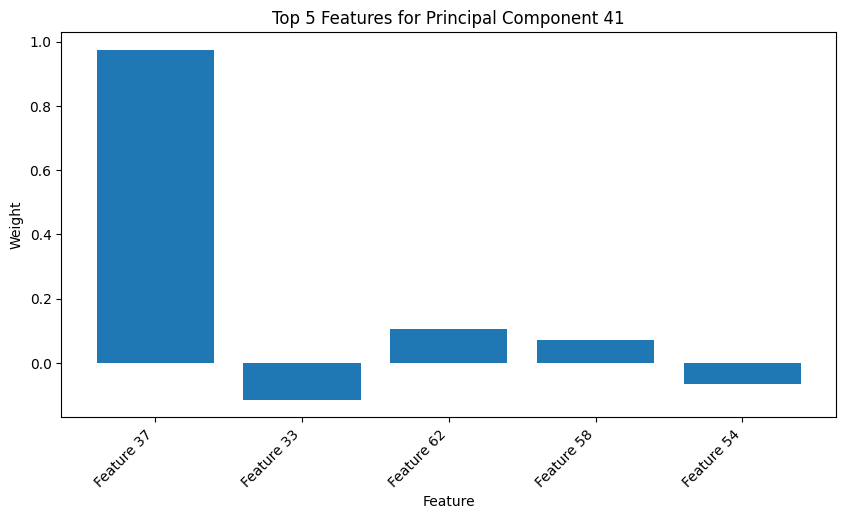

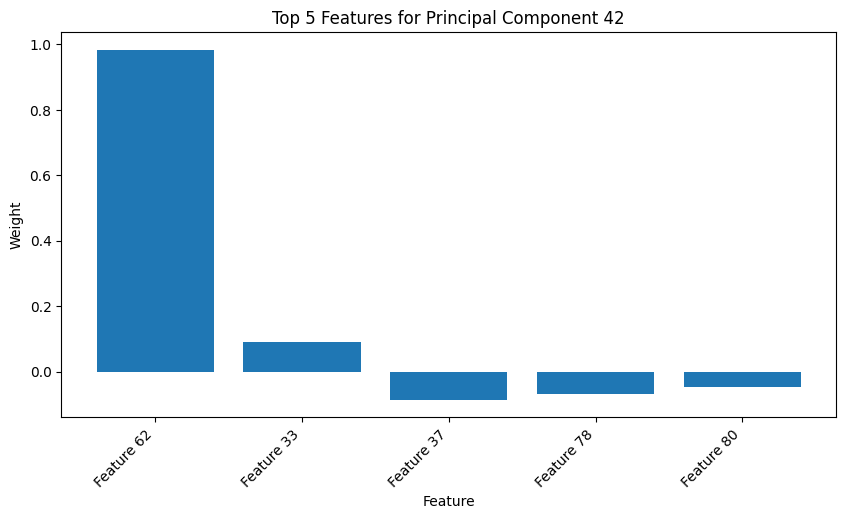

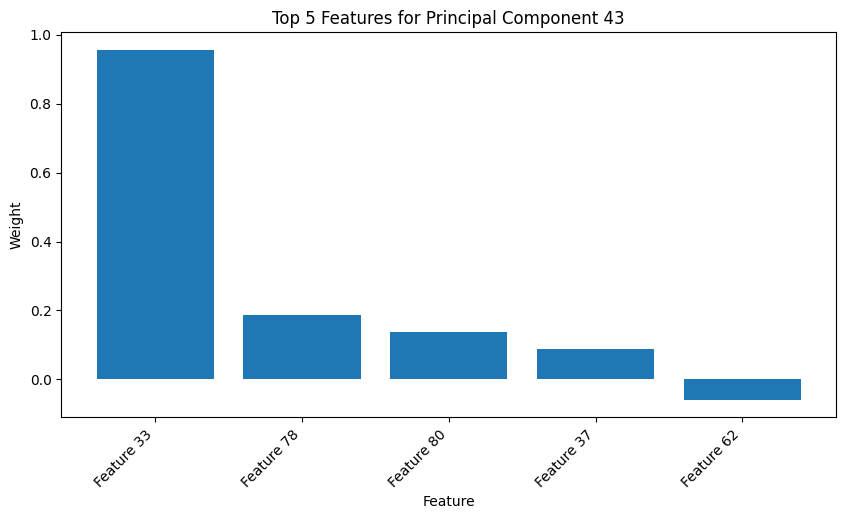

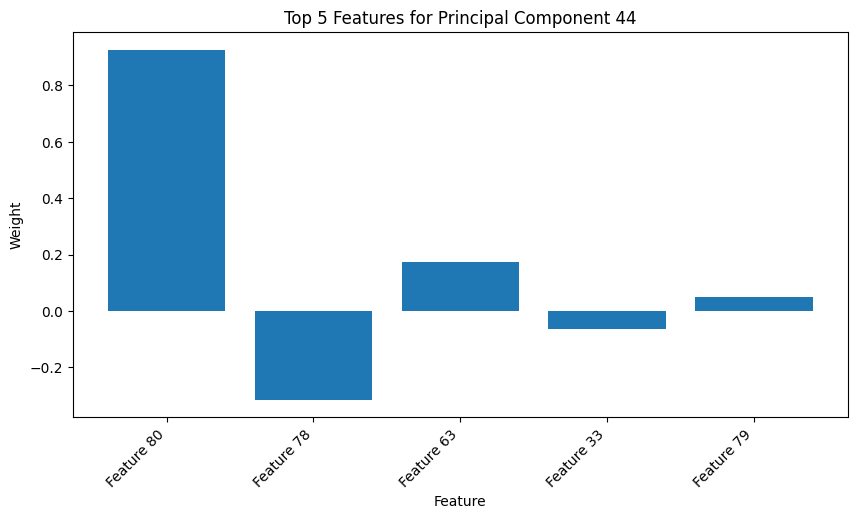

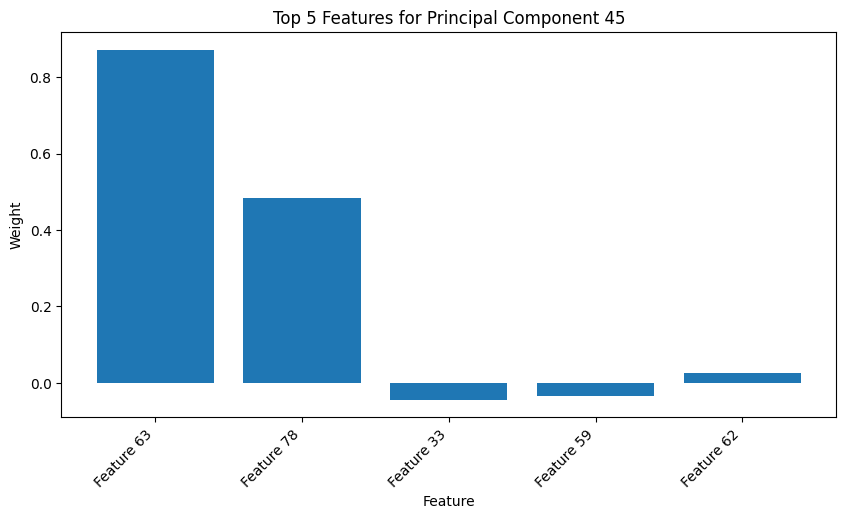

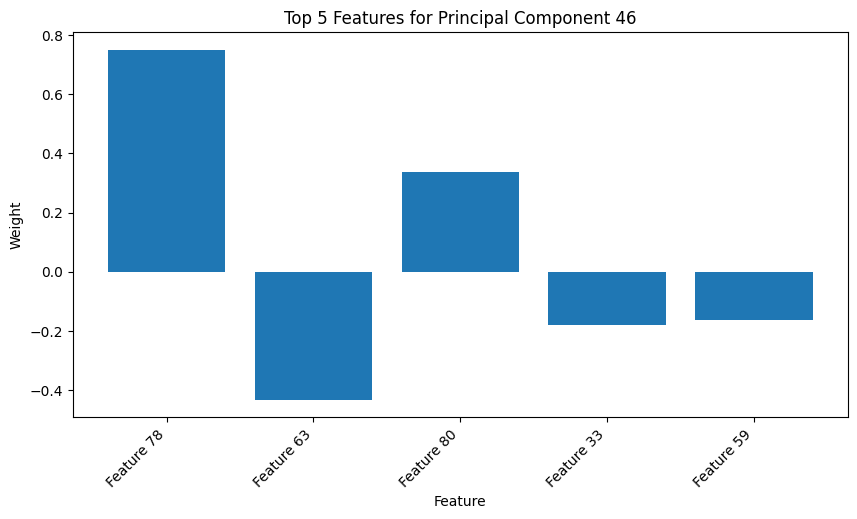

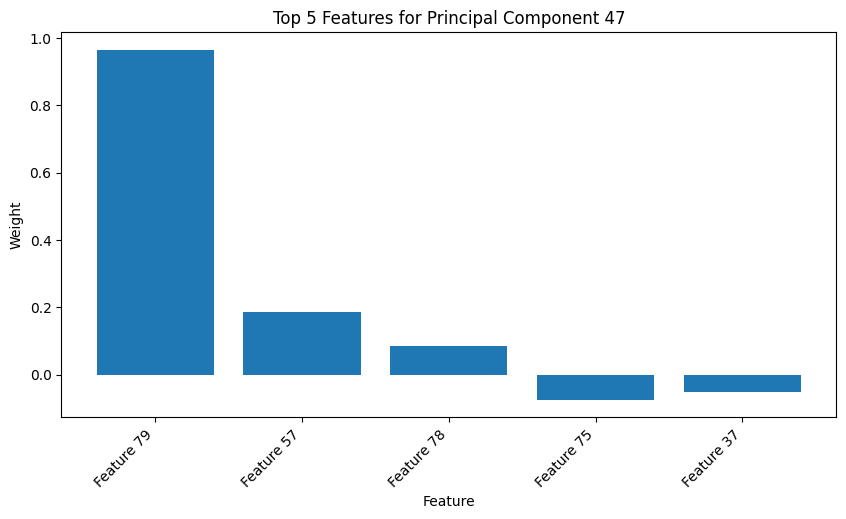

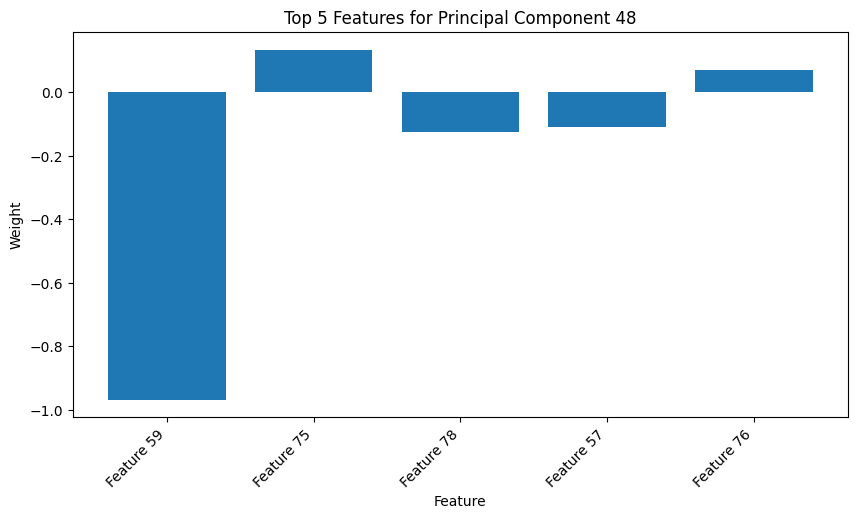

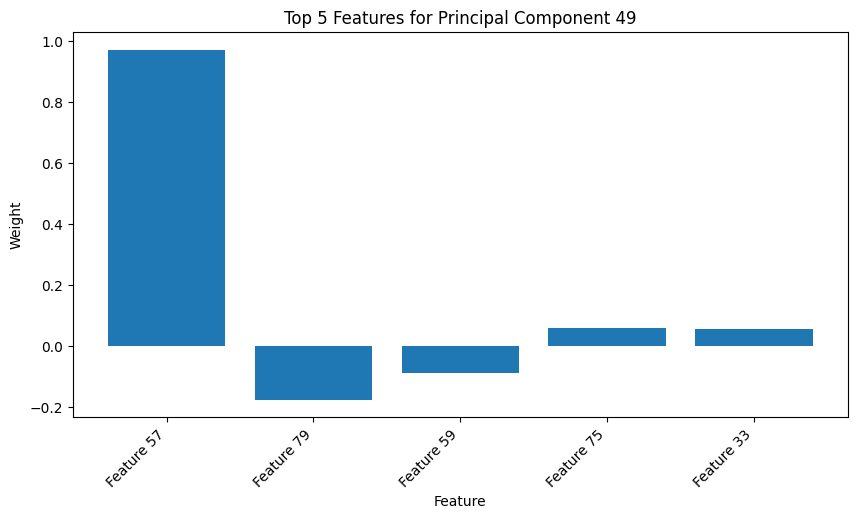

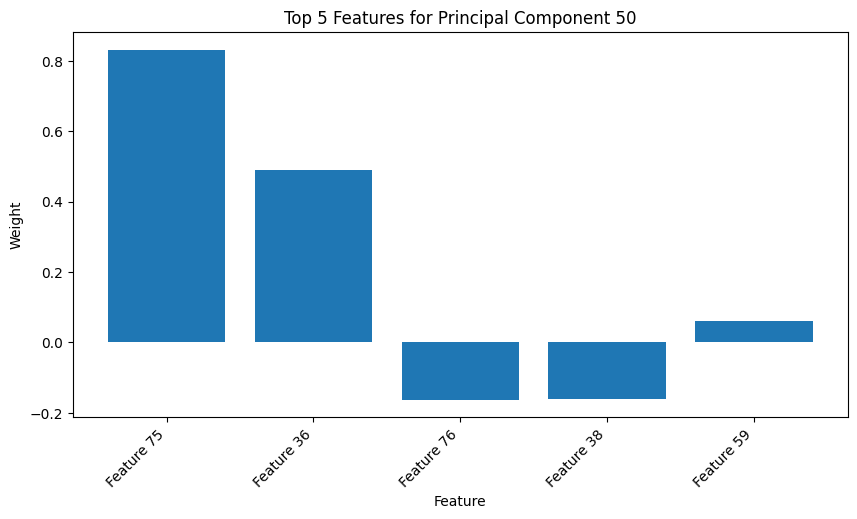

In [11]:
pca_test_ts = apply_pca(combined_test_ts)
test_reduced_dataset = generate_reduced_dataset(pca_test_ts,test_labels)

(6000, 1000, 105)


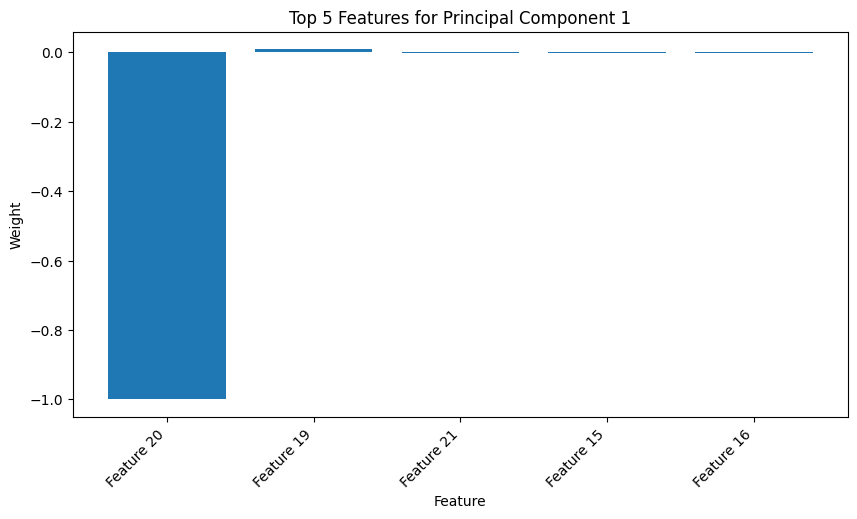

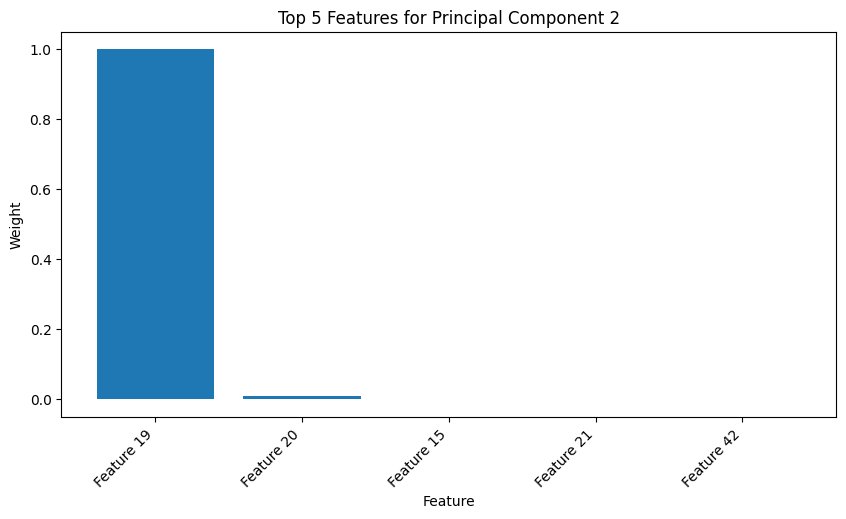

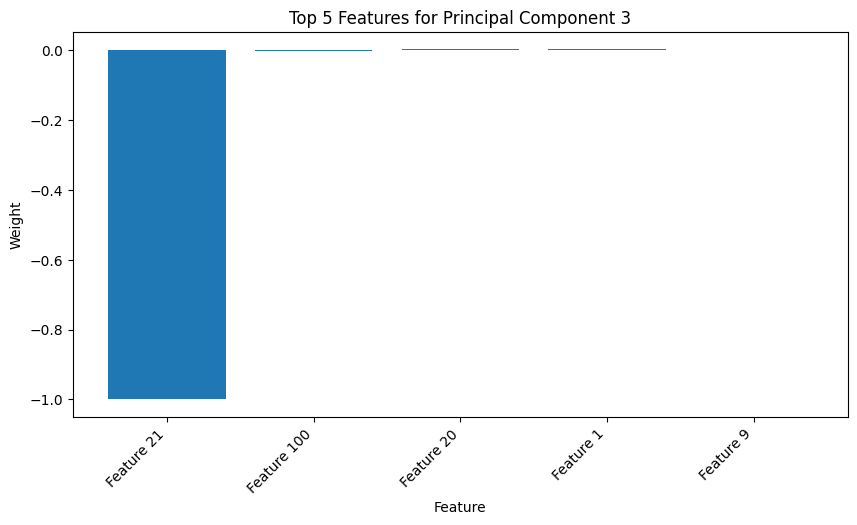

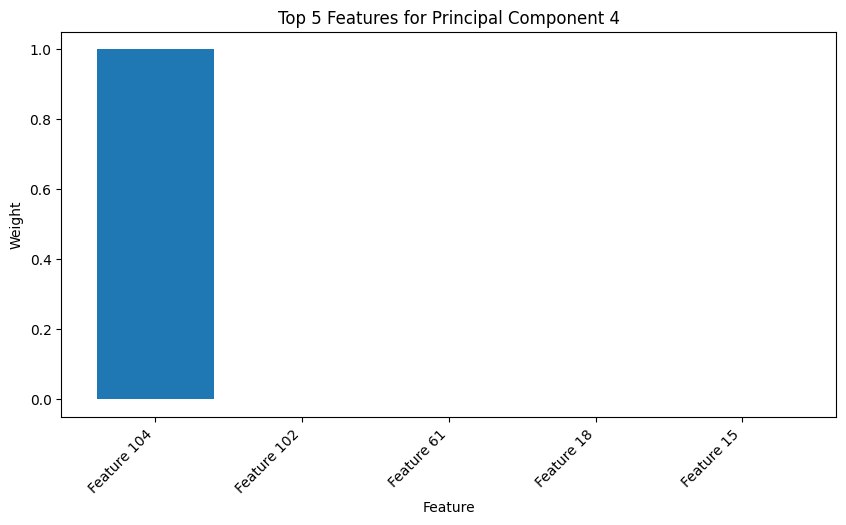

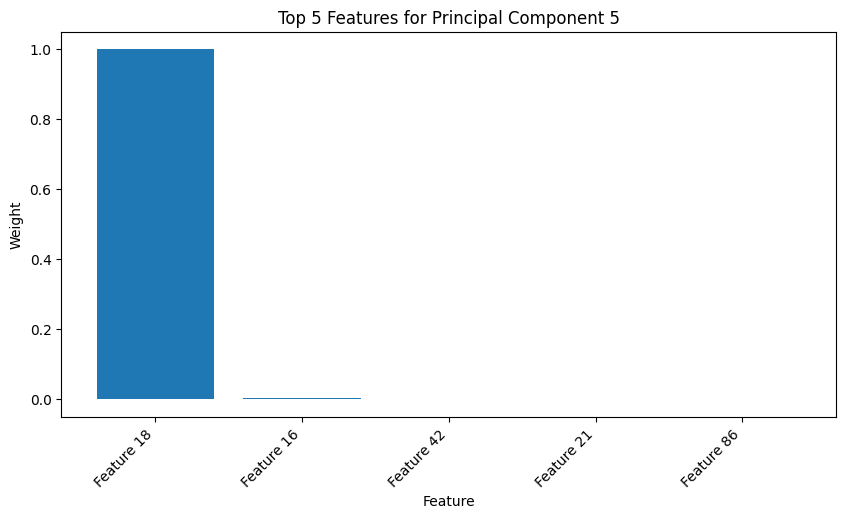

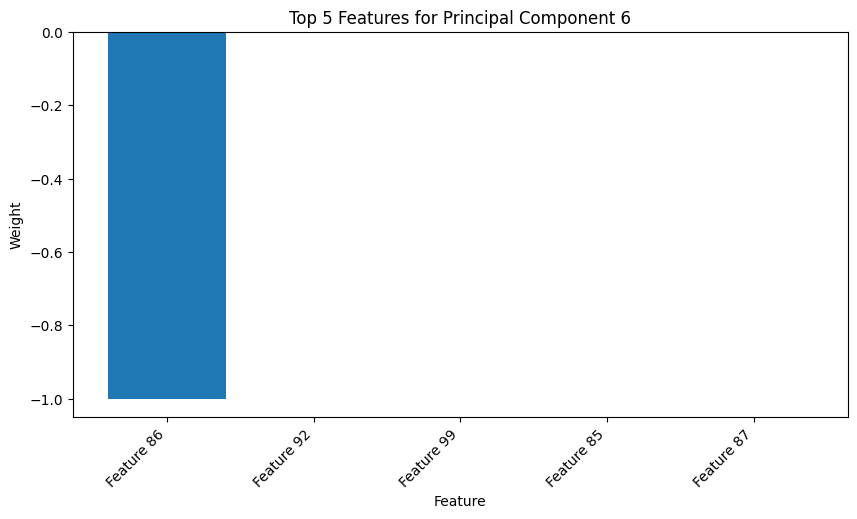

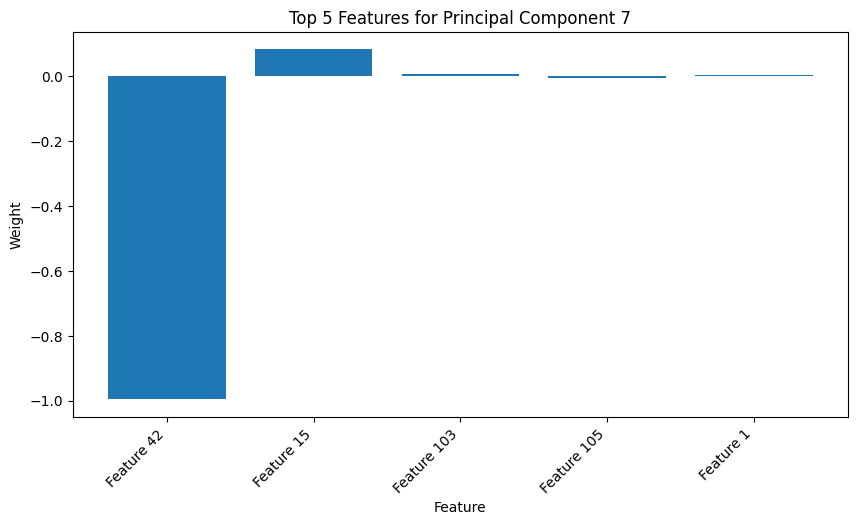

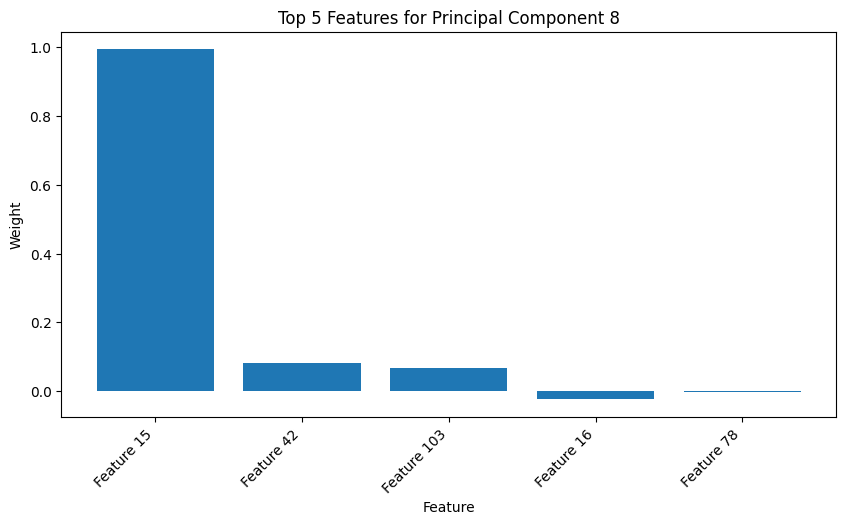

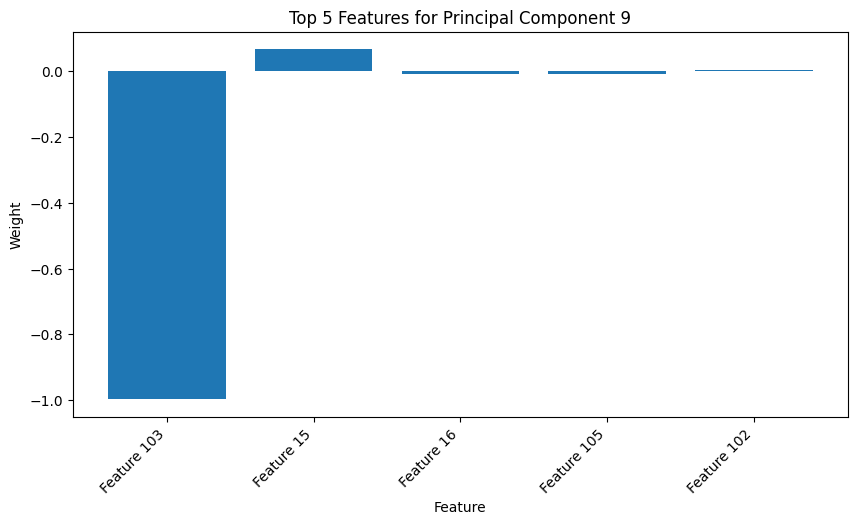

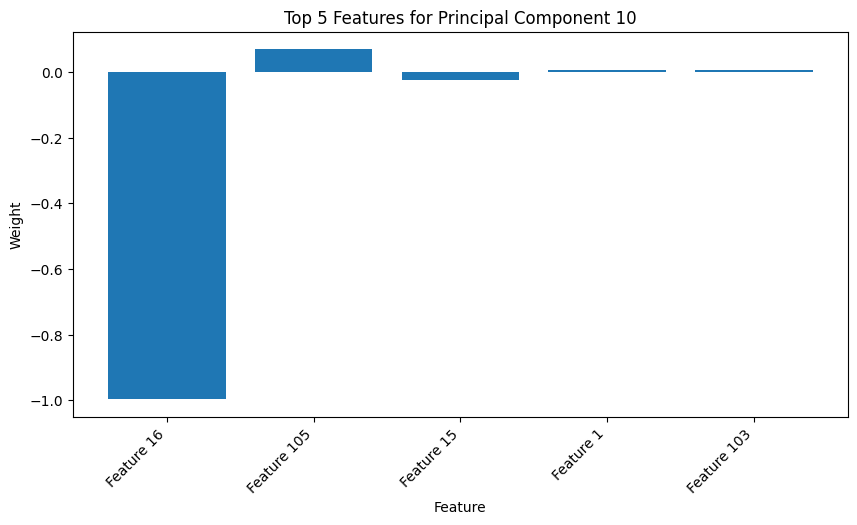

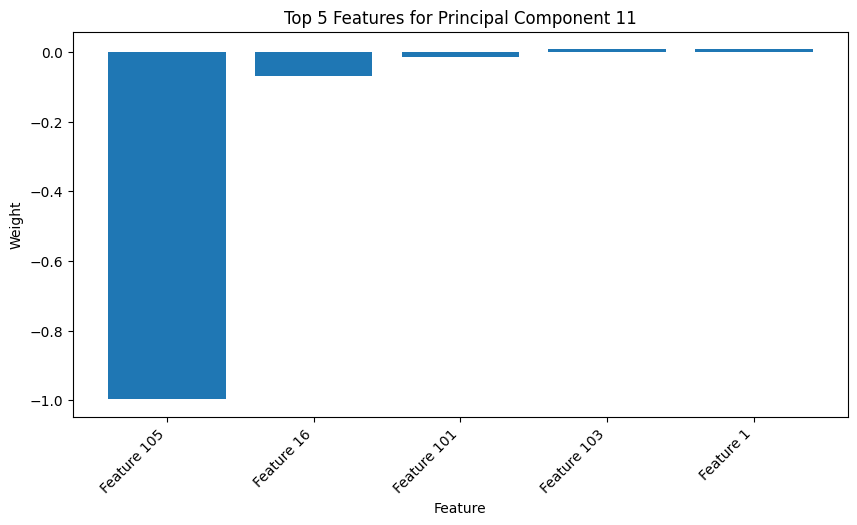

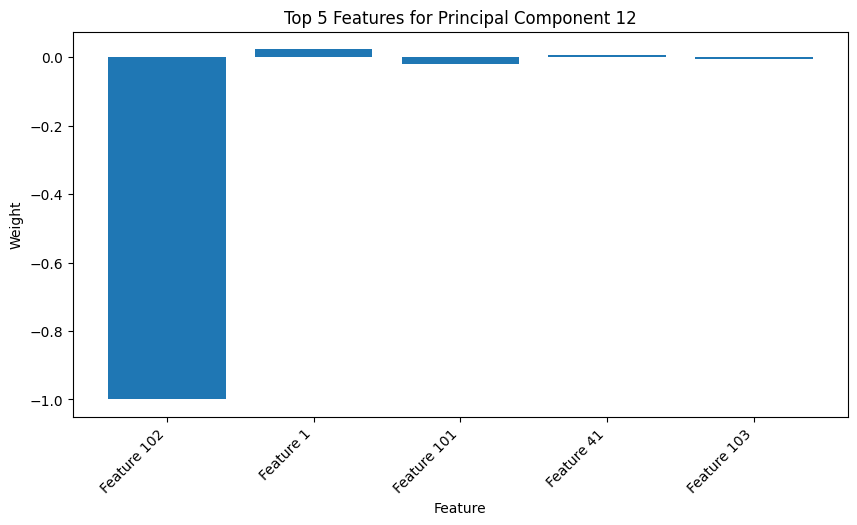

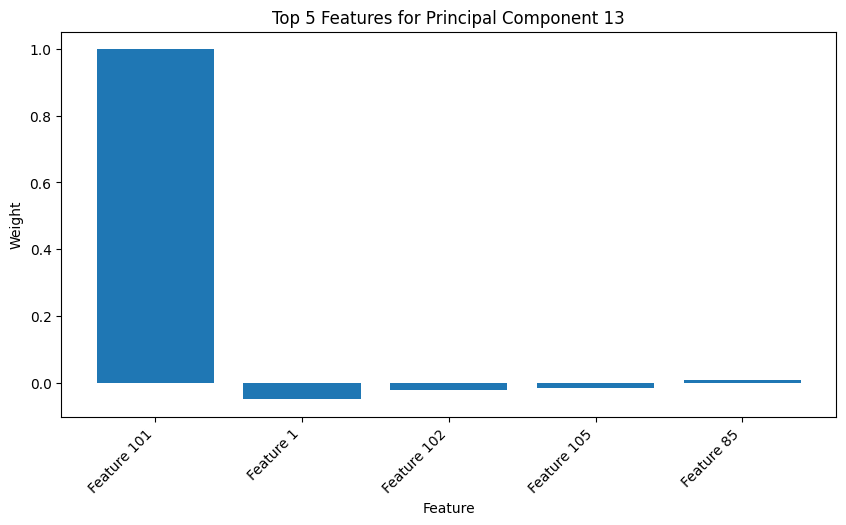

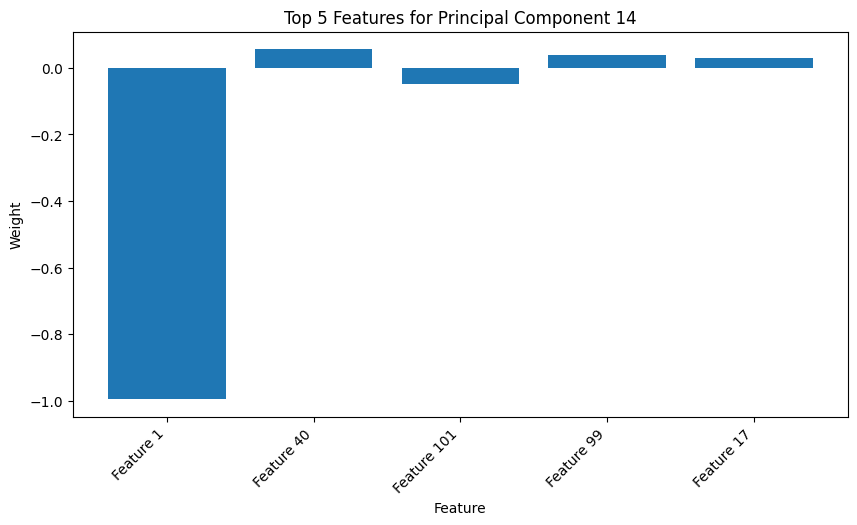

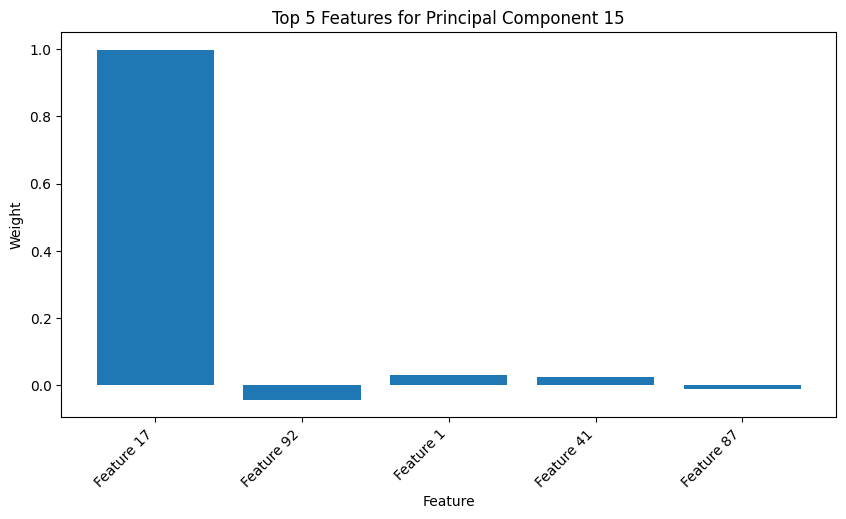

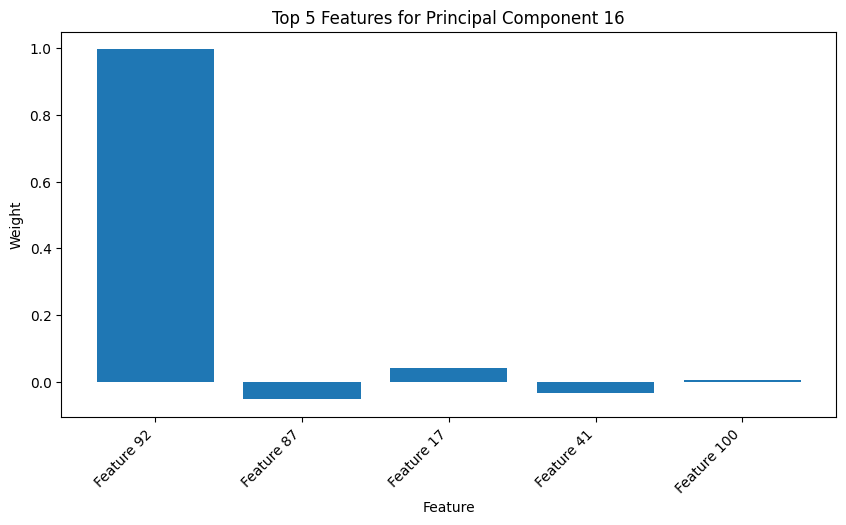

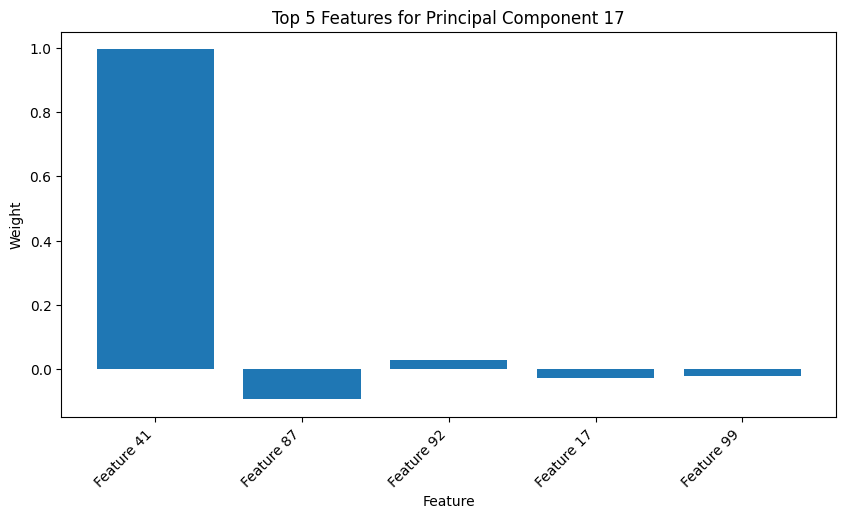

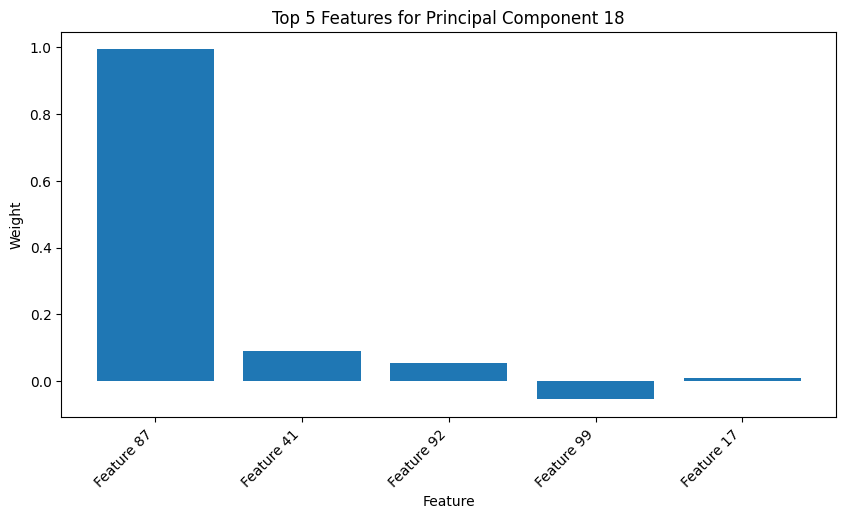

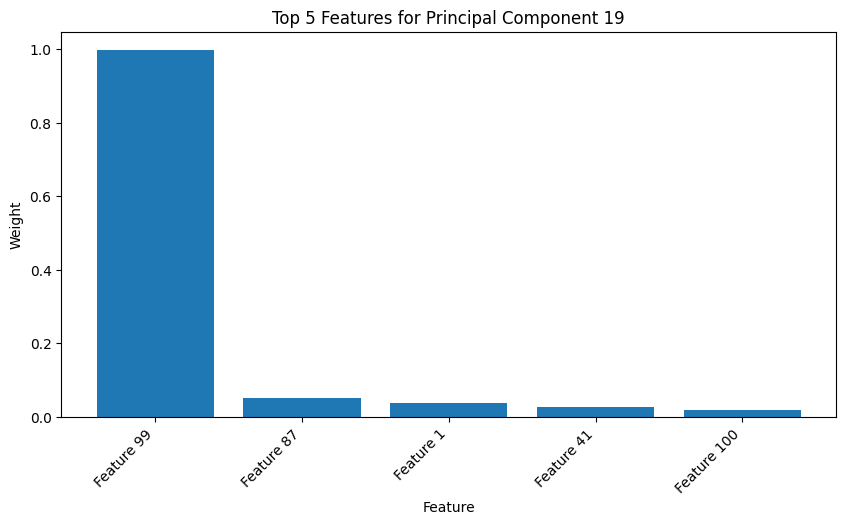

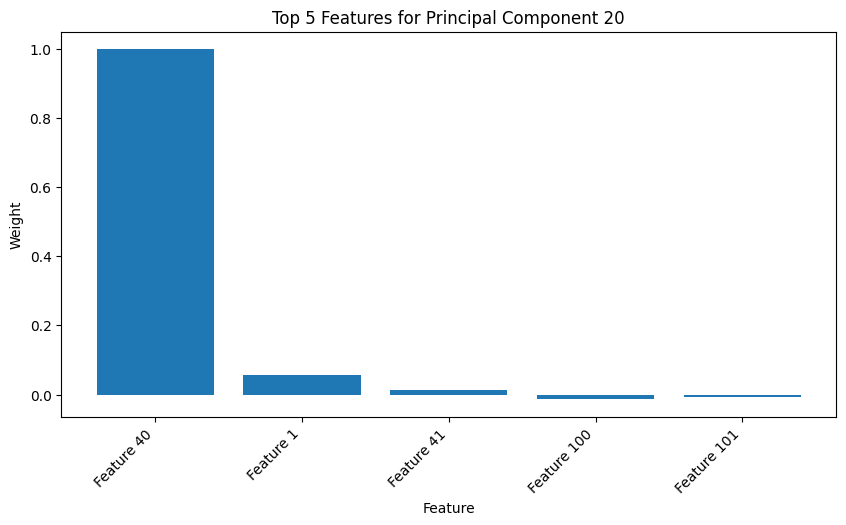

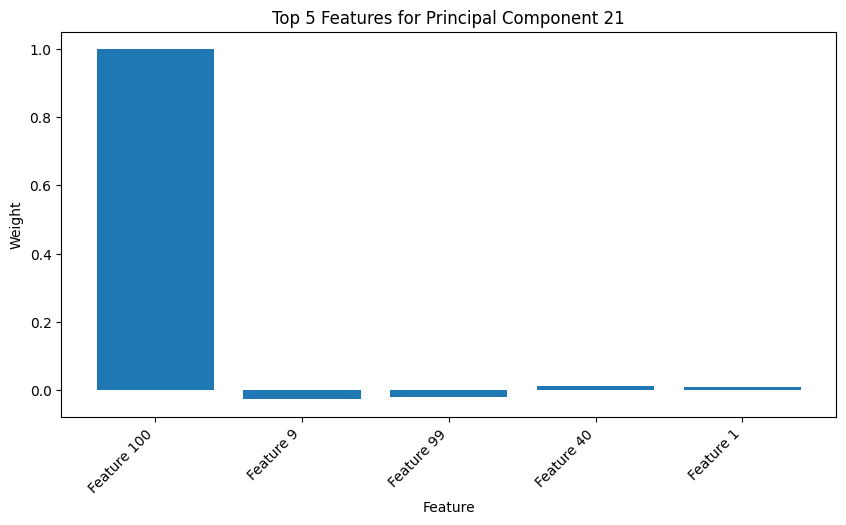

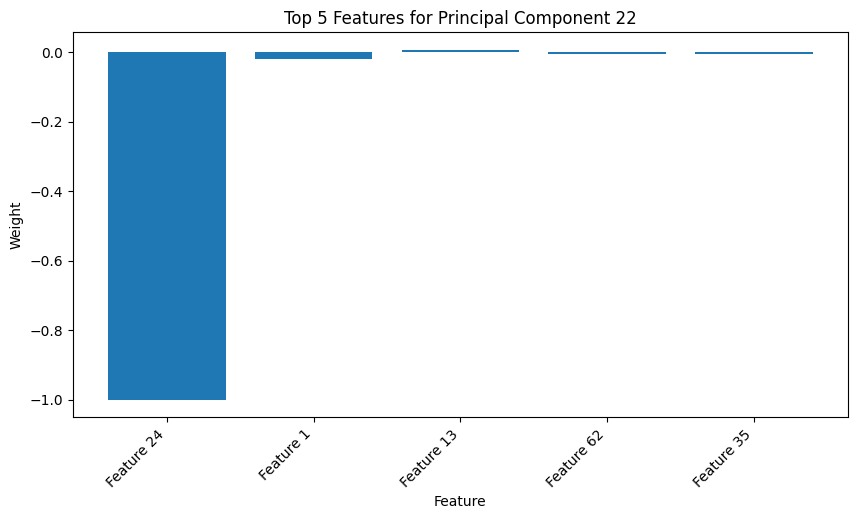

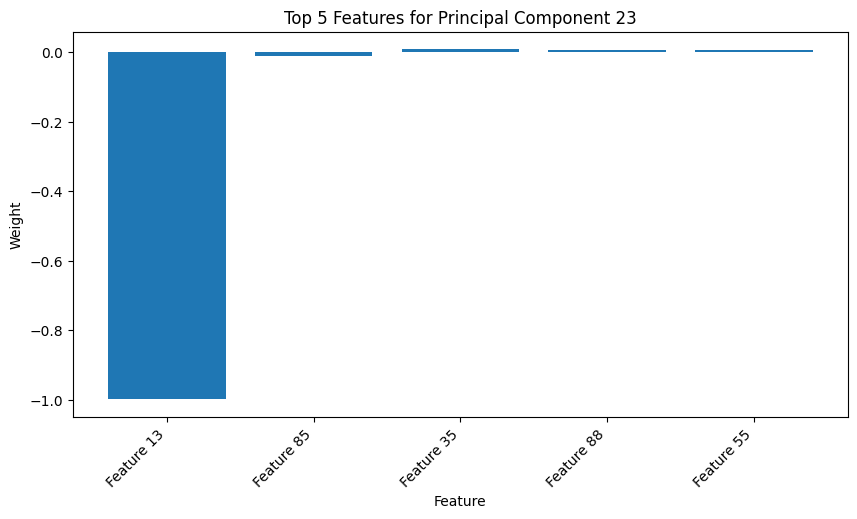

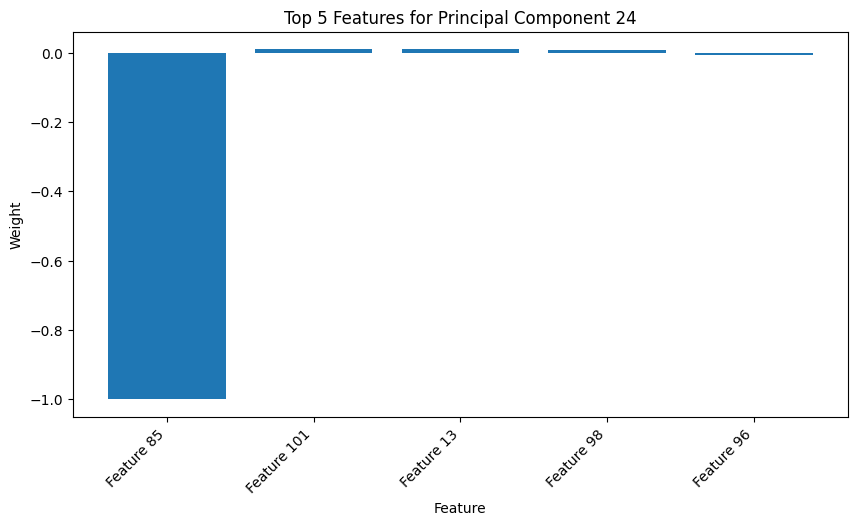

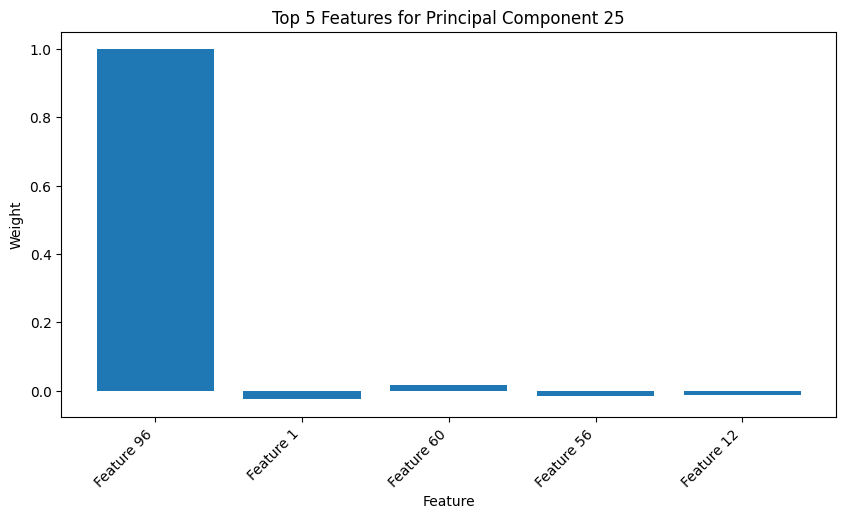

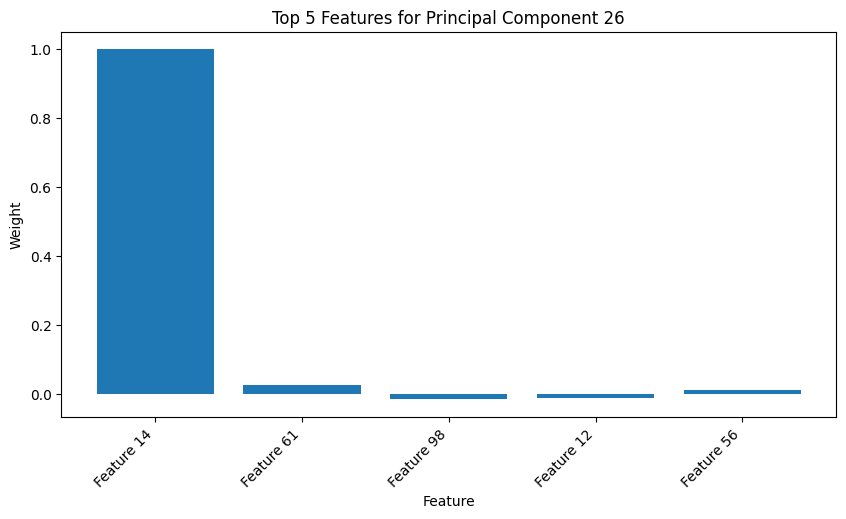

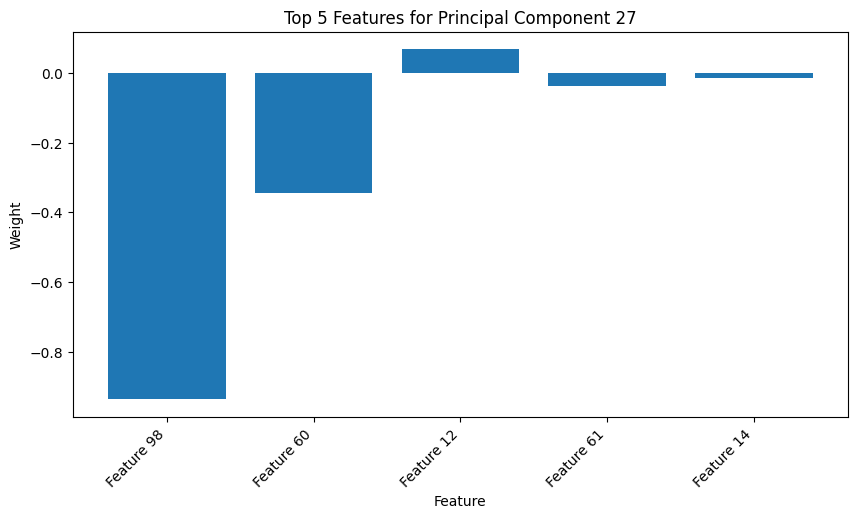

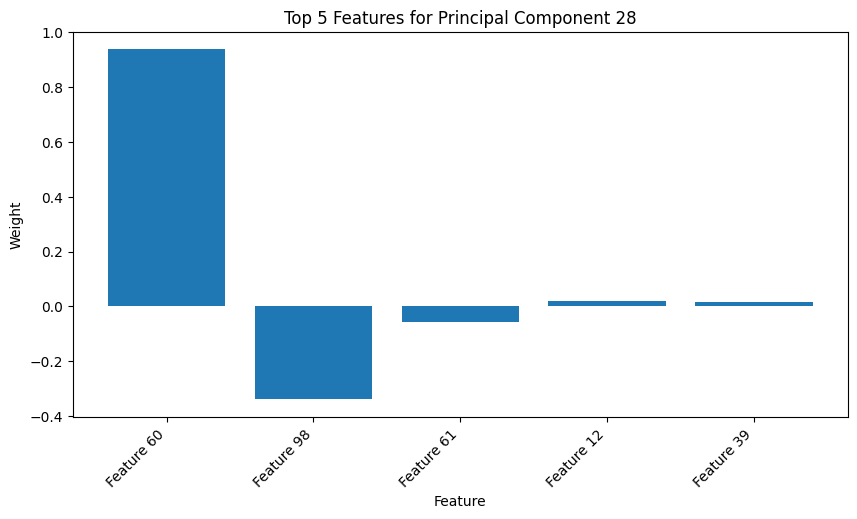

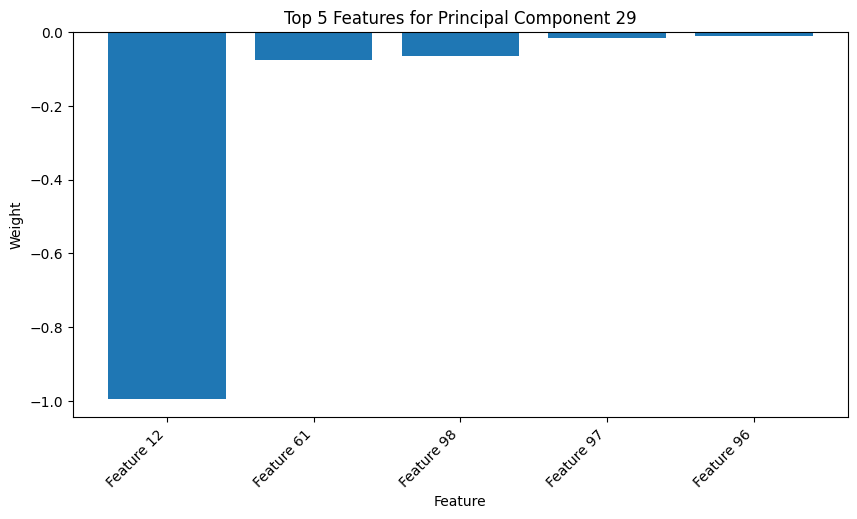

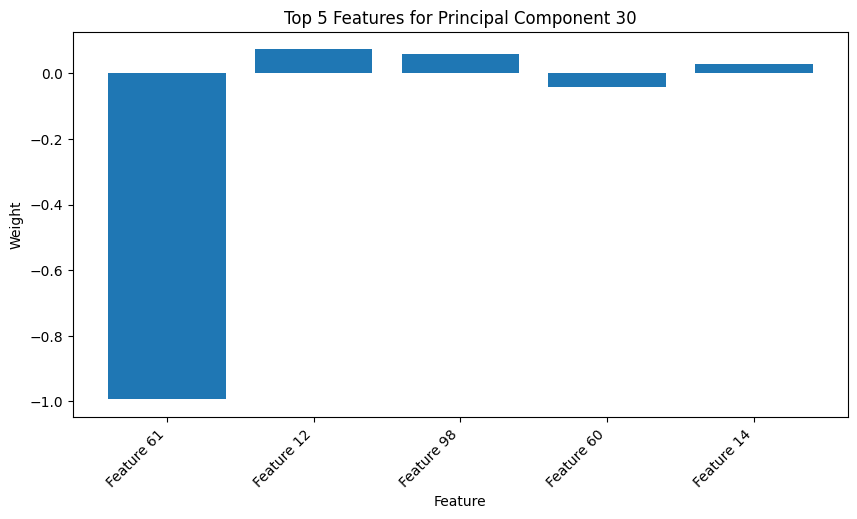

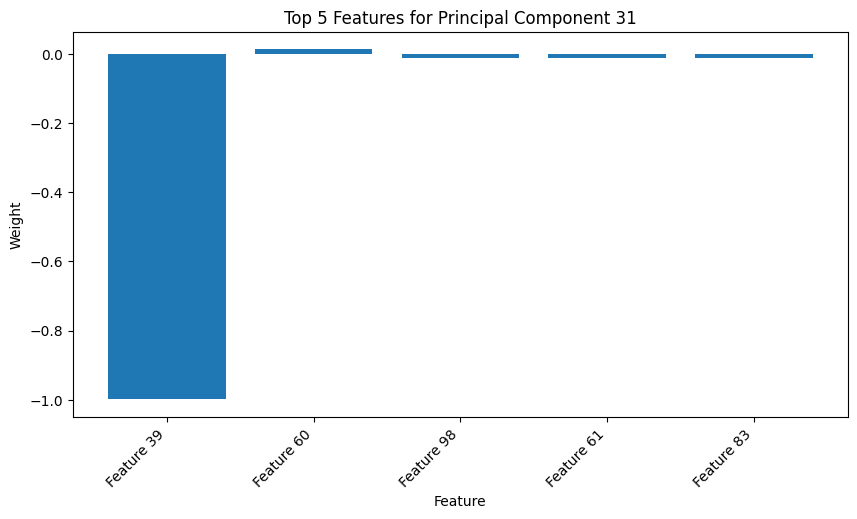

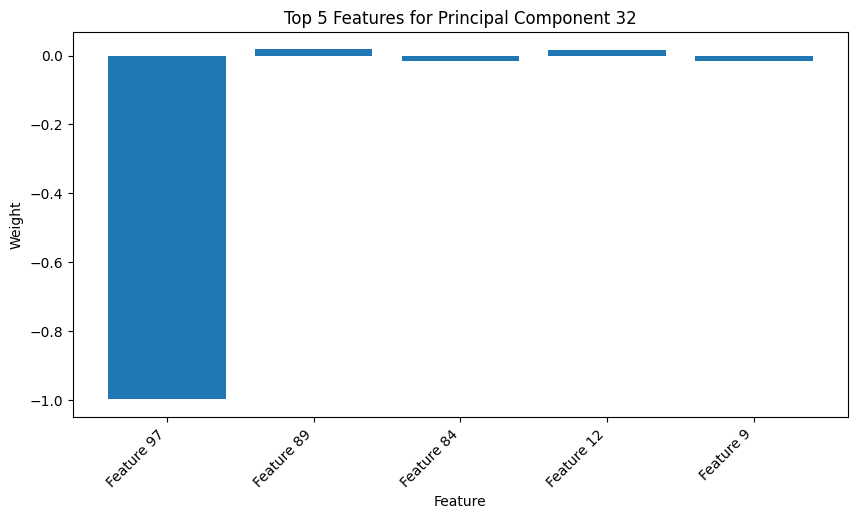

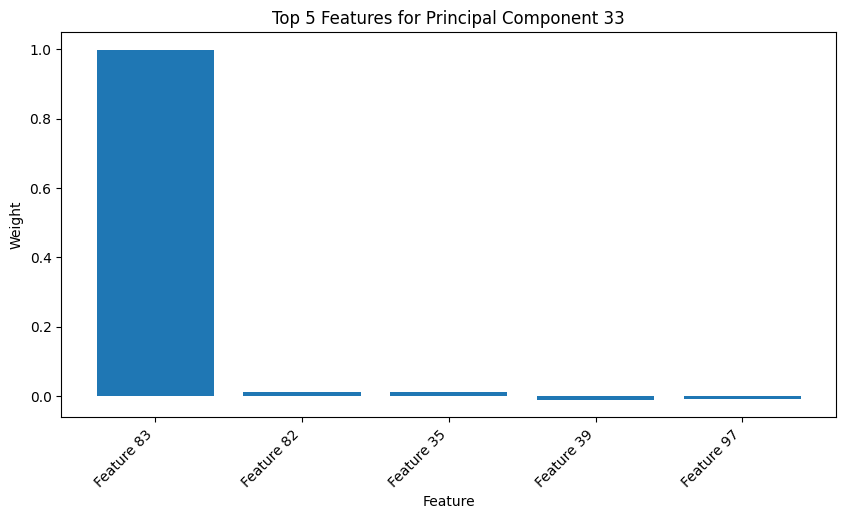

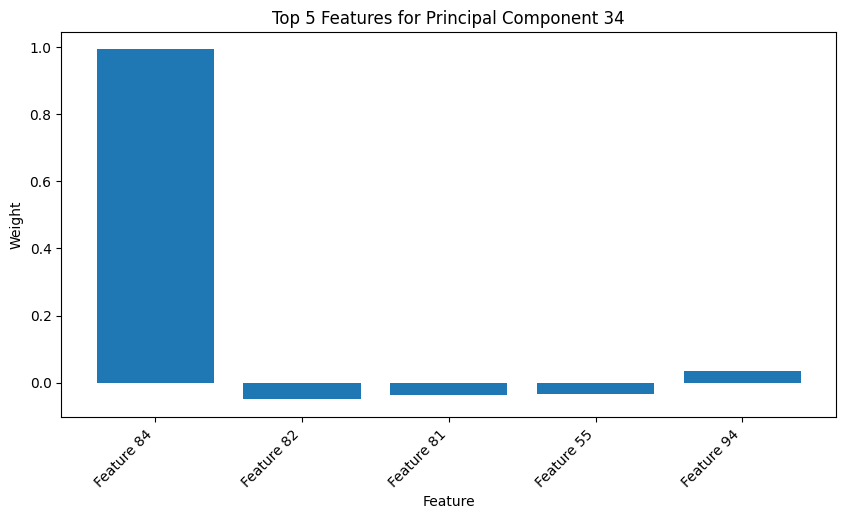

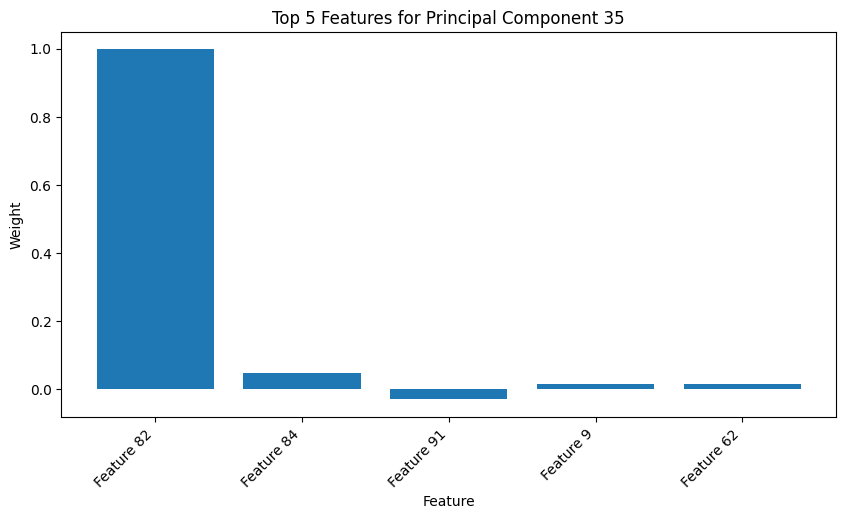

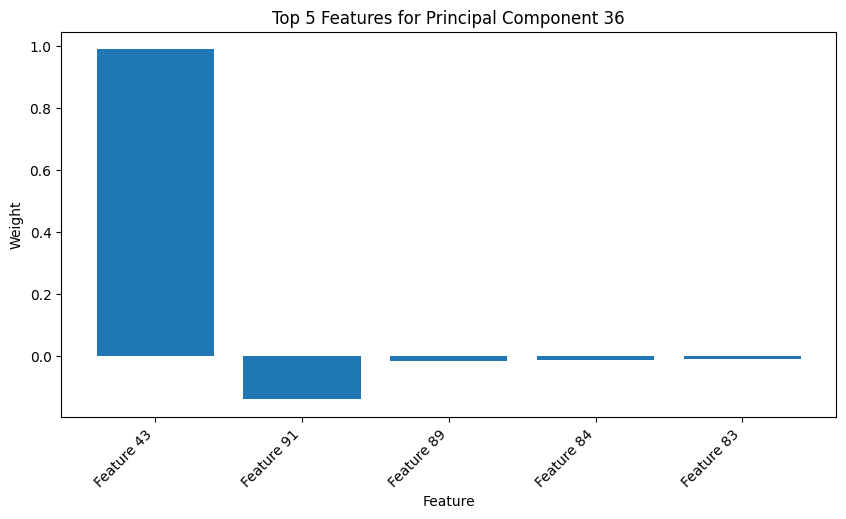

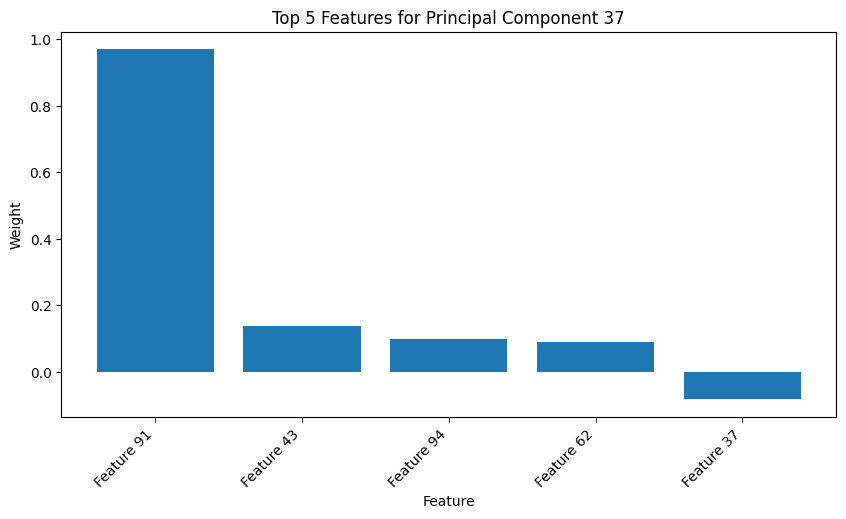

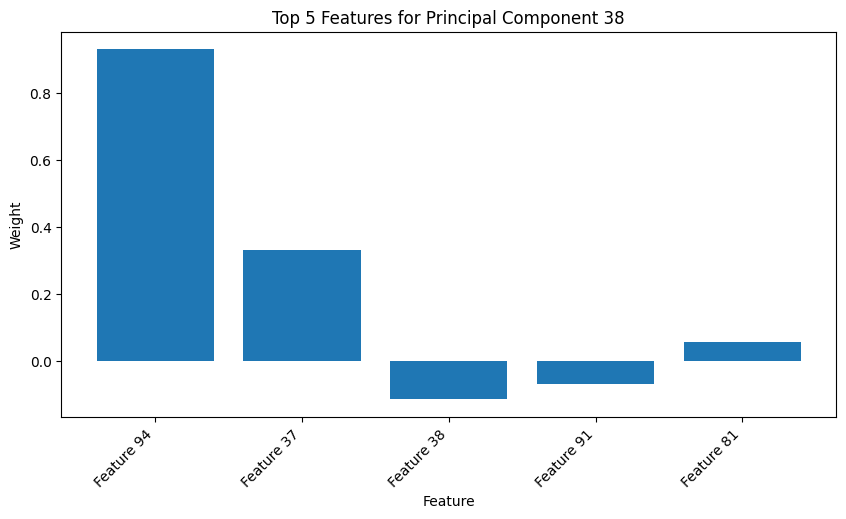

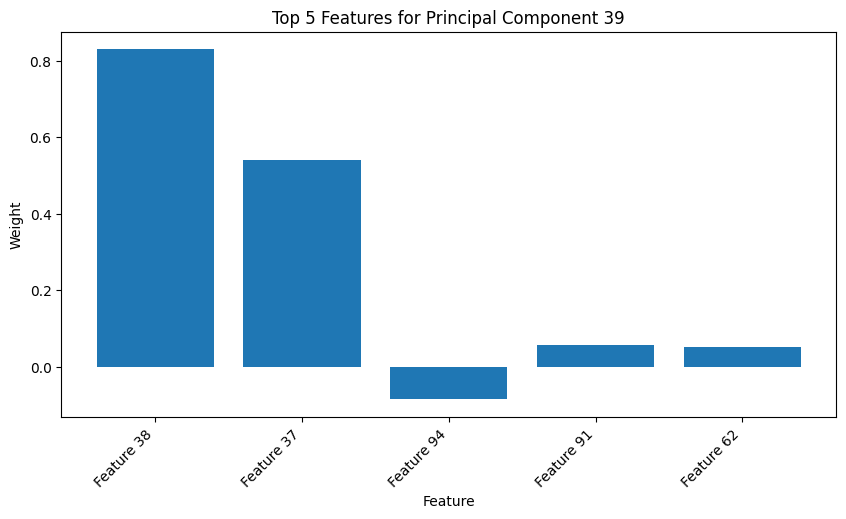

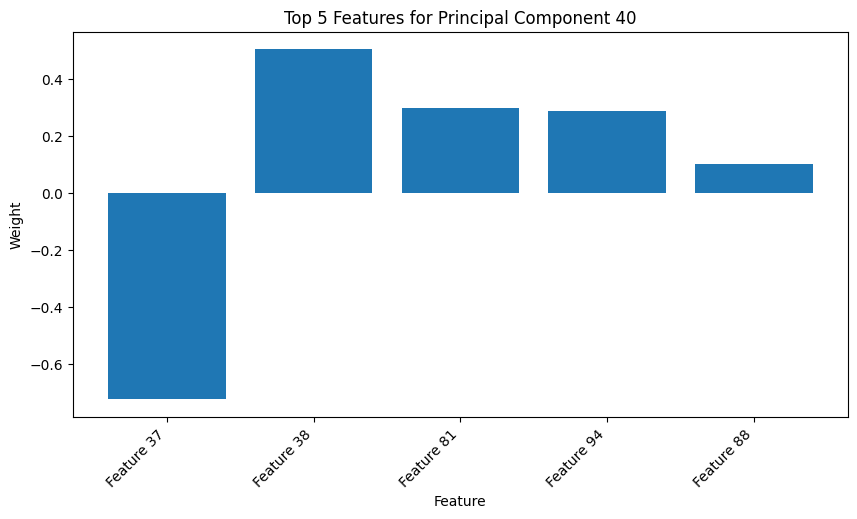

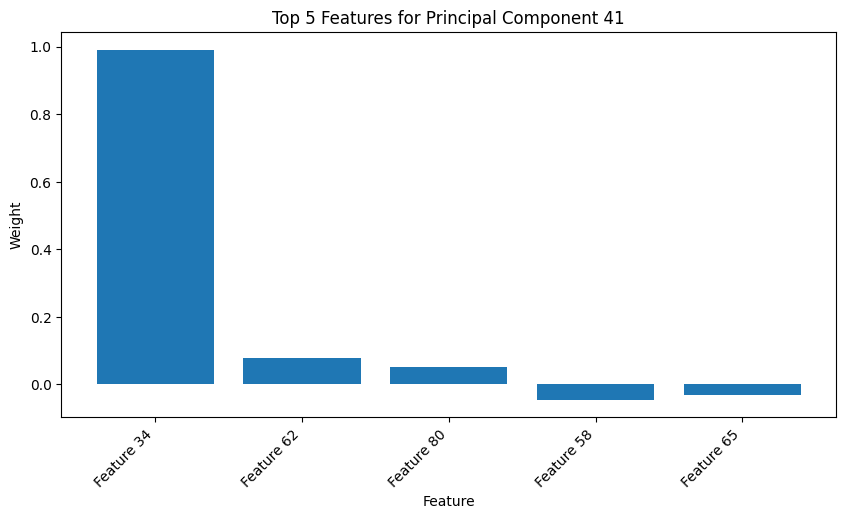

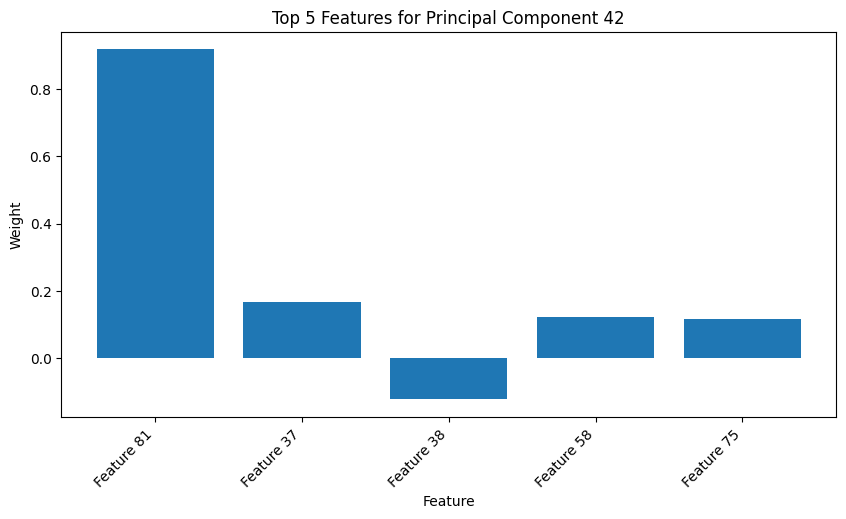

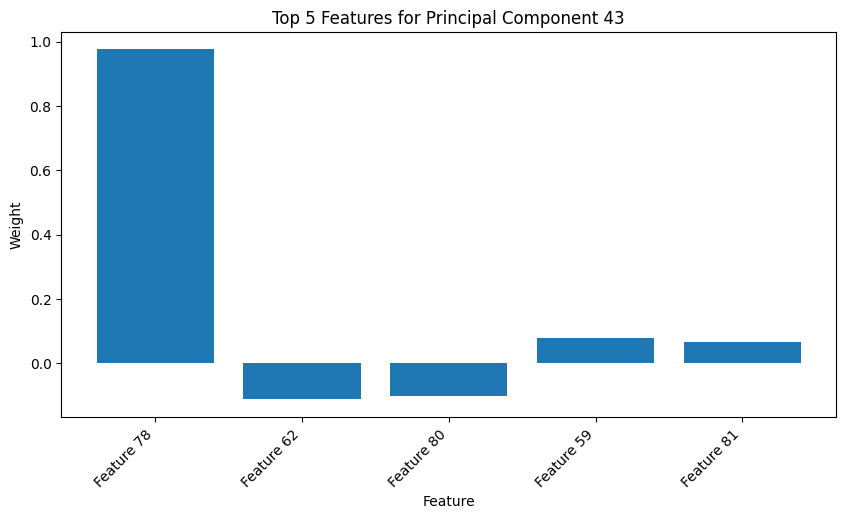

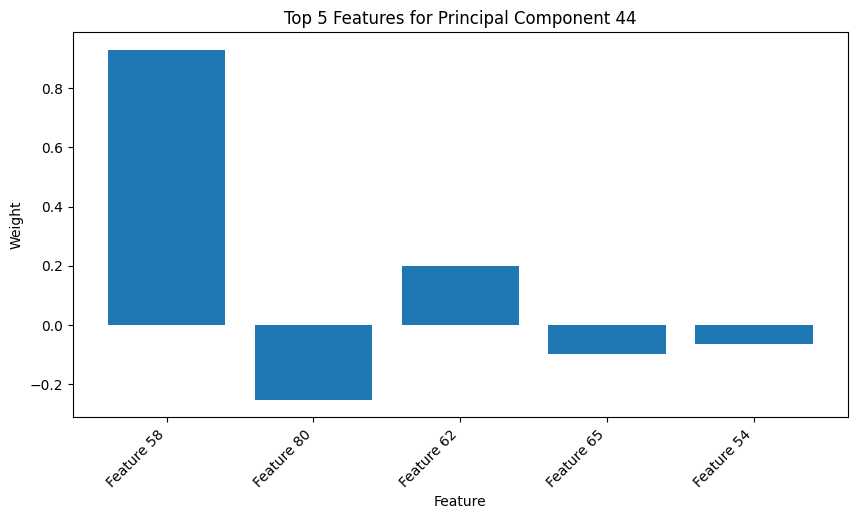

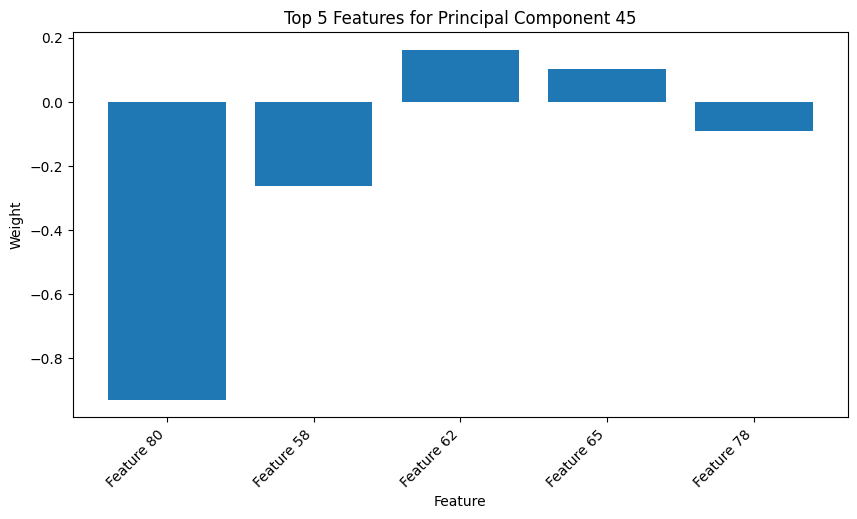

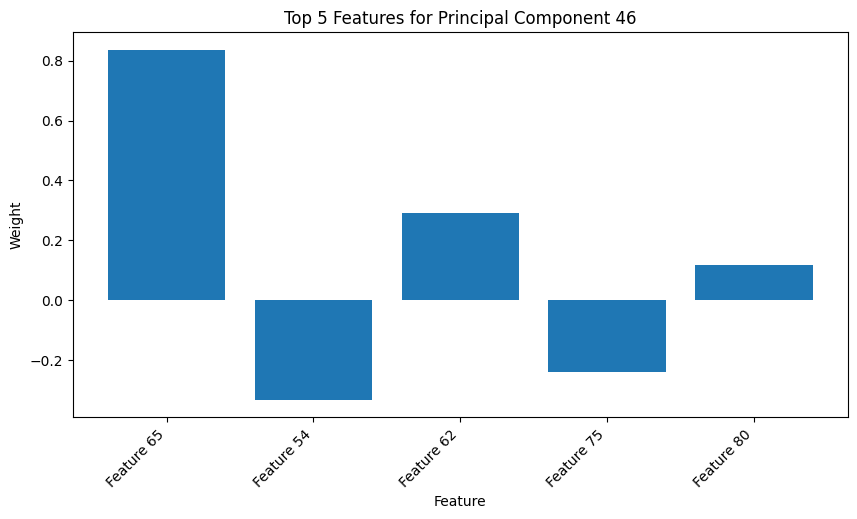

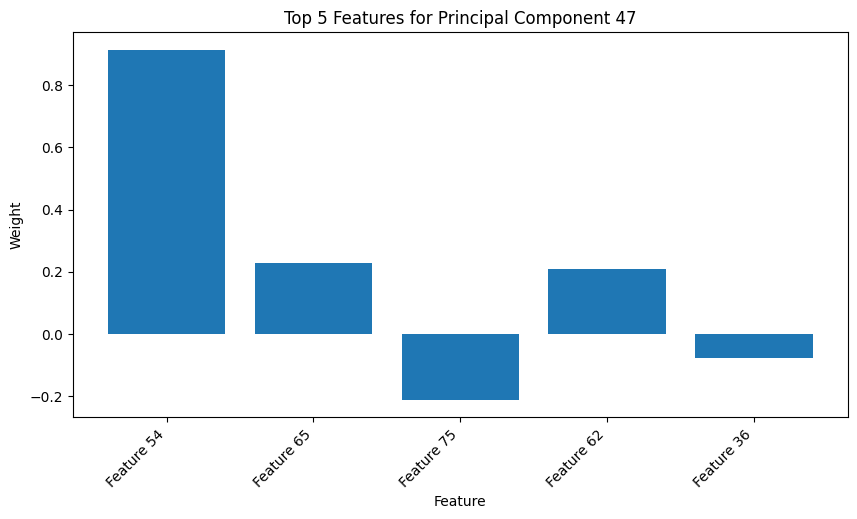

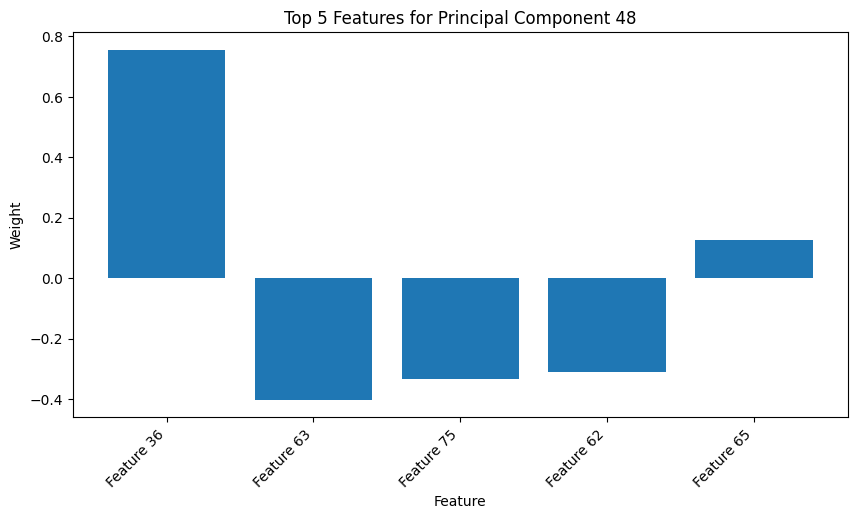

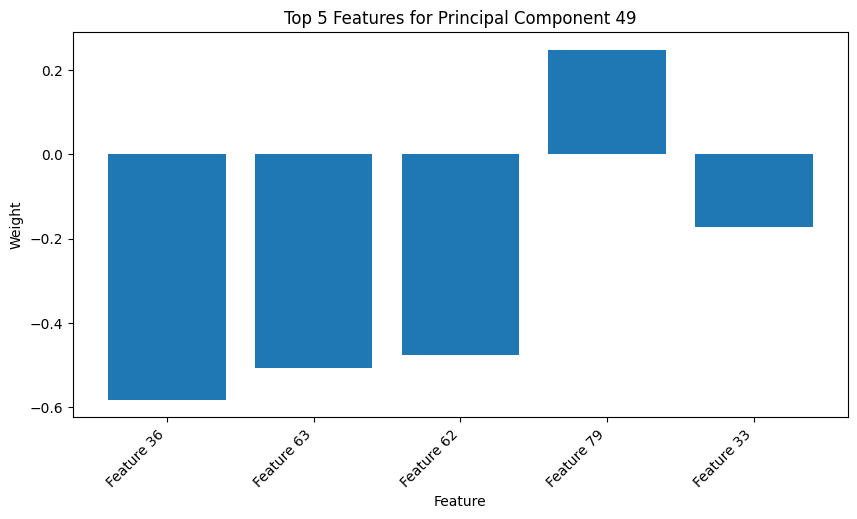

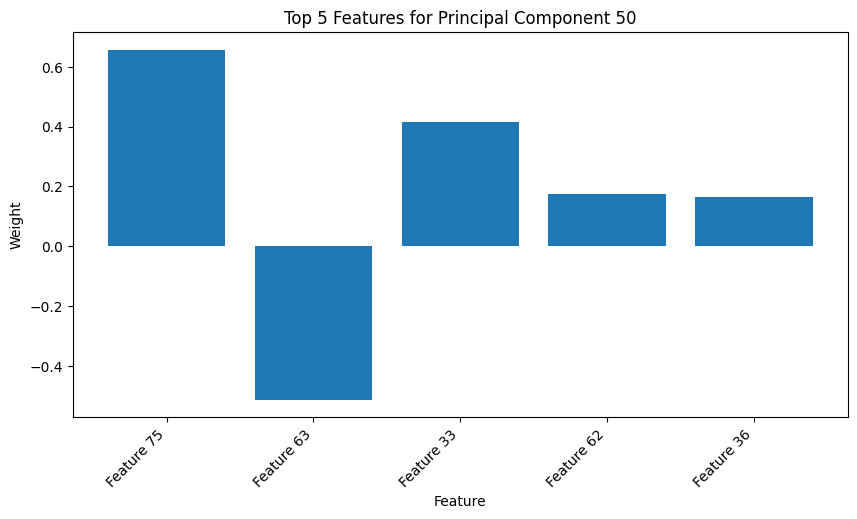

In [12]:
pca_val_ts = apply_pca(combined_val_ts)
val_reduced_dataset = generate_reduced_dataset(pca_val_ts,val_labels)

In [14]:
import tensorflow as tf
from tensorflow import keras

# # Define the model
# model = keras.Sequential()

# # Flatten the input data
# model.add(keras.layers.Flatten(input_shape=(1000, 50)))

# # Add a couple of dense layers
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dense(64, activation='relu'))

# # Output layer with 4 units (assuming you have 4 classes for classification)
# model.add(keras.layers.Dense(3, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()


# model = keras.Sequential()
# model.add(keras.layers.Flatten(input_shape=(1000, 50)))
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(3, activation='softmax'))

# # Compile the model with a lower learning rate
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#model.summary()
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(1000, 50)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# model = keras.Sequential([
#     layers.Flatten(input_shape=(1000, 50)),
#     layers.BatchNormalization(),
    
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),

#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),

#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),

#     layers.Dense(3, activation='softmax')
# ])

# # Use a different optimizer (SGD) and add learning rate scheduling
# opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense (Dense)               (None, 128)               6400128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6408579 (24.45 MB)
Trainable params: 64085

In [15]:
# Set the number of epochs
num_epochs = 100

# Train the model
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

#history = model1.fit(train_reduced_dataset, callbacks=[lr_scheduler],epochs=num_epochs, validation_data=val_reduced_dataset)
history = model.fit(train_reduced_dataset,epochs=num_epochs, validation_data=val_reduced_dataset)

Epoch 1/100
216/216 [==============================] - 12s 27ms/step - loss: 1.1704 - accuracy: 0.3384 - val_loss: 1.0131 - val_accuracy: 0.4167
Epoch 2/100
216/216 [==============================] - 5s 24ms/step - loss: 0.9531 - accuracy: 0.5175 - val_loss: 0.8972 - val_accuracy: 0.4382
Epoch 3/100
216/216 [==============================] - 5s 24ms/step - loss: 0.6114 - accuracy: 0.7798 - val_loss: 0.8521 - val_accuracy: 0.6242
Epoch 4/100
216/216 [==============================] - 5s 24ms/step - loss: 0.2658 - accuracy: 0.9351 - val_loss: 0.8418 - val_accuracy: 0.7202
Epoch 5/100
216/216 [==============================] - 5s 24ms/step - loss: 0.1261 - accuracy: 0.9706 - val_loss: 0.9041 - val_accuracy: 0.7265
Epoch 6/100
216/216 [==============================] - 5s 24ms/step - loss: 0.0802 - accuracy: 0.9807 - val_loss: 0.9780 - val_accuracy: 0.7262
Epoch 7/100
216/216 [==============================] - 5s 24ms/step - loss: 0.0596 - accuracy: 0.9849 - val_loss: 1.0224 - val_accuracy

In [16]:
# Evaluate the model on your test data using the dataset with 'comp_labels' only
test_loss, test_accuracy = model.evaluate(test_reduced_dataset)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

12/12 [==============================] - 0s 12ms/step - loss: 0.7567 - accuracy: 0.8312
Test Accuracy: 83.12%


In [60]:
pip install sklearn

  Using cached sklearn-0.0.post11.tar.gz (3.6 kB)
    ERROR: Command errored out with exit status 1:
     command: /scratch/user/swati/pip_envs/my_notebook-Python/3.8.2/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/job.9351895/pip-install-7799e_kd/sklearn/setup.py'"'"'; __file__='"'"'/tmp/job.9351895/pip-install-7799e_kd/sklearn/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/job.9351895/pip-install-7799e_kd/sklearn/pip-egg-info
         cwd: /tmp/job.9351895/pip-install-7799e_kd/sklearn/
    Complete output (18 lines):
    The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
    rather than 'sklearn' for pip commands.
    
    Here is how to fix this error in the main use cases:
    - use 'pip install scikit-learn' rather than 'pip install sklearn'
    - replace 'sklearn' by 'scikit-learn' in your pip

In [61]:
pip install scikit-learn

You should consider upgrading via the '/scratch/user/swati/pip_envs/my_notebook-Python/3.8.2/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [80]:
!pip list | grep 'tensorflow\|numpy'

numpy                         1.24.3    
tensorflow                    2.13.1    
tensorflow-estimator          2.13.0    
tensorflow-io-gcs-filesystem  0.34.0    
You should consider upgrading via the '/scratch/user/swati/pip_envs/my_notebook-Python/3.8.2/bin/python -m pip install --upgrade pip' command.
